In [15]:
from pymongo import MongoClient
import pandas as pd
from bson.objectid import ObjectId
import datetime
import time
import matplotlib.pylab as plt
import matplotlib as mpl
import numpy as np
import talib
import seaborn as sns

connectionLocal = MongoClient('18.213.229.80', 27017)
db = connectionLocal.ETF_db
TradesData = db.TradesData
arbitragecollection = db.ArbitrageCollection

# Convert UTC to EST accounting for day light saving 
import pytz
est = pytz.timezone('US/Eastern')
utc = pytz.utc
fmt = '%Y-%m-%d %H:%M:%S %Z%z'

# Jupyter Notebook to display all the columns in a df
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

/home/piyush/Desktop/etf/ETFAnalysis/env/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


# Load ETF Prices

In [16]:
def LoadETFPrices(etfname,dateOfAnalyis,year):
    starthour=dateOfAnalysis.strftime('%Y-%m-%d')+' 08:59:00'
    endhour=dateOfAnalysis.strftime('%Y-%m-%d')+' 16:01:00'
    def getHumanTime(ts=None, divideby=1000000000):
        s, ms = divmod(ts, divideby)
        return datetime.datetime(*time.gmtime(s)[:6])

    etfpricesData={}
    prices = TradesData.find_one({"symbol":etfname, 'dateForData':dateOfAnalyis})
    pricedf = pd.DataFrame(prices['data'])
    pricedf['t'] = pricedf['t'].apply(lambda x: getHumanTime(ts=x, divideby=1000))
    pricedf = pricedf.rename(columns={'t':'Time','o':'Open','h':'High','c':'Close','l':'Low','v':'Volume'})
    pricedf = pricedf[['Time','Volume','Open','Close','High','Low']]

    if dateOfAnalyis > datetime.datetime(year-1,9,1) and dateOfAnalyis < datetime.datetime(year,3,8):
        pricedf['Time']=pricedf['Time'] - datetime.timedelta(hours=5)
    else:
        pricedf['Time']=pricedf['Time'] - datetime.timedelta(hours=4)
    return pricedf[(pricedf['Time']>starthour) & (pricedf['Time']<endhour)]

def loadETFArbitrageData(etfdata,dateOfAnalyis,year):
    starthour=dateOfAnalysis.strftime('%Y-%m-%d')+' 08:59:00'
    endhour=dateOfAnalysis.strftime('%Y-%m-%d')+' 16:01:00'

    etfdata = pd.DataFrame(etfdata)
    # Convert UTC time to E"ST time, Check if winter time - 5, Summer time - 4 
    if dateOfAnalyis > datetime.datetime(year-1,9,1) and dateOfAnalyis < datetime.datetime(year,3,8):
        etfdata['Time']=etfdata['Time'] - datetime.timedelta(hours=5)
    else:
        etfdata['Time']=etfdata['Time'] - datetime.timedelta(hours=4)
    return etfdata[(etfdata['Time']>starthour) & (etfdata['Time']<endhour)]

def analysePerformance(df=None, BuySellIndex=None):
    singalDf={}
    for dateindex in BuySellIndex.index:
        idx = df.index.get_loc(dateindex)
        res=df.iloc[(idx+1) : (idx + 6)]['ETF Change Price %']
        temp = list(res.values)
        if len(res.values)<5:
            [temp.append(np.nan) for i in range(5-len(res.values))]    
        singalDf[dateindex] = temp

    singalDf=pd.DataFrame(singalDf).T
    singalDf.columns=['T+1','T+2','T+3','T+4','T+5']
    singalDf.loc['Total Return',:]=singalDf.sum(axis=0)
    return singalDf

In [17]:
## Arbitrage Direction to T+1 Minute ETF Price Change Direction Comparison

def Arb_Tp1(arbdf, dateOfAnalysis, ArbitrageModVal):
#     etfdata = extract_arbitrage_data(etfname, dateOfAnalysis)
    etfdata = arbdf
    etfarbdf = etfdata[['Time','ETF Change Price %','Arbitrage in $','ETFMover%1','ETFMover%2','ETFMover%3','Change%1','Change%2','Change%3']]
    etfarbdf.set_index('Time', inplace=True)
    
    def tplusone(df):
        df = df.copy()
        arbtpo = None
        for timst in df.index:
            req = timst+datetime.timedelta(minutes=1)
            try:
                arbtpo = df.loc[pd.Timestamp(req),'ETF Change Price %']
                df.loc[pd.Timestamp(timst),'T+1 Return'] = arbtpo
            except:
                pass
        return df
    etfarbdf = tplusone(etfarbdf)

    etfarbdfr = etfarbdf[abs(etfarbdf['Arbitrage in $'])>ArbitrageModVal]

    moverset = set()
    moverslist = []
    moverslist.extend(list(etfarbdfr['ETFMover%1']))
    moverslist.extend(list(etfarbdfr['ETFMover%2']))
    moverslist.extend(list(etfarbdfr['ETFMover%3']))
    for mover in moverslist:
        moverset.add(mover[0])

    arb_t1_df = pd.DataFrame(columns = ['dateOfAnalysis','Movers','Arb +ve/ T+1 +ve','Arb +ve/ T+1 -ve','Arb -ve/ T+1 +ve','Arb -ve/ T+1 -ve'])
    for mover in list(moverset):
        stats = {"Movers":mover,"Arb +ve/ T+1 +ve":0,"Arb +ve/ T+1 -ve":0,"Arb -ve/ T+1 +ve":0,"Arb -ve/ T+1 -ve":0}
        for t in etfarbdfr.index:
            if mover in (etfarbdfr.loc[t, 'ETFMover%1'][0],etfarbdfr.loc[t, 'ETFMover%2'][0],etfarbdfr.loc[t, 'ETFMover%3'][0]):
                if etfarbdfr.loc[t,'Arbitrage in $'] > 0 : 
                    if etfarbdfr.loc[t,'T+1 Return'] > 0 :
                        stats['Arb +ve/ T+1 +ve'] +=1
                    else:
                        stats['Arb +ve/ T+1 -ve'] +=1
                else:
                    if etfarbdfr.loc[t,'T+1 Return'] > 0 :
                        stats['Arb -ve/ T+1 +ve'] +=1
                    else:
                        stats['Arb -ve/ T+1 -ve'] +=1
        arb_t1_df = arb_t1_df.append(stats, ignore_index=True)

    arb_t1_df['TotalNoOfCases'] = sum([arb_t1_df['Arb +ve/ T+1 +ve'],arb_t1_df['Arb +ve/ T+1 -ve'],arb_t1_df['Arb -ve/ T+1 +ve'],arb_t1_df['Arb -ve/ T+1 -ve']])
    arb_t1_df = arb_t1_df.sort_values(by=['TotalNoOfCases'], ascending=False)

    arb_t1_df['total_arbp'] = arb_t1_df['Arb +ve/ T+1 +ve']+ arb_t1_df['Arb +ve/ T+1 -ve']
    arb_t1_df['total_arbn'] = arb_t1_df['Arb -ve/ T+1 +ve']+ arb_t1_df['Arb -ve/ T+1 -ve']

    def prob_percent(val, total):
        if total == 0:
            return None
        return (val/total)*100

    for col in arb_t1_df.columns:
        if col not in ['Movers','TotalNoOfCases','total_arbp','total_arbn']:
            if col not in ['Arb -ve/ T+1 +ve','Arb -ve/ T+1 -ve']:
                arb_t1_df[col] = arb_t1_df.apply(lambda x: prob_percent(x[col],x['total_arbp']),axis=1)
            if col not in ['Arb +ve/ T+1 +ve','Arb +ve/ T+1 -ve']:
                arb_t1_df[col] = arb_t1_df.apply(lambda x: prob_percent(x[col],x['total_arbn']),axis=1)
    arb_t1_df['dateOfAnalysis'] = dateOfAnalysis
    arb_t1_df.set_index(['dateOfAnalysis','Movers'])
    return arb_t1_df

# Build Signals

## Strategy Notes - 4 Types of signals

#### Buy = Green = Upward Arrow = etfOverSold = -111
#### Sell = Blue = Downward Arrow = etfoverBought = 111


#### 4 Types of Signals

Type 1) When Buy Signal is at the tip of trend reversal and it's bullish for (T+1 min, T+2 min) - Good Signal<br>
Type 2) When Sell Signal is at the tip of trend reversal and it's bearish for (T+1, T+2 min). - Good Signal.<br>
Type 3) When Algorithm gives Buy Signal because the ETF is underpriced. But due to momentum, the market continues to go down. - Bad Signal<br>
Type 4) When Algorithm Gives Sell Signal because the ETF is overpriced. But due to momentum, the market continues to go up. - Bad Signal<br>

Combine trend with Buy and sell. 

In [18]:
def BuildSignals(df,tp=14):
    # SMA
    df['Momentum Signal']=talib.SMA(df['ETF Price'],timeperiod=tp)
    description='SMA'
    df['Momentum Indicator'] = 0
    df.loc[(abs(df['ETF Price']) > df['Momentum Signal']), 'Momentum Indicator'] = 111
    df.loc[(abs(df['ETF Price']) < df['Momentum Signal']), 'Momentum Indicator'] = -111

    # CMO - Chande Momentum Oscillator
    df['CMO Signal']=talib.CMO(df['Close'],timeperiod=tp)
    description='CMO'
    df['CMO Indicator'] = 0
    df.loc[df['CMO Signal']>=50, 'CMO Indicator'] = 111
    df.loc[df['CMO Signal']<=-50, 'CMO Indicator'] = -111
    
    # ADX
    df['ADX Signal']=talib.ADX(df['High'],df['Low'],df['Close'],timeperiod=tp)
    description='ADX'
    df['ADX Trend'] = 0
    df.loc[df['ADX Signal']<25, 'ADX Trend'] = 'No Trend'
    df.loc[df['ADX Signal']>=25, 'ADX Trend'] = 'Weak Trend'
    df.loc[df['ADX Signal']>=50, 'ADX Trend'] = 'Strong Trend'
    df.loc[df['ADX Signal']>=75, 'ADX Trend'] = 'Extreme Strong Trend'

    # AROONOSC
    df['AROONOSC Signal']=talib.AROONOSC(df['High'],df['Low'],timeperiod=tp)
    df['AROONOSC Indicator'] = 0
    df.loc[df['AROONOSC Signal'] > 50, 'AROONOSC Trend'] = 'Uptrend'
    df.loc[df['AROONOSC Signal'] > 75, 'AROONOSC Trend'] = 'Strong Uptrend'
    df.loc[df['AROONOSC Signal'] < -50, 'AROONOSC Trend'] = 'Downtrend'
    df.loc[df['AROONOSC Signal'] < -75, 'AROONOSC Trend'] = 'Strong Downtrend'

    # RSI
    df['RSI Signal']=talib.RSI(df['Close'],timeperiod=tp)
    df['RSI Indicator'] = 0
    df.loc[df['RSI Signal']>=75, 'RSI Indicator'] = 111
    df.loc[df['RSI Signal']<=25, 'RSI Indicator'] = -111
    
    # ULTOSC - Ultimate Oscillator
    df['ULTOC Signal']=talib.ULTOSC(df['High'],df['Low'],df['Close'],timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['ULTOC Indicator'] = 0
    df.loc[df['ULTOC Signal']>=75, 'ULTOC Indicator'] = 111
    df.loc[df['ULTOC Signal']<=25, 'ULTOC Indicator'] = -111
    
    # WILLR  
    df['WILLR Signal']=talib.WILLR(df['High'],df['Low'],df['Close'],timeperiod=tp)
    df['WILLR Indicator'] = 0
    df.loc[df['WILLR Signal']>=-20, 'WILLR Indicator'] = 111
    df.loc[df['WILLR Signal']<=-80, 'WILLR Indicator'] = -111
    
    # MFI - Monet Flow Index
    df['MFI Signal']=talib.MFI(df['High'],df['Low'],df['Close'],df['Volume'],timeperiod=tp)
    df['MFI Indicator'] = 0
    df.loc[df['MFI Signal']>=75, 'MFI Indicator'] = 111
    df.loc[df['MFI Signal']<=25, 'MFI Indicator'] = -111
    
    # STOCHRSI
    fastk, fastd=talib.STOCHRSI(df['ETF Price'], timeperiod=tp, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['FastStochastic']=fastk
    df['Stochastic Indicator']=np.where(fastk>80, 111, 0)+np.where(fastk<20, -111, 0)
    
    return df

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
17  2020-03-18     UNH    26.250000         73.750000          
9   2020-03-18     PFE    27.777778         72.222222          
14  2020-03-18     ABT    26.923077         73.076923          
2   2020-03-18     MRK    24.000000         76.000000          
29  2020-03-18     TMO    26.829268         73.170732          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
17  44.117647         55.882353         148            80         68         
9   54.000000         46.000000         104            54         50         
14  45.652174         54.347826         98             52         46         
2   46.341463         53.658537         91             50         41         
29  44.736842         55.263158         79             41         38

ETF Name =FHLC
Date =2020-03-18 00:00:00
Sell Positions Probability
T+1    1.000000
T+2    0.333333
T+3    0.666667
T+4    0.000000
T+5    0.333333
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-18 12:46:00  0.148067                 0.174091        Weak Trend   
2020-03-18 13:11:00  0.365412                 0.901013        Weak Trend   
Total Return        NaN                      NaN              NaN          

                    AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-18 12:46:00  NaN            111.0               0.0             
2020-03-18 13:11:00  NaN            111.0               0.0             
Total Return         NaN           NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-03-18 12:46:00  0.0            0.0              111.0                  
2020-03-18 13:11:00  0.0           -111.0            111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-03-18 12:46:00  111.0           -111.0         -0.487733 -0.142035   
2020-03-18 13:11:00 -111.0            111.0         -2.050000  0.153139   
Total Return        NaN              NaN            -2.537733  0.011104   

                          T+3       T+4       T+5  
2020-03-18 12:46:00  0.126943  0.000000  0.075102  
2020-03-18 13:11:00 -0.222987  0.006385 -0.015068  
Total Return        -0.096044  0.006385  0.060034

******************
Buy Positions Probability
T+1    0.555556
T+2    0.666667
T+3    0.222222
T+4    0.333333
T+5    0.111111
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $     ADX Trend  \
2020-03-18 10:06:00  0.207413                -0.232484        Strong Trend   
2020-03-18 10:47:00  0.165833                -0.187454        No Trend       
2020-03-18 10:52:00  0.160472                -0.196023        Weak Trend     
2020-03-18 12:06:00  0.168916                -0.207311        No Trend       
2020-03-18 12:20:00  0.094556                -0.124131        Weak Trend     
2020-03-18 13:12:00  0.380667                -0.904311        Weak Trend     
2020-03-18 13:59:00  0.163052                -0.186140        No Trend       
2020-03-18 14:05:00  0.101591                -0.192915        No Trend       
Total Return        NaN                      NaN              NaN            

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-18 10:06:00  Strong Uptrend    111.0               0.0             
2020-03-18 10:47:00  NaN              -111.0               0.0             
2020-03-18 10:52:00  Downtrend        -111.0              -111.0           
2020-03-18 12:06:00  Strong Downtrend -111.0               0.0             
2020-03-18 12:20:00  NaN              -111.0               0.0             
2020-03-18 13:12:00  NaN              -111.0               0.0             
2020-03-18 13:59:00  NaN              -111.0               0.0             
2020-03-18 14:05:00  Strong Downtrend -111.0               0.0             
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-03-18 10:06:00  0.0            0.0             -111.0                  
2020-03-18 10:47:00  0.0            0.0             -111.0                  
2020-03-18 10:52:00 -111.0         -111.0           -111.0                  
2020-03-18 12:06:00  0.0           -111.0           -111.0                  
2020-03-18 12:20:00  0.0            0.0              0.0                    
2020-03-18 13:12:00  0.0           -111.0           -111.0                  
2020-03-18 13:59:00  0.0            0.0             -111.0                  
2020-03-18 14:05:00  0.0            0.0             -111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-03-18 10:06:00  0.0              111.0          0.314574  0.000000   
2020-03-18 10:47:00 -111.0            0.0            0.000000  0.037331   
2020-03-18 10:52:00 -111.0           -111.0         -0.024988  0.137466   
2020-03-18 12:06:00 -111.0            0.0            0.502576  0.187023   
2020-03-18 12:20:00 -111.0           -111.0          0.000000  0.000000   
2020-03-18 13:12:00 -111.0            0.0            0.153139 -0.222987   
2020-03-18 13:59:00 -111.0            0.0           -0.000129  0.185759   
2020-03-18 14:05:00  0.0              0.0            0.594469  0.025694   
Total Return        NaN              NaN             1.539641  0.350286   

                          T+3       T+4       T+5  
2020-03-18 10:06:00  0.000000 -0.766819 -0.270584  
2020-03-18 10:47:00  0.000000  0.000000 -0.768659  
2020-03-18 10:52:00 -0.226881  0.000000  0.000000  
2020-03-18 12:06:00  0.000000 -0.174196 -0.323750  
2020-03-18 12:20:00  0.000000  0.202943  0.025696  
2020-03-18 13:12:00  0.006385 -0.015068 -0.227591  
2020-03-18 13:59:00  0.046354  0.084041  0.000000  
2020-03-18 14:05:00 -0.102363  0.076755 -0.089928  
Total Return        -0.276506 -0.592344 -1.654816

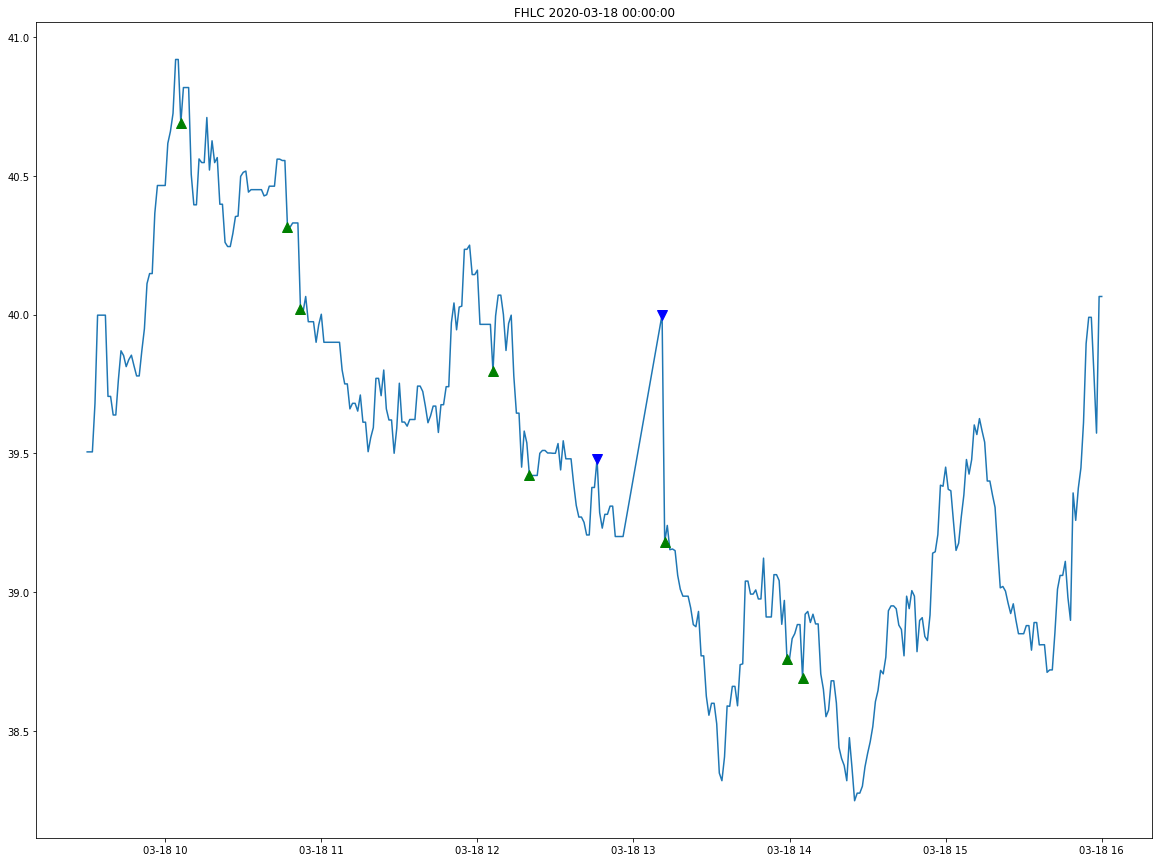

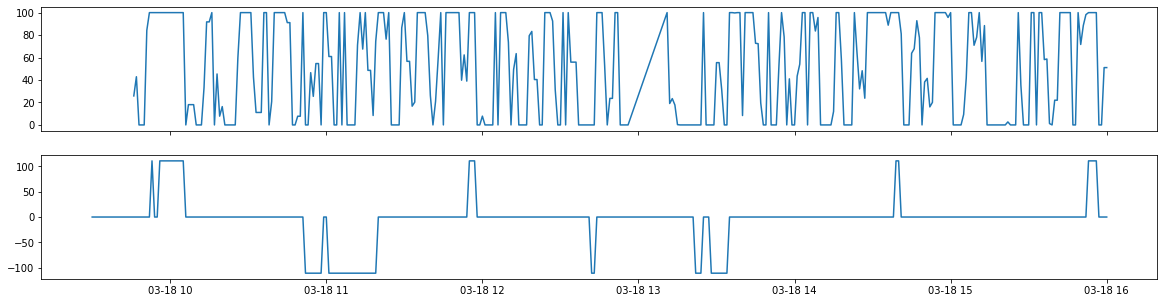

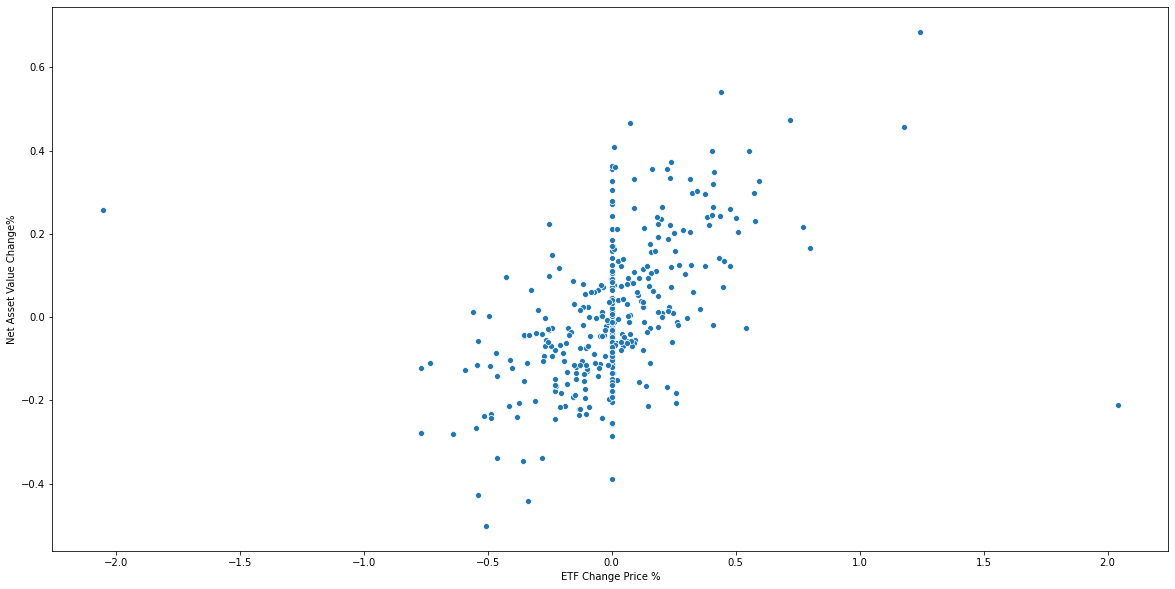

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
17  2020-03-19     UNH    23.076923         76.923077          
12  2020-03-19     PFE    30.434783         69.565217          
2   2020-03-19     MRK    27.500000         72.500000          
15  2020-03-19     ABT    24.390244         75.609756          
6   2020-03-19     GILD   16.666667         83.333333          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
17  44.791667         55.208333         187            91         96         
12  46.666667         53.333333         91             46         45         
2   40.000000         60.000000         90             40         50         
15  60.714286         39.285714         69             41         28         
6   43.750000         56.250000         68             36         32

ETF Name =FHLC
Date =2020-03-19 00:00:00
Sell Positions Probability
T+1    0.75
T+2    0.50
T+3    0.75
T+4    0.00
T+5    0.50
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-19 11:15:00  0.181232                 0.292722        No Trend     
2020-03-19 12:22:00  0.083464                 0.228932        Weak Trend   
2020-03-19 13:37:00  0.126167                 0.183147        No Trend     
Total Return        NaN                      NaN              NaN          

                    AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-19 11:15:00  NaN            111.0               0.0             
2020-03-19 12:22:00  NaN            111.0               0.0             
2020-03-19 13:37:00  NaN            111.0               0.0             
Total Return         NaN           NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-03-19 11:15:00  0.0            111.0            111.0                  
2020-03-19 12:22:00  0.0            0.0              111.0                  
2020-03-19 13:37:00  0.0            0.0              111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-03-19 11:15:00  111.0            0.0           -0.525789  0.000000   
2020-03-19 12:22:00  111.0           -111.0         -0.048974 -0.406881   
2020-03-19 13:37:00  111.0            111.0          0.100376  0.100276   
Total Return        NaN              NaN            -0.474386 -0.306606   

                          T+3       T+4       T+5  
2020-03-19 11:15:00  0.000000  0.138434 -0.075154  
2020-03-19 12:22:00 -0.228871  0.057190  0.019942  
2020-03-19 13:37:00 -0.137741  0.155486  0.000000  
Total Return        -0.366612  0.351110 -0.055212

******************
Buy Positions Probability
T+1    0.428571
T+2    0.142857
T+3    0.714286
T+4    0.285714
T+5    0.571429
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-19 11:16:00  0.167126                -0.193745        No Trend     
2020-03-19 12:02:00  0.167647                -0.305754        Weak Trend   
2020-03-19 12:13:00  0.058000                -0.201333        Weak Trend   
2020-03-19 12:59:00  0.149871                -0.255469        Weak Trend   
2020-03-19 13:17:00  0.155303                -0.181583        No Trend     
2020-03-19 15:11:00  0.140928                -0.194993        Weak Trend   
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-19 11:16:00  NaN               111.0               0.0             
2020-03-19 12:02:00  Downtrend        -111.0              -111.0           
2020-03-19 12:13:00  Downtrend        -111.0               0.0             
2020-03-19 12:59:00  NaN              -111.0               0.0             
2020-03-19 13:17:00  NaN              -111.0               0.0             
2020-03-19 15:11:00  Strong Downtrend -111.0              -111.0           
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-03-19 11:16:00  0.0            0.0             -111.0                  
2020-03-19 12:02:00 -111.0         -111.0           -111.0                  
2020-03-19 12:13:00  0.0            0.0             -111.0                  
2020-03-19 12:59:00  0.0            0.0             -111.0                  
2020-03-19 13:17:00  0.0            0.0             -111.0                  
2020-03-19 15:11:00 -111.0          0.0             -111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-03-19 11:16:00  0.0              0.0            0.000000  0.000000   
2020-03-19 12:02:00 -111.0           -111.0          0.030687  0.000000   
2020-03-19 12:13:00 -111.0            111.0          0.000000  0.000000   
2020-03-19 12:59:00 -111.0            0.0            0.335943  0.000000   
2020-03-19 13:17:00 -111.0            0.0           -0.274956 -0.322805   
2020-03-19 15:11:00  0.0             -111.0         -0.035024  0.278270   
Total Return        NaN              NaN             0.056651 -0.044536   

                          T+3       T+4       T+5  
2020-03-19 11:16:00  0.138434 -0.075154  0.590868  
2020-03-19 12:02:00  0.017351  0.000000  0.228158  
2020-03-19 12:13:00 -0.105839 -0.241649 -0.010024  
2020-03-19 12:59:00  0.000000 -0.334819  0.000000  
2020-03-19 13:17:00  0.497333  0.326545  0.037788  
2020-03-19 15:11:00  0.221746  0.279023 -0.161526  
Total Return         0.769025 -0.046054  0.685264

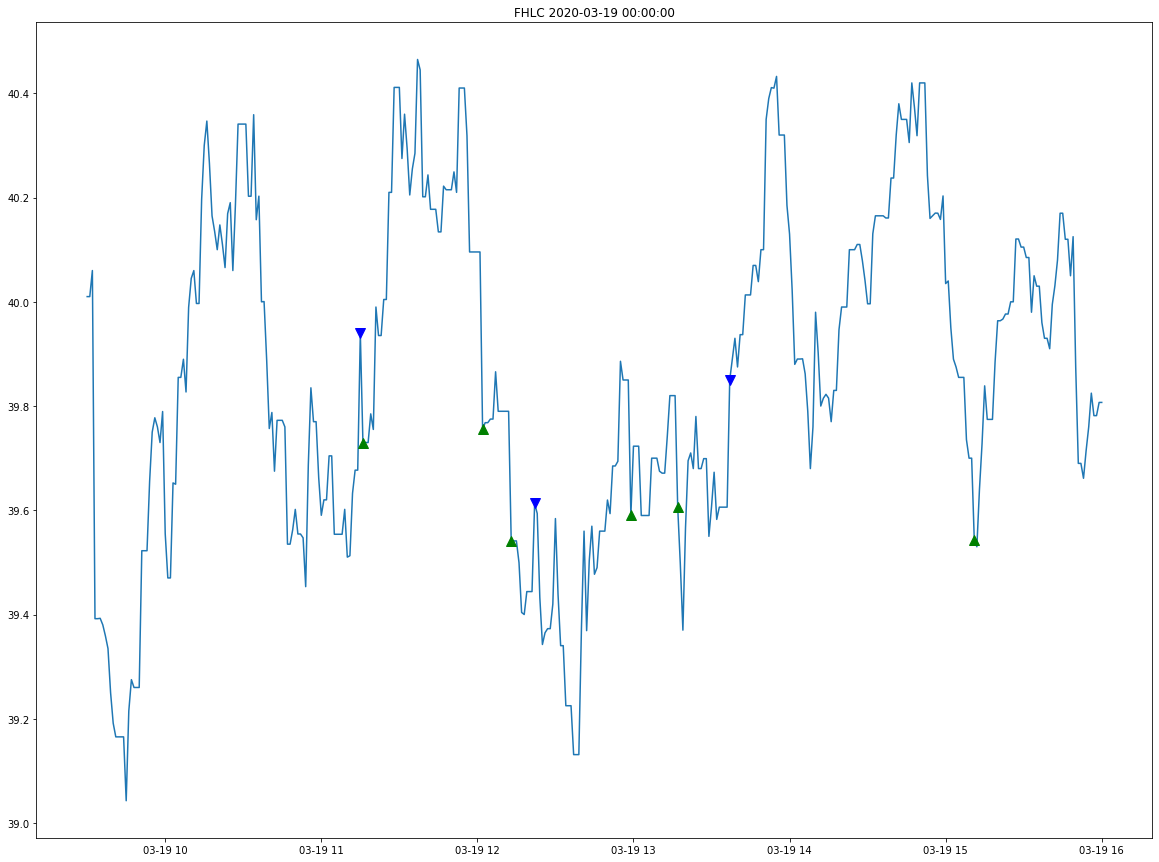

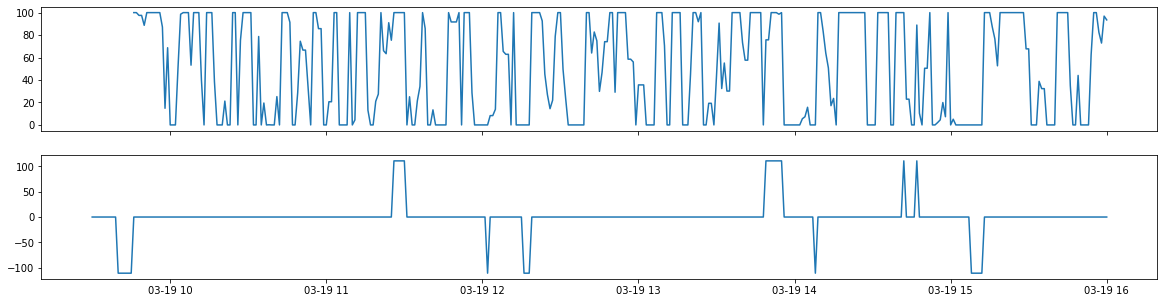

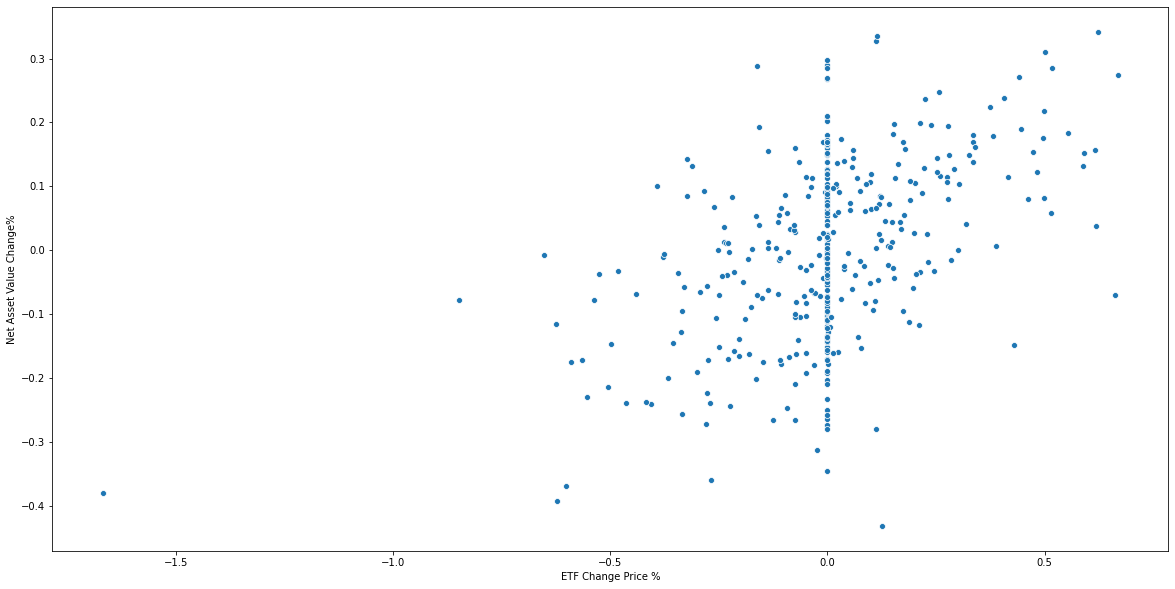

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
16  2020-03-20     UNH    24.390244         75.609756          
2   2020-03-20     MRK    24.489796         75.510204          
11  2020-03-20     PFE    27.027027         72.972973          
3   2020-03-20     TMO    27.586207         72.413793          
12  2020-03-20     MDT    13.793103         86.206897          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
16  45.070423         54.929577         153            82         71         
2   43.396226         56.603774         102            49         53         
11  58.139535         41.860465         80             37         43         
3   50.000000         50.000000         69             29         40         
12  19.444444         80.555556         65             29         36

ETF Name =FHLC
Date =2020-03-20 00:00:00
Sell Positions Probability
T+1    0.625
T+2    0.375
T+3    0.750
T+4    0.000
T+5    0.375
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-20 09:56:00  0.226101                 0.247935        No Trend     
2020-03-20 10:50:00  0.124507                 0.233810        Weak Trend   
2020-03-20 10:54:00  0.136344                 0.166440        Weak Trend   
2020-03-20 11:10:00  0.143333                 0.214771        No Trend     
2020-03-20 11:45:00  0.111971                 0.135864        No Trend     
2020-03-20 11:50:00  0.138381                 0.199082        No Trend     
2020-03-20 13:03:00  0.136977                 0.234179        No Trend     
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-20 09:56:00  Strong Uptrend    111.0               0.0             
2020-03-20 10:50:00  NaN               111.0               0.0             
2020-03-20 10:54:00  NaN               111.0               0.0             
2020-03-20 11:10:00  Strong Downtrend  111.0               0.0             
2020-03-20 11:45:00  NaN               111.0               0.0             
2020-03-20 11:50:00  NaN               111.0               0.0             
2020-03-20 13:03:00  NaN               111.0               0.0             
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-03-20 09:56:00  0.0            0.0              111.0                  
2020-03-20 10:50:00  0.0            0.0              111.0                  
2020-03-20 10:54:00  0.0            0.0              111.0                  
2020-03-20 11:10:00  0.0            0.0              111.0                  
2020-03-20 11:45:00  0.0            0.0              111.0                  
2020-03-20 11:50:00  0.0            0.0              111.0                  
2020-03-20 13:03:00  0.0            0.0              111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-03-20 09:56:00  111.0            0.0           -0.139170  0.000000   
2020-03-20 10:50:00  0.0              0.0            0.098342  0.011939   
2020-03-20 10:54:00  111.0            0.0           -0.398935  0.251312   
2020-03-20 11:10:00  111.0           -111.0         -0.263598  0.064166   
2020-03-20 11:45:00  0.0              0.0           -0.405885  0.102776   
2020-03-20 11:50:00  111.0            111.0          0.000000 -0.349770   
2020-03-20 13:03:00  111.0            0.0            0.000000 -0.208647   
Total Return        NaN              NaN            -1.109246 -0.128223   

                          T+3       T+4       T+5  
2020-03-20 09:56:00  0.000000  0.101356  0.145551  
2020-03-20 10:50:00 -0.010445  0.407650 -0.398935  
2020-03-20 10:54:00 -0.247209  0.073737 -0.198807  
2020-03-20 11:10:00 -0.300000  0.096289 -0.071145  
2020-03-20 11:45:00  0.110304  0.000000  0.645084  
2020-03-20 11:50:00 -0.212879  0.000000  0.085714  
2020-03-20 13:03:00 -0.137773  0.048542  0.000000  
Total Return        -0.798002  0.727574  0.207463

******************
Buy Positions Probability
T+1    0.6
T+2    0.6
T+3    0.4
T+4    0.6
T+5    0.6
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-20 11:07:00  0.099012                -0.129175        No Trend     
2020-03-20 13:37:00  0.107412                -0.135043        No Trend     
2020-03-20 14:57:00  0.080370                -0.158047        Weak Trend   
2020-03-20 15:39:00  0.084008                -0.125283        Weak Trend   
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-20 11:07:00  Strong Downtrend -111.0               0.0             
2020-03-20 13:37:00  Strong Downtrend -111.0              -111.0           
2020-03-20 14:57:00  NaN              -111.0              -111.0           
2020-03-20 15:39:00  NaN              -111.0               0.0             
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-03-20 11:07:00  0.0           -111.0           -111.0                  
2020-03-20 13:37:00 -111.0         -111.0           -111.0                  
2020-03-20 14:57:00 -111.0          0.0             -111.0                  
2020-03-20 15:39:00  0.0            0.0             -111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-03-20 11:07:00 -111.0           -111.0          0.000000  0.000000   
2020-03-20 13:37:00 -111.0            0.0            0.273252  0.000000   
2020-03-20 14:57:00 -111.0            0.0            0.092033  0.152896   
2020-03-20 15:39:00 -111.0            0.0            0.000000  0.010283   
Total Return        NaN              NaN             0.365285  0.163179   

                          T+3       T+4       T+5  
2020-03-20 11:07:00  0.640301 -0.263598  0.064166  
2020-03-20 13:37:00 -0.003838  0.000000  0.000000  
2020-03-20 14:57:00 -0.031215  0.114664  0.248984  
2020-03-20 15:39:00  0.000000  0.181946 -0.153555  
Total Return         0.605249  0.033012  0.159596

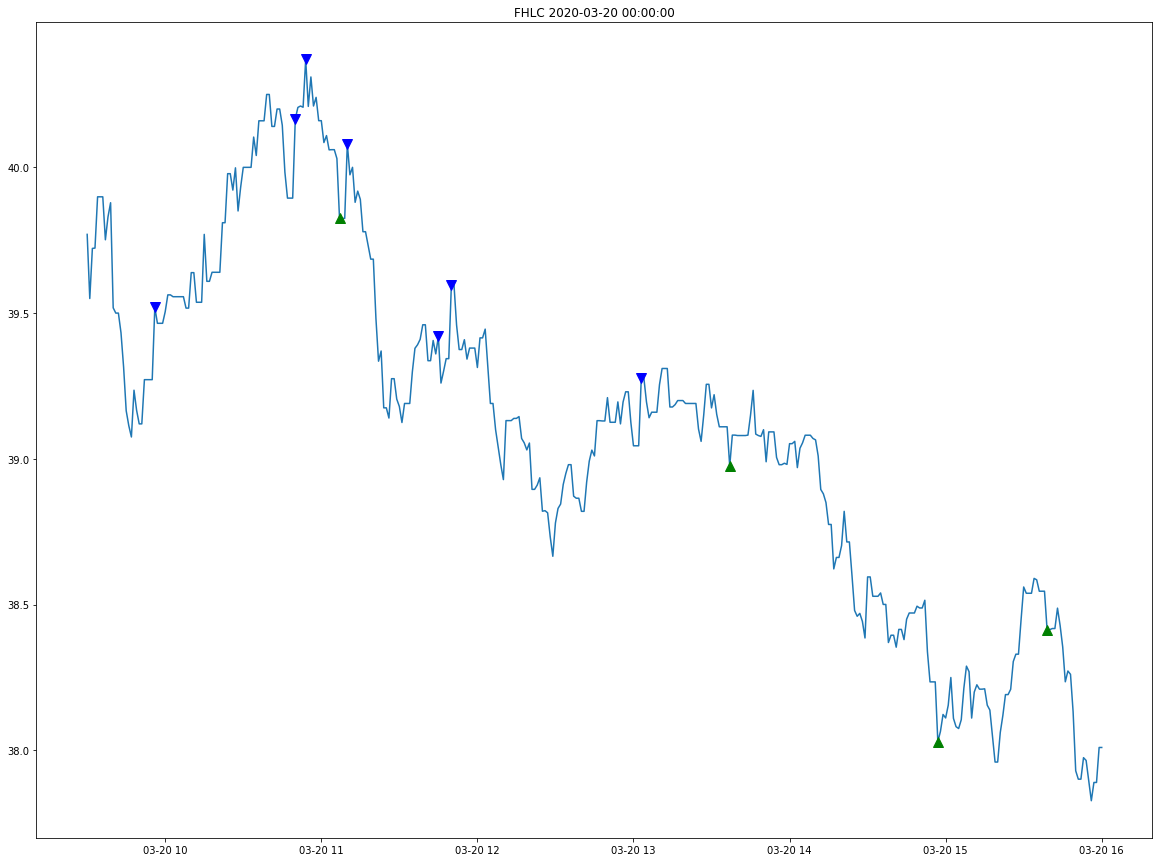

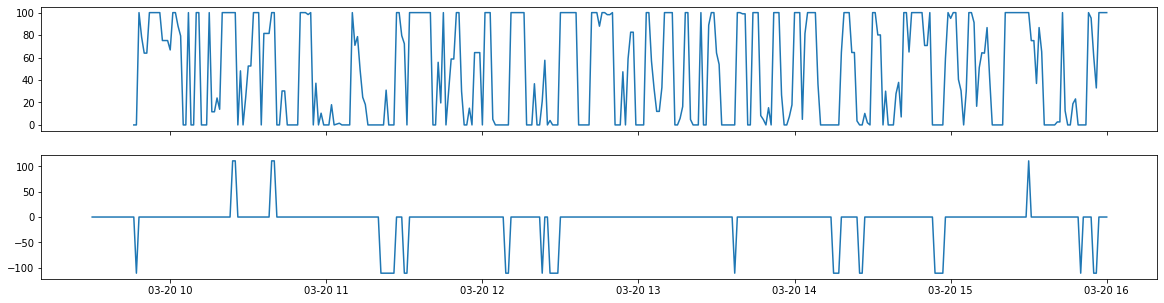

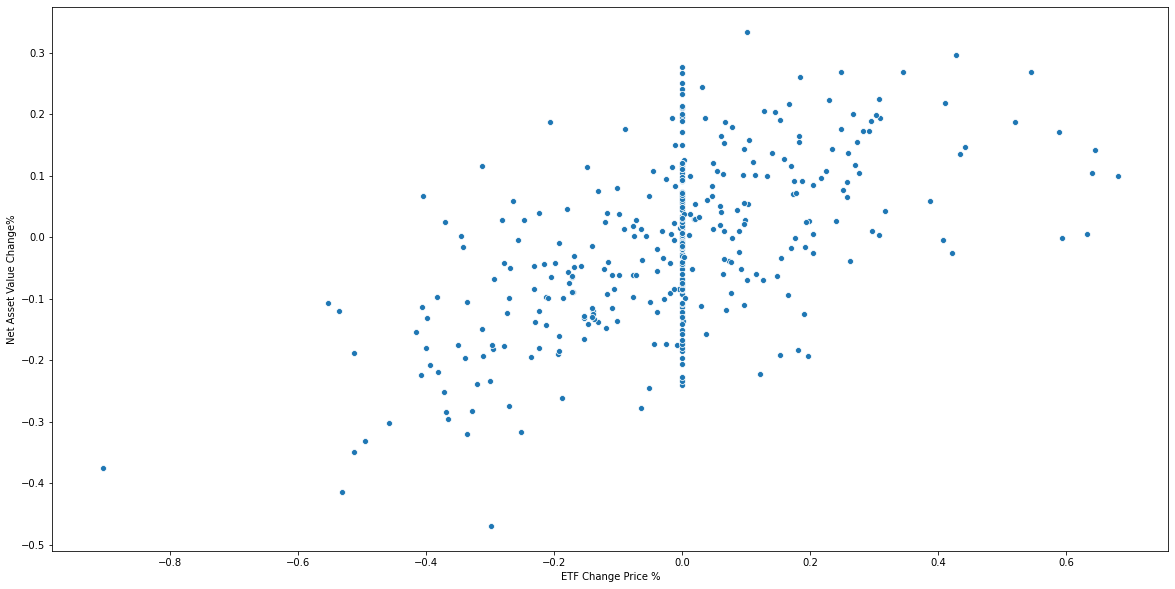

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
15  2020-03-23     UNH    19.230769         80.769231          
8   2020-03-23     PFE    13.559322         86.440678          
1   2020-03-23     MRK    20.338983         79.661017          
25  2020-03-23     AMGN   17.948718         82.051282          
22  2020-03-23     LLY    26.315789         73.684211          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
15  47.435897         52.564103         156            78         78         
8   53.448276         46.551724         117            59         58         
1   56.603774         43.396226         112            59         53         
25  44.117647         55.882353         73             39         34         
22  46.666667         53.333333         68             38         30

ETF Name =FHLC
Date =2020-03-23 00:00:00
Sell Positions Probability
T+1    0.500000
T+2    0.333333
T+3    0.833333
T+4    0.666667
T+5    0.166667
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $     ADX Trend  \
2020-03-23 10:43:00  0.129836                 0.288962        No Trend       
2020-03-23 12:43:00  0.124862                 0.146704        No Trend       
2020-03-23 13:49:00  0.128149                 0.200433        Strong Trend   
2020-03-23 14:06:00  0.139554                 0.167247        Weak Trend     
2020-03-23 14:29:00  0.190109                 0.246201        No Trend       
Total Return        NaN                      NaN              NaN            

                     AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-23 10:43:00  Uptrend         111.0               0.0             
2020-03-23 12:43:00  Strong Uptrend  111.0               0.0             
2020-03-23 13:49:00  NaN             111.0               0.0             
2020-03-23 14:06:00  NaN             111.0               0.0             
2020-03-23 14:29:00  Uptrend         111.0               0.0             
Total Return         NaN            NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-03-23 10:43:00  0.0            0.0              111.0                  
2020-03-23 12:43:00  0.0            111.0            111.0                  
2020-03-23 13:49:00  0.0            0.0              111.0                  
2020-03-23 14:06:00  0.0            0.0              111.0                  
2020-03-23 14:29:00  0.0            0.0              111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-03-23 10:43:00  111.0            0.0           -0.109493  0.064807   
2020-03-23 12:43:00  111.0            0.0           -0.027086  0.142238   
2020-03-23 13:49:00  111.0           -111.0          0.000000  0.000000   
2020-03-23 14:06:00  111.0           -111.0          0.000000  0.000000   
2020-03-23 14:29:00  0.0              0.0            0.000000 -0.259563   
Total Return        NaN              NaN            -0.136578 -0.052518   

                          T+3       T+4       T+5  
2020-03-23 10:43:00 -0.327825  0.008022  0.000000  
2020-03-23 12:43:00 -0.196145  0.305367  0.249577  
2020-03-23 13:49:00  0.000000 -0.403583 -0.121811  
2020-03-23 14:06:00 -0.776667 -0.086665  0.000000  
2020-03-23 14:29:00 -0.119162 -0.223523  0.000000  
Total Return        -1.419799 -0.400382  0.127766

******************
Buy Positions Probability
T+1    0.500000
T+2    0.333333
T+3    0.083333
T+4    0.583333
T+5    0.666667
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-23 09:51:00  0.078182                -0.099796        No Trend     
2020-03-23 10:01:00  0.122903                -0.144820        Weak Trend   
2020-03-23 10:19:00  0.122913                -0.167963        No Trend     
2020-03-23 11:00:00  0.127611                -0.167278        Weak Trend   
2020-03-23 11:35:00  0.103277                -0.172554        Weak Trend   
2020-03-23 12:06:00  0.113428                -0.186411        No Trend     
2020-03-23 12:10:00  0.102443                -0.150445        No Trend     
2020-03-23 13:32:00  0.120706                -0.242300        Weak Trend   
2020-03-23 14:01:00  0.122208                -0.155817        Weak Trend   
2020-03-23 14:09:00  0.131392                -0.159335        Weak Trend   
2020-03-23 15:51:00  0.111390                -0.193714        Weak Trend   
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-23 09:51:00  Strong Uptrend    111.0               0.0             
2020-03-23 10:01:00  Strong Uptrend   -111.0               0.0             
2020-03-23 10:19:00  NaN              -111.0               0.0             
2020-03-23 11:00:00  Downtrend        -111.0              -111.0           
2020-03-23 11:35:00  Strong Downtrend -111.0              -111.0           
2020-03-23 12:06:00  Uptrend          -111.0               0.0             
2020-03-23 12:10:00  Downtrend        -111.0               0.0             
2020-03-23 13:32:00  Strong Downtrend -111.0              -111.0           
2020-03-23 14:01:00  Downtrend        -111.0               0.0             
2020-03-23 14:09:00  NaN              -111.0               0.0             
2020-03-23 15:51:00  Strong Uptrend    111.0               0.0             
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-03-23 09:51:00  0.0            0.0              0.0                    
2020-03-23 10:01:00  0.0            0.0             -111.0                  
2020-03-23 10:19:00  0.0            0.0             -111.0                  
2020-03-23 11:00:00 -111.0          0.0             -111.0                  
2020-03-23 11:35:00 -111.0          0.0             -111.0                  
2020-03-23 12:06:00  0.0            0.0             -111.0                  
2020-03-23 12:10:00  0.0            0.0             -111.0                  
2020-03-23 13:32:00 -111.0         -111.0           -111.0                  
2020-03-23 14:01:00  0.0            0.0              0.0                    
2020-03-23 14:09:00  0.0            0.0              0.0                    
2020-03-23 15:51:00  0.0            0.0              111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-03-23 09:51:00  0.0              111.0          0.430837 -0.166971   
2020-03-23 10:01:00 -111.0            0.0           -0.063753 -0.033718   
2020-03-23 10:19:00 -111.0            111.0          0.000000 -0.103258   
2020-03-23 11:00:00  0.0             -111.0          0.067870 -0.093869   
2020-03-23 11:35:00  0.0              0.0           -0.082673  0.000000   
2020-03-23 12:06:00  0.0              0.0            0.115526  0.255967   
2020-03-23 12:10:00  0.0              0.0            0.232683  0.091085   
2020-03-23 13:32:00 -111.0            0.0            0.000000  0.000000   
2020-03-23 14:01:00 -111.0           -111.0         -0.248004  0.000000   
2020-03-23 14:09:00 -111.0           -111.0         -0.086665  0.000000   
2020-03-23 15:51:00  111.0            0.0            0.768007  0.056441   
Total Return        NaN              NaN             1.133828  0.005677   

                          T+3       T+4       T+5  
2020-03-23 09

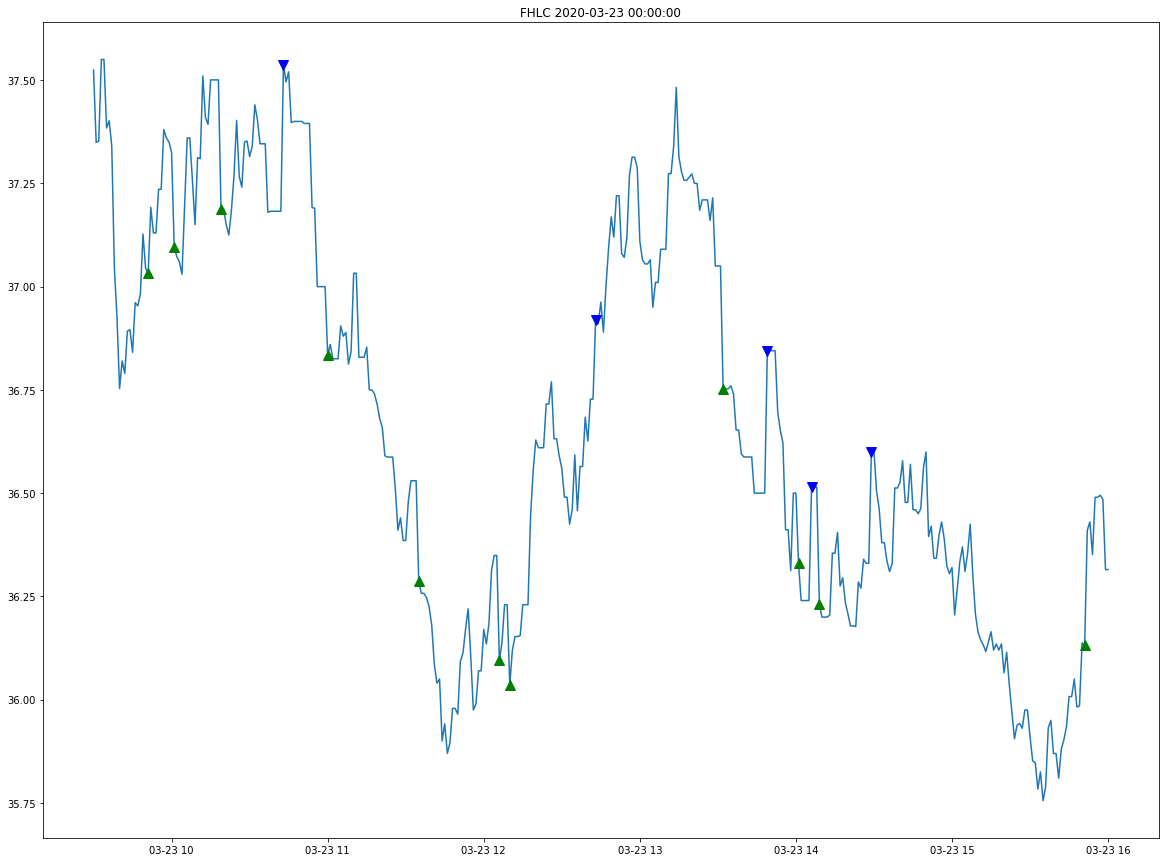

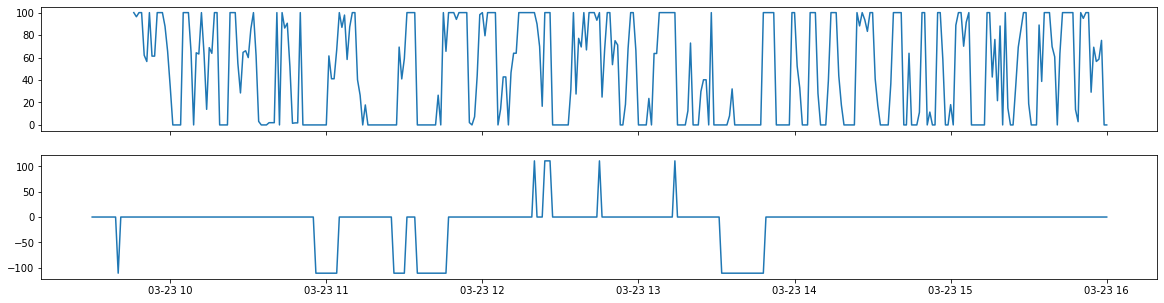

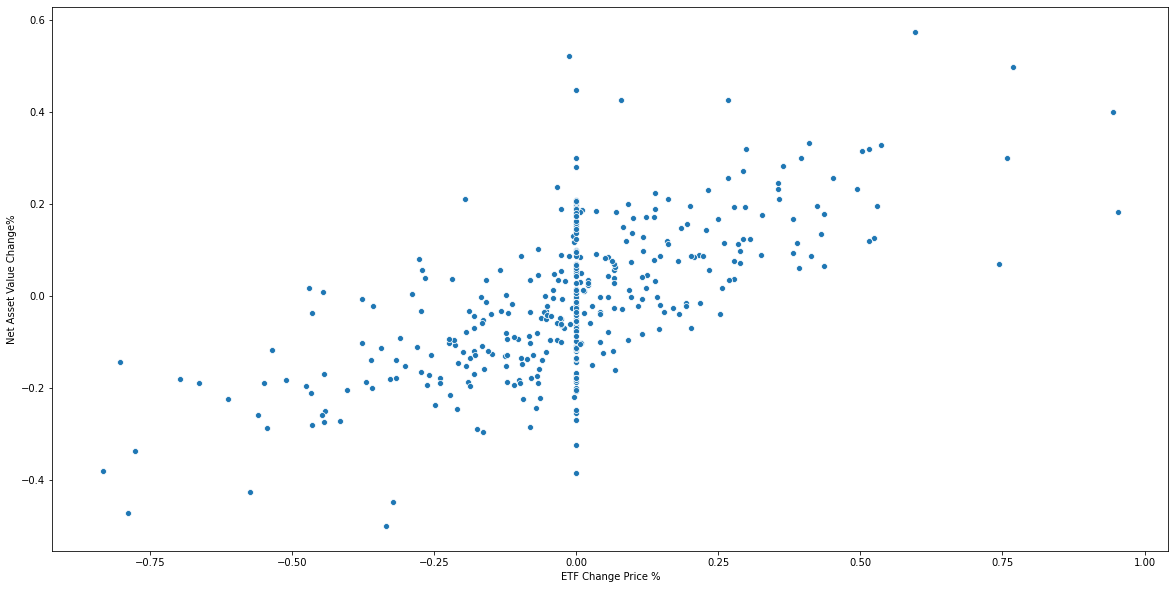

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
16  2020-03-24     UNH    31.481481         68.518519          
2   2020-03-24     MRK    25.000000         75.000000          
9   2020-03-24     PFE    33.333333         66.666667          
24  2020-03-24     LLY    20.689655         79.310345          
28  2020-03-24     TMO    23.076923         76.923077          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
16  44.615385         55.384615         119            54         65         
2   40.816327         59.183673         85             36         49         
9   44.736842         55.263158         74             36         38         
24  48.387097         51.612903         60             29         31         
28  42.424242         57.575758         59             26         33

ETF Name =FHLC
Date =2020-03-24 00:00:00
Sell Positions Probability
T+1    0.375
T+2    0.750
T+3    0.250
T+4    0.375
T+5    0.125
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-24 10:04:00  0.115703                 0.165319        Weak Trend   
2020-03-24 10:21:00  0.082242                 0.111103        No Trend     
2020-03-24 13:55:00  0.087119                 0.111858        Weak Trend   
2020-03-24 14:19:00  0.092025                 0.151818        Weak Trend   
2020-03-24 14:37:00  0.080595                 0.139936        No Trend     
2020-03-24 14:51:00  0.066403                 0.102881        No Trend     
2020-03-24 15:00:00  0.098915                 0.268772        Weak Trend   
Total Return        NaN                      NaN              NaN          

                     AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-24 10:04:00  Downtrend       111.0               0.0             
2020-03-24 10:21:00  NaN             111.0               0.0             
2020-03-24 13:55:00  Downtrend      -111.0               0.0             
2020-03-24 14:19:00  Uptrend         111.0               0.0             
2020-03-24 14:37:00  Strong Uptrend  111.0               0.0             
2020-03-24 14:51:00  NaN             111.0               0.0             
2020-03-24 15:00:00  Strong Uptrend  111.0               111.0           
Total Return         NaN            NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-03-24 10:04:00  0.0            0.0              111.0                  
2020-03-24 10:21:00  0.0            0.0              0.0                    
2020-03-24 13:55:00  0.0            0.0              111.0                  
2020-03-24 14:19:00  0.0            111.0            111.0                  
2020-03-24 14:37:00  0.0            111.0            111.0                  
2020-03-24 14:51:00  0.0            0.0              111.0                  
2020-03-24 15:00:00  111.0          111.0            111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-03-24 10:04:00  0.0              0.0            0.093690 -0.012550   
2020-03-24 10:21:00  111.0            0.0            0.104466 -0.104357   
2020-03-24 13:55:00  0.0              0.0            0.140839 -0.260428   
2020-03-24 14:19:00  111.0            0.0           -0.116251 -0.180346   
2020-03-24 14:37:00  111.0            111.0          0.000000 -0.052144   
2020-03-24 14:51:00  111.0           -111.0         -0.052165  0.234864   
2020-03-24 15:00:00  111.0            0.0           -0.100465  0.000000   
Total Return        NaN              NaN             0.070115 -0.374961   

                          T+3       T+4       T+5  
2020-03-24 10:04:00  0.110088 -0.428637  0.062959  
2020-03-24 10:21:00  0.156699  0.000000  0.234681  
2020-03-24 13:55:00  0.058547  0.176321 -0.142503  
2020-03-24 14:19:00  0.126050  0.000000  0.000000  
2020-03-24 14:37:00 -0.065215 -0.088228  0.000000  
2020-03-24 14:51:00  0.000000  0.052070  0.000000  
2020-03-24 15:00:00 -0.002844  0.051706  0.206718  
Total Return         0.383326 -0.236768  0.361855

******************
Buy Positions Probability
T+1    0.00
T+2    0.50
T+3    0.50
T+4    1.00
T+5    0.25
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-24 10:51:00  0.110818                -0.143074        No Trend     
2020-03-24 12:53:00  0.112897                -0.134424        Weak Trend   
2020-03-24 13:52:00  0.070397                -0.094132        Weak Trend   
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-24 10:51:00  Strong Downtrend -111.0               0.0             
2020-03-24 12:53:00  Strong Downtrend -111.0               0.0             
2020-03-24 13:52:00  NaN              -111.0              -111.0           
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-03-24 10:51:00  0.0           -111.0           -111.0                  
2020-03-24 12:53:00  0.0            0.0             -111.0                  
2020-03-24 13:52:00 -111.0         -111.0           -111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-03-24 10:51:00 -111.0           -111.0          0.000000  0.000000   
2020-03-24 12:53:00 -111.0           -111.0          0.000000  0.241812   
2020-03-24 13:52:00 -111.0           -111.0         -0.039252  0.000000   
Total Return        NaN              NaN            -0.039252  0.241812   

                          T+3       T+4       T+5  
2020-03-24 10:51:00  0.000000  0.100209  0.200742  
2020-03-24 12:53:00  0.000000  0.154928 -0.360639  
2020-03-24 13:52:00  0.277618  0.140839 -0.260428  
Total Return         0.277618  0.395977 -0.420325

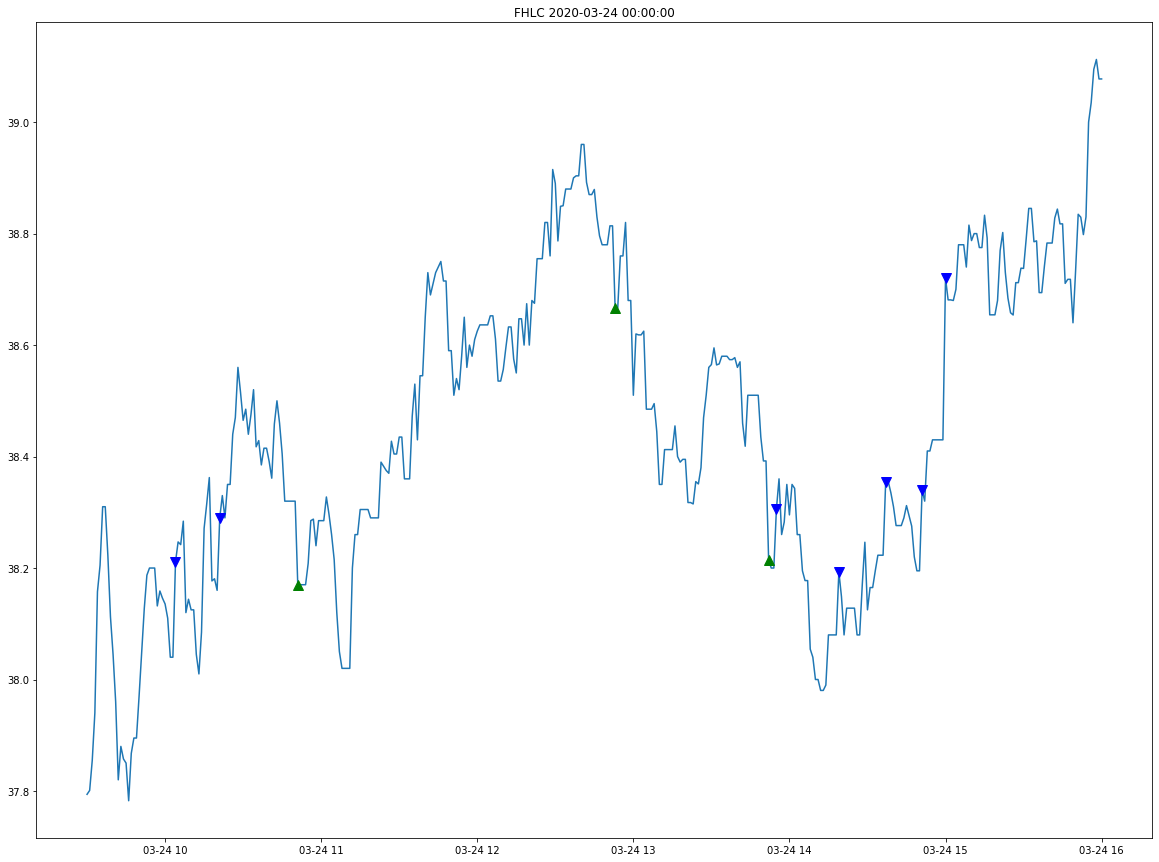

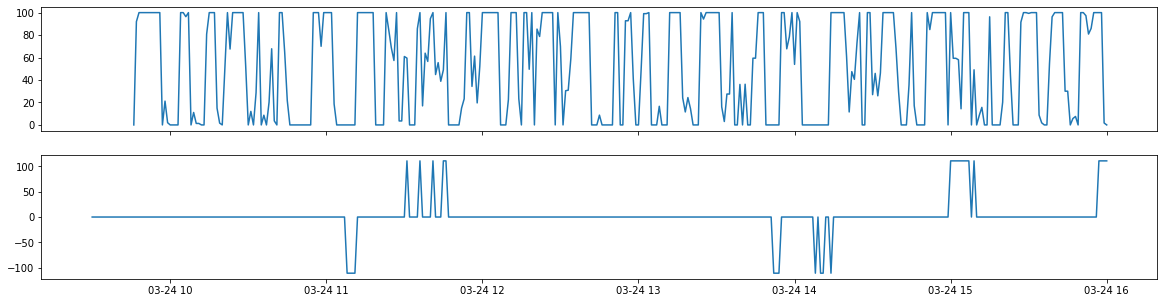

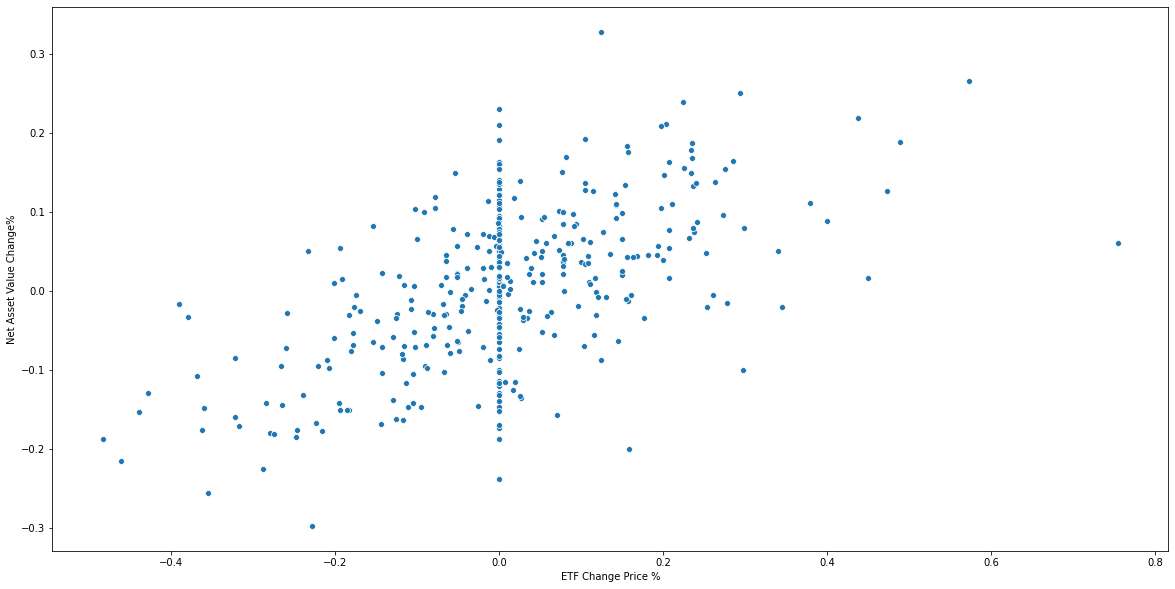

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
14  2020-03-25     UNH    20.833333         79.166667          
2   2020-03-25     MRK    18.421053         81.578947          
9   2020-03-25     PFE    16.666667         83.333333          
23  2020-03-25     AMGN   12.000000         88.000000          
3   2020-03-25     TMO    24.000000         76.000000          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
14  44.554455         55.445545         173            72         101        
2   51.162791         48.837209         81             38         43         
9   44.444444         55.555556         78             42         36         
23  40.625000         59.375000         57             25         32         
3   46.428571         53.571429         53             25         28

ETF Name =FHLC
Date =2020-03-25 00:00:00
Sell Positions Probability
T+1    0.6
T+2    0.2
T+3    0.3
T+4    0.6
T+5    0.3
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-25 10:02:00  0.151291                 0.182287        Weak Trend   
2020-03-25 10:07:00  0.101169                 0.185202        Weak Trend   
2020-03-25 10:27:00  0.114839                 0.173627        Weak Trend   
2020-03-25 11:38:00  0.096118                 0.134221        No Trend     
2020-03-25 11:50:00  0.090947                 0.113405        No Trend     
2020-03-25 12:17:00  0.077567                 0.122634        Weak Trend   
2020-03-25 12:39:00  0.093587                 0.197632        Weak Trend   
2020-03-25 14:14:00  0.086077                 0.116742        Weak Trend   
2020-03-25 15:16:00  0.061225                 0.086732        Weak Trend   
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-25 10:02:00  Downtrend         111.0               0.0             
2020-03-25 10:07:00  Strong Downtrend  111.0               0.0             
2020-03-25 10:27:00  NaN              -111.0               0.0             
2020-03-25 11:38:00  Downtrend        -111.0               0.0             
2020-03-25 11:50:00  Downtrend         111.0               0.0             
2020-03-25 12:17:00  NaN               111.0               111.0           
2020-03-25 12:39:00  Strong Uptrend    111.0               0.0             
2020-03-25 14:14:00  NaN               111.0               0.0             
2020-03-25 15:16:00  Downtrend         111.0               0.0             
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-03-25 10:02:00  0.0            0.0              111.0                  
2020-03-25 10:07:00  0.0            0.0              111.0                  
2020-03-25 10:27:00  0.0            0.0              0.0                    
2020-03-25 11:38:00  0.0            0.0              111.0                  
2020-03-25 11:50:00  0.0            0.0              111.0                  
2020-03-25 12:17:00  111.0          111.0            111.0                  
2020-03-25 12:39:00  0.0            111.0            111.0                  
2020-03-25 14:14:00  0.0            0.0              111.0                  
2020-03-25 15:16:00  0.0            0.0              111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-03-25 10:02:00  0.0             -111.0          0.000000 -0.257344   
2020-03-25 10:07:00  0.0             -111.0         -0.003452  0.080673   
2020-03-25 10:27:00  0.0              0.0            0.000000  0.000000   
2020-03-25 11:38:00  0.0              0.0            0.112510  0.000000   
2020-03-25 11:50:00  0.0             -111.0         -0.017050  0.086027   
2020-03-25 12:17:00  111.0            0.0           -0.125565  0.046392   
2020-03-25 12:39:00  111.0            111.0         -0.091882  0.000000   
2020-03-25 14:14:00  0.0              0.0            0.198193  0.002595   
2020-03-25 15:16:00  0.0              0.0           -0.135285  0.000000   
Total Return        NaN              NaN            -0.062532 -0.041657   

                          T+3       T+4       T+5  
2020-03-25 10:02:00 -0.226765  0.000000  0.383207  
2020-03-25 10:07:00 -0.128257 -0.281402  0.089790  
2020-03-25 10:27:00  0.396419 -0.085594 -0.295374  
2020-03-25 11:38:00  0.000000 -0.175876 -0.016792  
2020-03-25 11:50:00  0.000000 -0.111129 -0.076375  
2020-03-25 12:17:00  0.106941  0.010042  0.256433  
2020-03-25 12:39:00  0.067044  0.020672  0.004233  
2020-03-25 14:14:00 -0.110820 -0.040197  0.247463  
2020-03-25 15:16:00  0.160099  0.027296  0.120218  
Total Return         0.264661 -0.636187  0.712803

******************
Buy Positions Probability
T+1    0.428571
T+2    0.571429
T+3    0.571429
T+4    0.714286
T+5    0.142857
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-25 09:31:00  0.465348                -0.544076        0            
2020-03-25 10:26:00  0.119882                -0.158701        Weak Trend   
2020-03-25 11:42:00  0.087855                -0.108035        No Trend     
2020-03-25 12:49:00  0.095118                -0.138088        Weak Trend   
2020-03-25 14:06:00  0.091473                -0.122414        Weak Trend   
2020-03-25 15:27:00  0.093574                -0.143744        No Trend     
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-25 09:31:00  NaN               0.0                 0.0             
2020-03-25 10:26:00  NaN              -111.0               0.0             
2020-03-25 11:42:00  NaN              -111.0               0.0             
2020-03-25 12:49:00  NaN              -111.0               0.0             
2020-03-25 14:06:00  Strong Downtrend -111.0              -111.0           
2020-03-25 15:27:00  Downtrend        -111.0               0.0             
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-03-25 09:31:00  0.0            0.0              0.0                    
2020-03-25 10:26:00  0.0            0.0             -111.0                  
2020-03-25 11:42:00  0.0            0.0             -111.0                  
2020-03-25 12:49:00  0.0            0.0             -111.0                  
2020-03-25 14:06:00 -111.0         -111.0           -111.0                  
2020-03-25 15:27:00  0.0            0.0             -111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-03-25 09:31:00  0.0              0.0            0.000000  1.404056   
2020-03-25 10:26:00 -111.0            0.0            0.462487  0.000000   
2020-03-25 11:42:00  0.0              0.0           -0.016792 -0.237669   
2020-03-25 12:49:00 -111.0            0.0            0.000000  0.149440   
2020-03-25 14:06:00 -111.0           -111.0         -0.103036 -0.187645   
2020-03-25 15:27:00 -111.0            111.0          0.145389  0.132699   
Total Return        NaN              NaN             0.488048  1.260881   

                          T+3       T+4       T+5  
2020-03-25 09:31:00 -0.020513  0.969430  0.000000  
2020-03-25 10:26:00  0.000000  0.396419 -0.085594  
2020-03-25 11:42:00  0.000000 -0.232241 -0.035665  
2020-03-25 12:49:00  0.216115 -0.215649 -0.410346  
2020-03-25 14:06:00  0.066360  0.182523  0.000000  
2020-03-25 15:27:00  0.070950  0.073983  0.105964  
Total Return         0.332913  1.174465 -0.425641

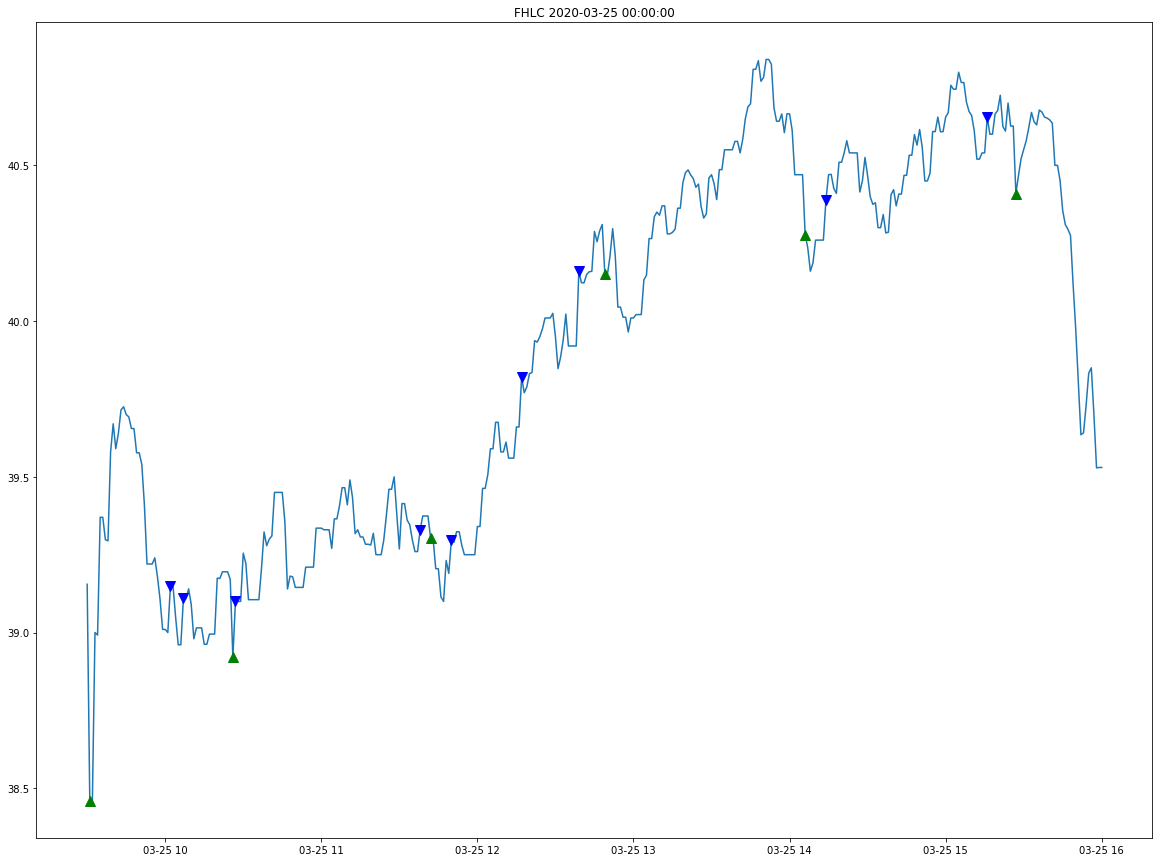

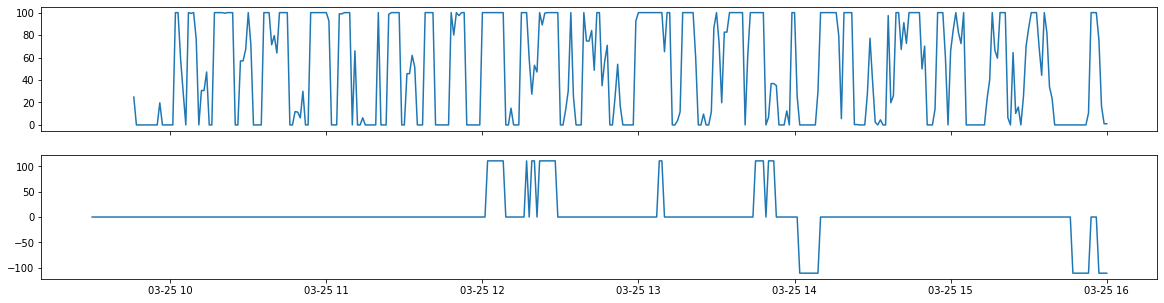

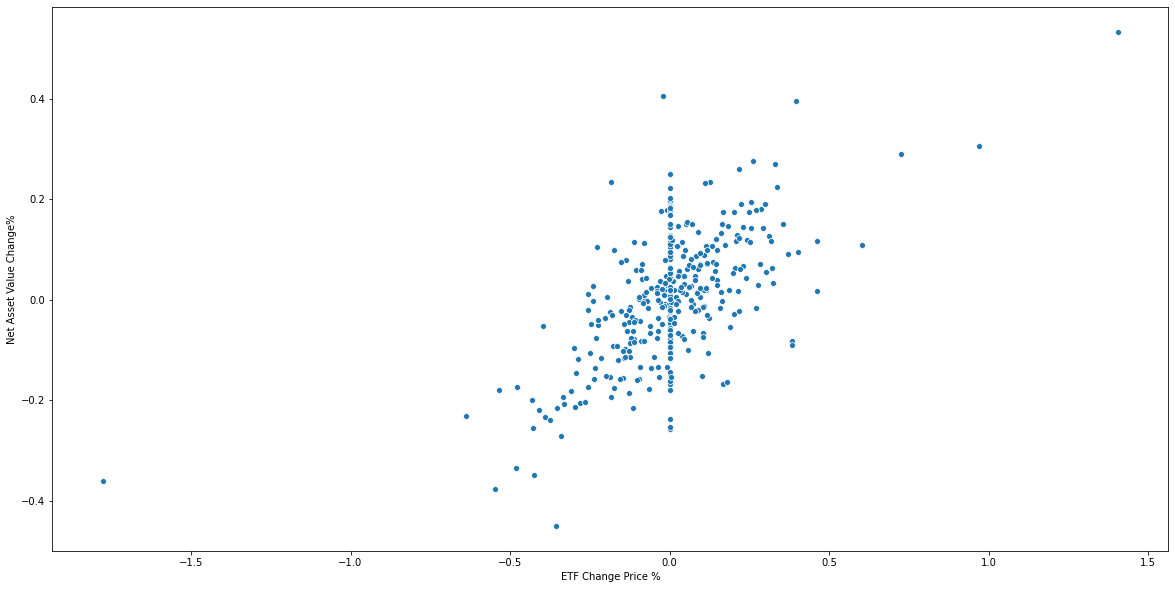

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
17  2020-03-26     UNH    28.571429         71.428571          
2   2020-03-26     MRK    41.025641         58.974359          
11  2020-03-26     PFE    23.333333         76.666667          
12  2020-03-26     MDT    30.000000         70.000000          
27  2020-03-26     TMO    33.333333         66.666667          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
17  56.989247         43.010753         177            84         93         
2   51.111111         48.888889         84             39         45         
11  66.666667         33.333333         60             30         30         
12  53.846154         46.153846         56             30         26         
27  50.000000         50.000000         43             21         22

ETF Name =FHLC
Date =2020-03-26 00:00:00
Sell Positions Probability
T+1    0.250
T+2    0.500
T+3    0.375
T+4    0.500
T+5    0.125
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-26 09:55:00  0.172289                 0.234540        Weak Trend   
2020-03-26 10:10:00  0.117033                 0.143331        Weak Trend   
2020-03-26 10:33:00  0.105147                 0.135105        Weak Trend   
2020-03-26 11:54:00  0.098834                 0.140307        Weak Trend   
2020-03-26 14:32:00  0.075196                 0.110324        Weak Trend   
2020-03-26 15:54:00  0.073705                 0.145362        Weak Trend   
2020-03-26 15:59:00  0.074404                 0.129278        Weak Trend   
Total Return        NaN                      NaN              NaN          

                     AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-26 09:55:00  NaN             111.0               0.0             
2020-03-26 10:10:00  Strong Uptrend  111.0               111.0           
2020-03-26 10:33:00  NaN             111.0               0.0             
2020-03-26 11:54:00  NaN             111.0               0.0             
2020-03-26 14:32:00  Strong Uptrend  111.0               111.0           
2020-03-26 15:54:00  NaN             111.0               111.0           
2020-03-26 15:59:00  Uptrend         111.0               0.0             
Total Return         NaN            NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-03-26 09:55:00  0.0            0.0              111.0                  
2020-03-26 10:10:00  111.0          0.0              111.0                  
2020-03-26 10:33:00  0.0            0.0              111.0                  
2020-03-26 11:54:00  0.0            0.0              111.0                  
2020-03-26 14:32:00  111.0          111.0            111.0                  
2020-03-26 15:54:00  111.0          0.0              111.0                  
2020-03-26 15:59:00  0.0            0.0              0.0                    
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-03-26 09:55:00  111.0            0.0           -0.063958  0.314589   
2020-03-26 10:10:00  111.0            111.0          0.012142 -0.449193   
2020-03-26 10:33:00  111.0            0.0           -0.192911  0.000000   
2020-03-26 11:54:00  111.0            0.0            0.000000 -0.490826   
2020-03-26 14:32:00  111.0            111.0          0.016131  0.062108   
2020-03-26 15:54:00  111.0            111.0          0.317740 -0.165211   
2020-03-26 15:59:00  111.0            0.0            0.000000 NaN         
Total Return        NaN              NaN             0.089145 -0.728533   

                          T+3       T+4       T+5  
2020-03-26 09:55:00  0.000000  0.092085  0.057378  
2020-03-26 10:10:00  0.195122  0.066943 -0.278295  
2020-03-26 10:33:00 -0.471128  0.104382  0.000000  
2020-03-26 11:54:00  0.049807 -0.049782  0.433912  
2020-03-26 14:32:00  0.000000 -0.068084  0.000000  
2020-03-26 15:54:00 -0.020095 -0.535569  0.458814  
2020-03-26 15:59:00 NaN       NaN       NaN        
Total Return        -0.246294 -0.390026  0.671809

******************
Buy Positions Probability
T+1    1.000000
T+2    0.714286
T+3    0.714286
T+4    0.285714
T+5    0.142857
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-26 10:44:00  0.125919                -0.183936        No Trend     
2020-03-26 11:02:00  0.111953                -0.179899        No Trend     
2020-03-26 11:28:00  0.088721                -0.114037        No Trend     
2020-03-26 11:56:00  0.088056                -0.128085        Weak Trend   
2020-03-26 13:32:00  0.071429                -0.112320        Weak Trend   
2020-03-26 15:58:00  0.072178                -0.110155        Weak Trend   
Total Return        NaN                      NaN              NaN          

                    AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-26 10:44:00  Downtrend     -111.0               0.0             
2020-03-26 11:02:00  Downtrend     -111.0               0.0             
2020-03-26 11:28:00  Uptrend       -111.0               0.0             
2020-03-26 11:56:00  NaN           -111.0               0.0             
2020-03-26 13:32:00  NaN           -111.0              -111.0           
2020-03-26 15:58:00  Uptrend        111.0               0.0             
Total Return         NaN           NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-03-26 10:44:00  0.0            0.0              0.0                    
2020-03-26 11:02:00  0.0            0.0             -111.0                  
2020-03-26 11:28:00  0.0            0.0             -111.0                  
2020-03-26 11:56:00  0.0            0.0             -111.0                  
2020-03-26 13:32:00 -111.0         -111.0           -111.0                  
2020-03-26 15:58:00  0.0            0.0             -111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-03-26 10:44:00 -111.0           -111.0          0.494347  0.196863   
2020-03-26 11:02:00 -111.0            111.0          0.255599  0.048561   
2020-03-26 11:28:00  0.0              111.0          0.232440  0.057072   
2020-03-26 11:56:00 -111.0           -111.0          0.049807 -0.049782   
2020-03-26 13:32:00 -111.0           -111.0          0.024378  0.158421   
2020-03-26 15:58:00  0.0             -111.0          0.458814  0.000000   
Total Return        NaN              NaN             1.515386  0.411135   

                          T+3       T+4       T+5  
2020-03-26 10:44:00 -0.530896 -0.065882 -0.144113  
2020-03-26 11:02:00  0.157748 -0.127211 -0.122278  
2020-03-26 11:28:00  0.180505  0.108108  0.023998  
2020-03-26 11:56:00  0.433912 -0.047791 -0.000360  
2020-03-26 13:32:00  0.160603  0.022959  0.000000  
2020-03-26 15:58:00 NaN       NaN       NaN        
Total Return         0.401873 -0.109817 -0.242754

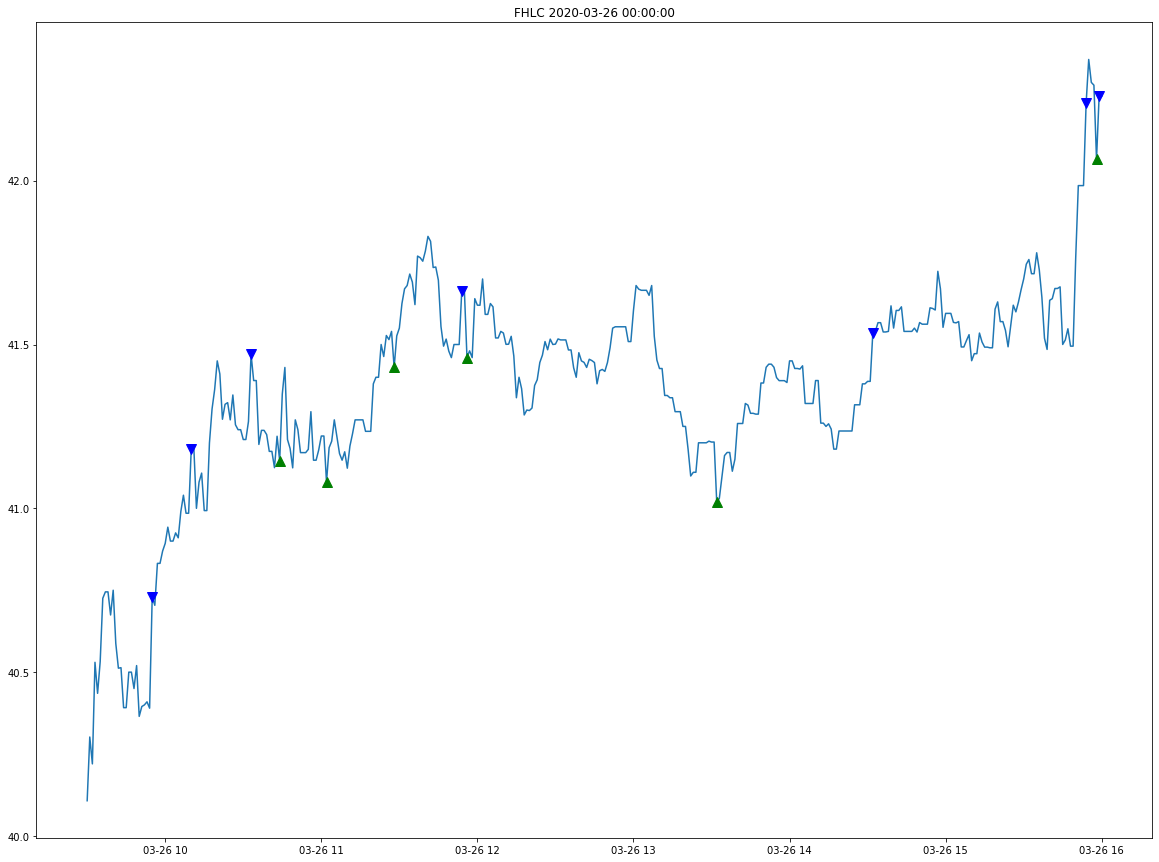

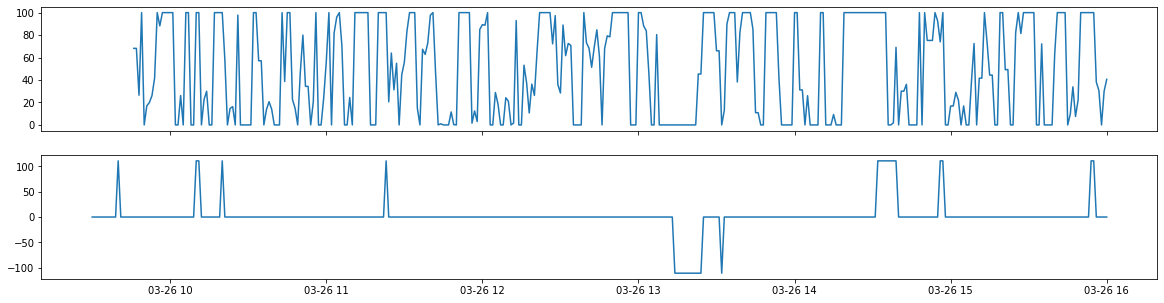

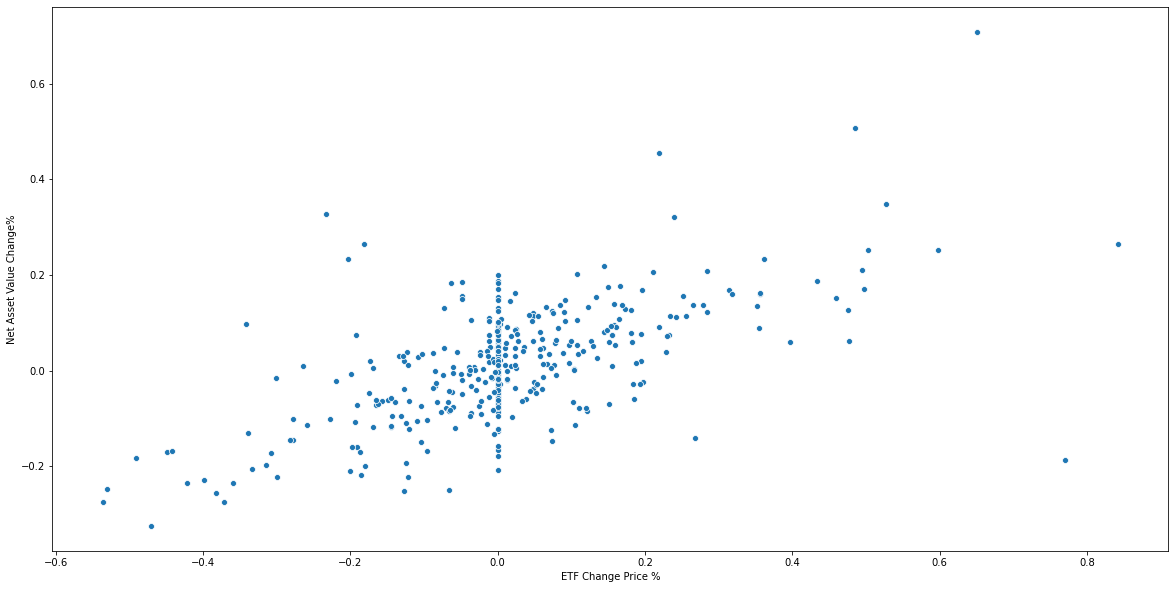

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
16  2020-03-27     UNH    21.621622         78.378378          
2   2020-03-27     MRK    21.276596         78.723404          
10  2020-03-27     PFE    30.769231         69.230769          
1   2020-03-27     ABBV   33.333333         66.666667          
21  2020-03-27     LLY    23.529412         76.470588          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
16  41.666667         58.333333         158            74         84         
2   42.647059         57.352941         115            47         68         
10  34.285714         65.714286         74             39         35         
1   42.307692         57.692308         50             24         26         
21  32.258065         67.741935         48             17         31

ETF Name =FHLC
Date =2020-03-27 00:00:00
Sell Positions Probability
T+1    0.500000
T+2    0.583333
T+3    0.333333
T+4    0.250000
T+5    0.333333
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-27 09:52:00  0.146286                 0.191574        No Trend     
2020-03-27 11:18:00  0.083243                 0.132043        Weak Trend   
2020-03-27 12:05:00  0.085340                 0.124637        Weak Trend   
2020-03-27 12:19:00  0.080267                 0.112203        No Trend     
2020-03-27 12:54:00  0.078364                 0.127673        Weak Trend   
2020-03-27 14:09:00  0.066968                 0.094433        Weak Trend   
2020-03-27 14:12:00  0.061037                 0.092902        Weak Trend   
2020-03-27 14:32:00  0.069587                 0.152530        Weak Trend   
2020-03-27 15:00:00  0.066498                 0.355315        Weak Trend   
2020-03-27 15:03:00  0.055240                 0.088561        Weak Trend   
2020-03-27 15:40:00  0.062344                 0.100350        No Trend     
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-27 09:52:00  NaN               111.0               0.0             
2020-03-27 11:18:00  Strong Uptrend    111.0               111.0           
2020-03-27 12:05:00  NaN               111.0               0.0             
2020-03-27 12:19:00  Strong Uptrend    111.0               111.0           
2020-03-27 12:54:00  NaN               111.0               0.0             
2020-03-27 14:09:00  Downtrend        -111.0               0.0             
2020-03-27 14:12:00  NaN               111.0               0.0             
2020-03-27 14:32:00  NaN               111.0               0.0             
2020-03-27 15:00:00  NaN               111.0               111.0           
2020-03-27 15:03:00  NaN               111.0               111.0           
2020-03-27 15:40:00  Strong Downtrend -111.0               0.0             
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-03-27 09:52:00  0.0            0.0              111.0                  
2020-03-27 11:18:00  111.0          111.0            111.0                  
2020-03-27 12:05:00  0.0            0.0              111.0                  
2020-03-27 12:19:00  111.0          111.0            111.0                  
2020-03-27 12:54:00  0.0            0.0              111.0                  
2020-03-27 14:09:00  0.0            0.0              111.0                  
2020-03-27 14:12:00  0.0            0.0              111.0                  
2020-03-27 14:32:00  0.0            0.0              111.0                  
2020-03-27 15:00:00  111.0          0.0              111.0                  
2020-03-27 15:03:00  111.0          0.0              111.0                  
2020-03-27 15:40:00  0.0            0.0             -111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-03-27 09:52:00  111.0           -111.0         -0.107079 -0.270889   
2020-03-27 11:18:00  111.0            0.0            0.000000  0.000000   
2020-03-27 12:05:00  111.0           -111.0          0.000000  0.000000   
2020-03-27 12:19:00  111.0            111.0         -0.066642 -0.151165   
2020-03-27 12:54:00  111.0           -111.0          0.000000 -0.144161   
2020-03-27 14:09:00  0.0              0.0            0.001206  0.000000   
2020-03-27 14:12:00  0.0              111.0          0.000000 -0.061726   
2020-03-27 14:32:00  111.0            111.0          0.000000  0.145888   
2020-03-27 15:00:00  0.0              111.0         -0.098231  0.023895   
2020-03-27 15:03:00  111.0            111.0         -0.148744 -0.018009   
2020-03-27 15:40:00 -111.0            0.0           -0.473948 -0.047416   
Total Return        NaN              NaN            -0.893438 -0.523584   

                          T+3       T+4       T+5  
2020-03-27 09

******************
Buy Positions Probability
T+1    0.285714
T+2    0.571429
T+3    0.428571
T+4    0.285714
T+5    0.285714
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-27 11:27:00  0.077448                -0.105153        Weak Trend   
2020-03-27 13:08:00  0.071579                -0.102624        Weak Trend   
2020-03-27 13:16:00  0.029238                -0.071734        Weak Trend   
2020-03-27 14:07:00  0.073633                -0.118341        Weak Trend   
2020-03-27 14:51:00  0.067434                -0.090860        No Trend     
2020-03-27 15:41:00  0.061654                -0.112903        Weak Trend   
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-27 11:27:00  Downtrend        -111.0               0.0             
2020-03-27 13:08:00  NaN              -111.0               0.0             
2020-03-27 13:16:00  Strong Downtrend -111.0              -111.0           
2020-03-27 14:07:00  NaN              -111.0               0.0             
2020-03-27 14:51:00  Strong Downtrend -111.0               0.0             
2020-03-27 15:41:00  Strong Downtrend -111.0              -111.0           
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-03-27 11:27:00  0.0            0.0             -111.0                  
2020-03-27 13:08:00  0.0           -111.0           -111.0                  
2020-03-27 13:16:00 -111.0         -111.0           -111.0                  
2020-03-27 14:07:00  0.0           -111.0           -111.0                  
2020-03-27 14:51:00  0.0           -111.0           -111.0                  
2020-03-27 15:41:00 -111.0          0.0             -111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-03-27 11:27:00 -111.0            0.0           -0.024219  0.000000   
2020-03-27 13:08:00  0.0              0.0            0.000000  0.064120   
2020-03-27 13:16:00 -111.0           -111.0          0.072551  0.072499   
2020-03-27 14:07:00 -111.0            0.0            0.000000  0.167956   
2020-03-27 14:51:00 -111.0            0.0            0.000000  0.000000   
2020-03-27 15:41:00 -111.0            0.0           -0.047416 -0.086111   
Total Return        NaN              NaN             0.000916  0.218463   

                          T+3       T+4       T+5  
2020-03-27 11:27:00  0.000000 -0.024225 -0.048704  
2020-03-27 13:08:00 -0.052034 -0.066040  0.000000  
2020-03-27 13:16:00  0.000000  0.000000  0.000000  
2020-03-27 14:07:00  0.001206  0.000000  0.252714  
2020-03-27 14:51:00  0.000000  0.000000  0.000000  
2020-03-27 15:41:00  0.205305  0.162540 -0.132096  
Total Return         0.154478  0.072275  0.071914

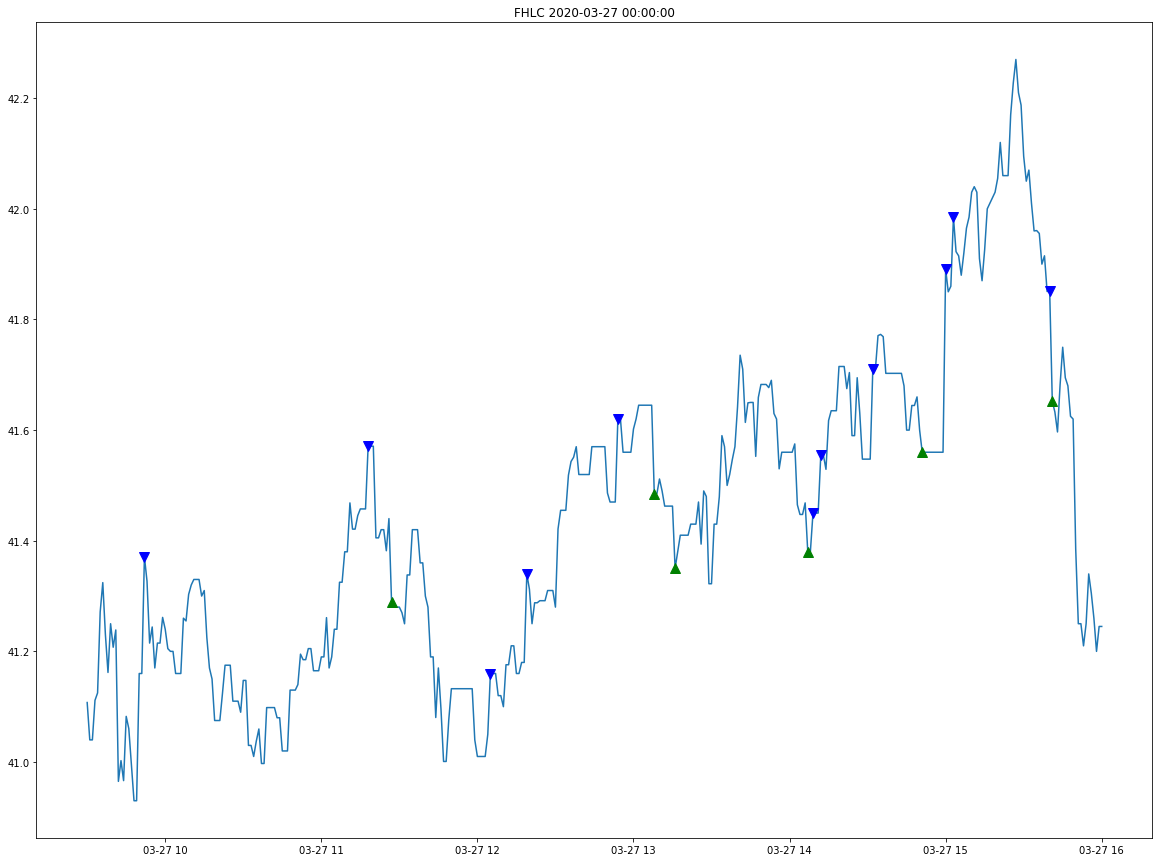

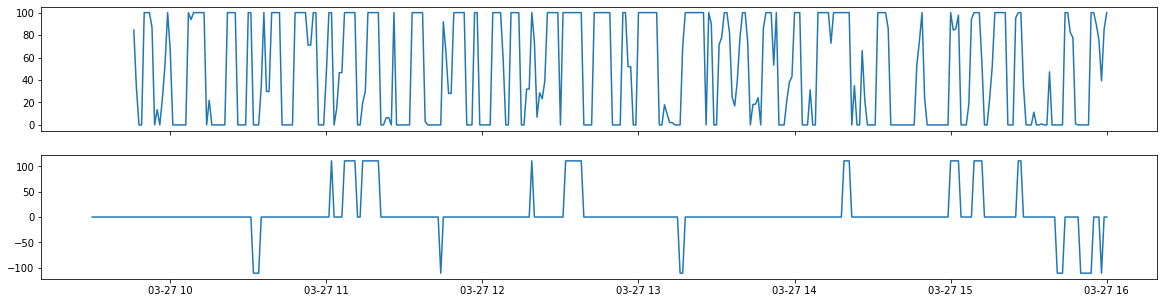

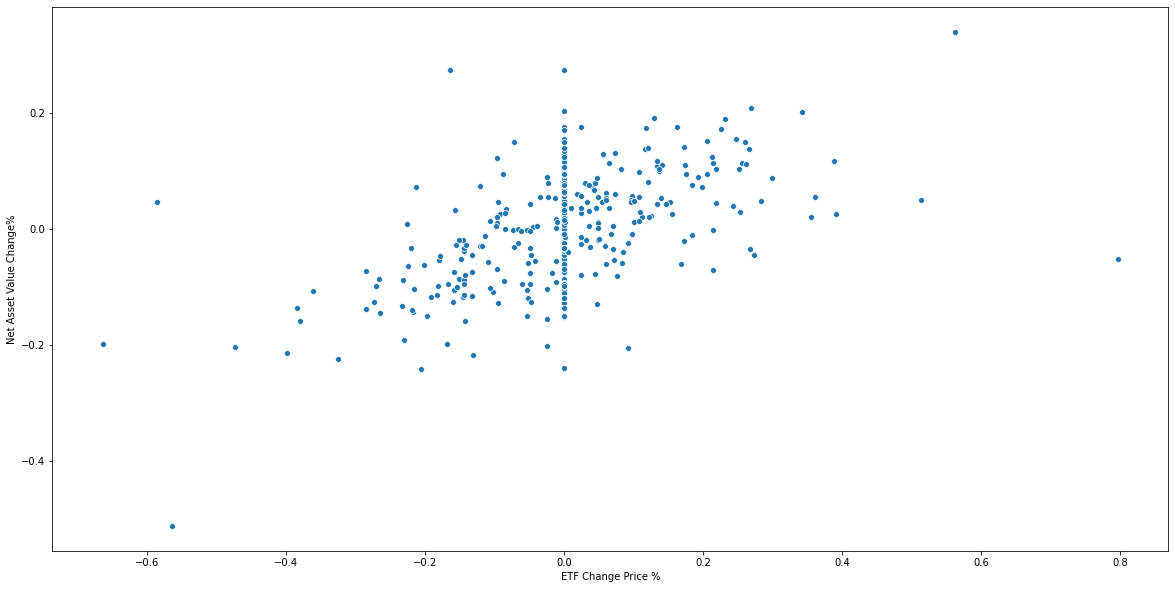

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
17  2020-03-30     UNH    22.448980         77.551020          
2   2020-03-30     MRK    27.027027         72.972973          
10  2020-03-30     PFE    15.384615         84.615385          
14  2020-03-30     ABT    10.344828         89.655172          
31  2020-03-30     TMO    10.526316         89.473684          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
17  56.666667         43.333333         109            49         60         
2   59.259259         40.740741         64             37         27         
10  60.869565         39.130435         62             39         23         
14  62.500000         37.500000         61             29         32         
31  73.913043         26.086957         42             19         23

ETF Name =FHLC
Date =2020-03-30 00:00:00
Sell Positions Probability
T+1    0.500000
T+2    0.166667
T+3    0.666667
T+4    0.166667
T+5    0.166667
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-30 10:36:00  0.076741                 0.146938        Weak Trend   
2020-03-30 10:44:00  0.069689                 0.092798        Weak Trend   
2020-03-30 12:06:00  0.033125                 0.087830        No Trend     
2020-03-30 13:47:00  0.061154                 0.083486        Weak Trend   
2020-03-30 13:59:00  0.052884                 0.094975        No Trend     
Total Return        NaN                      NaN              NaN          

                     AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-30 10:36:00  Strong Uptrend  111.0               111.0           
2020-03-30 10:44:00  Uptrend        -111.0               0.0             
2020-03-30 12:06:00  Downtrend       111.0               0.0             
2020-03-30 13:47:00  Downtrend       111.0               0.0             
2020-03-30 13:59:00  NaN             111.0               0.0             
Total Return         NaN            NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-03-30 10:36:00  111.0          111.0            111.0                  
2020-03-30 10:44:00  0.0            0.0             -111.0                  
2020-03-30 12:06:00  0.0            0.0              111.0                  
2020-03-30 13:47:00  0.0            0.0              111.0                  
2020-03-30 13:59:00  0.0            0.0              111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-03-30 10:36:00  111.0            111.0          0.030887  0.011696   
2020-03-30 10:44:00 -111.0            111.0         -0.163697 -0.023491   
2020-03-30 12:06:00  0.0             -111.0          0.000000  0.000000   
2020-03-30 13:47:00  0.0              0.0           -0.019232  0.093831   
2020-03-30 13:59:00  0.0              111.0          0.000000  0.000000   
Total Return        NaN              NaN            -0.152042  0.082036   

                          T+3       T+4       T+5  
2020-03-30 10:36:00 -0.012981  0.035556  0.000000  
2020-03-30 10:44:00  0.035244  0.000000  0.129184  
2020-03-30 12:06:00 -0.068440  0.018122  0.168715  
2020-03-30 13:47:00  0.000000  0.000000 -0.093743  
2020-03-30 13:59:00 -0.110225 -0.050360  0.000000  
Total Return        -0.156402  0.003318  0.204156

******************
Buy Positions Probability
T+1    0.8
T+2    0.4
T+3    0.6
T+4    0.2
T+5    0.8
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-30 11:16:00  0.064900                -0.090844        Weak Trend   
2020-03-30 11:24:00  0.077279                -0.108915        No Trend     
2020-03-30 11:38:00  0.060214                -0.114851        No Trend     
2020-03-30 12:45:00  0.060671                -0.087191        Weak Trend   
Total Return        NaN                      NaN              NaN          

                     AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-30 11:16:00  Uptrend        -111.0               0.0             
2020-03-30 11:24:00  NaN            -111.0               0.0             
2020-03-30 11:38:00  Downtrend      -111.0               0.0             
2020-03-30 12:45:00  Strong Uptrend -111.0               0.0             
Total Return         NaN            NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-03-30 11:16:00  0.0            0.0             -111.0                  
2020-03-30 11:24:00  0.0            0.0             -111.0                  
2020-03-30 11:38:00  0.0           -111.0           -111.0                  
2020-03-30 12:45:00  0.0            111.0           -111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-03-30 11:16:00  0.0              0.0            0.057934  0.000000   
2020-03-30 11:24:00 -111.0            0.0           -0.028300 -0.076232   
2020-03-30 11:38:00 -111.0            0.0            0.127504  0.002118   
2020-03-30 12:45:00  0.0              0.0            0.011224  0.028875   
Total Return        NaN              NaN             0.168362 -0.045238   

                          T+3       T+4       T+5  
2020-03-30 11:16:00  0.000000  0.201009  0.011112  
2020-03-30 11:24:00  0.117550 -0.046965  0.000000  
2020-03-30 11:38:00  0.240085 -0.039918  0.070472  
2020-03-30 12:45:00  0.000000 -0.122364  0.175170  
Total Return         0.357635 -0.008237  0.256754

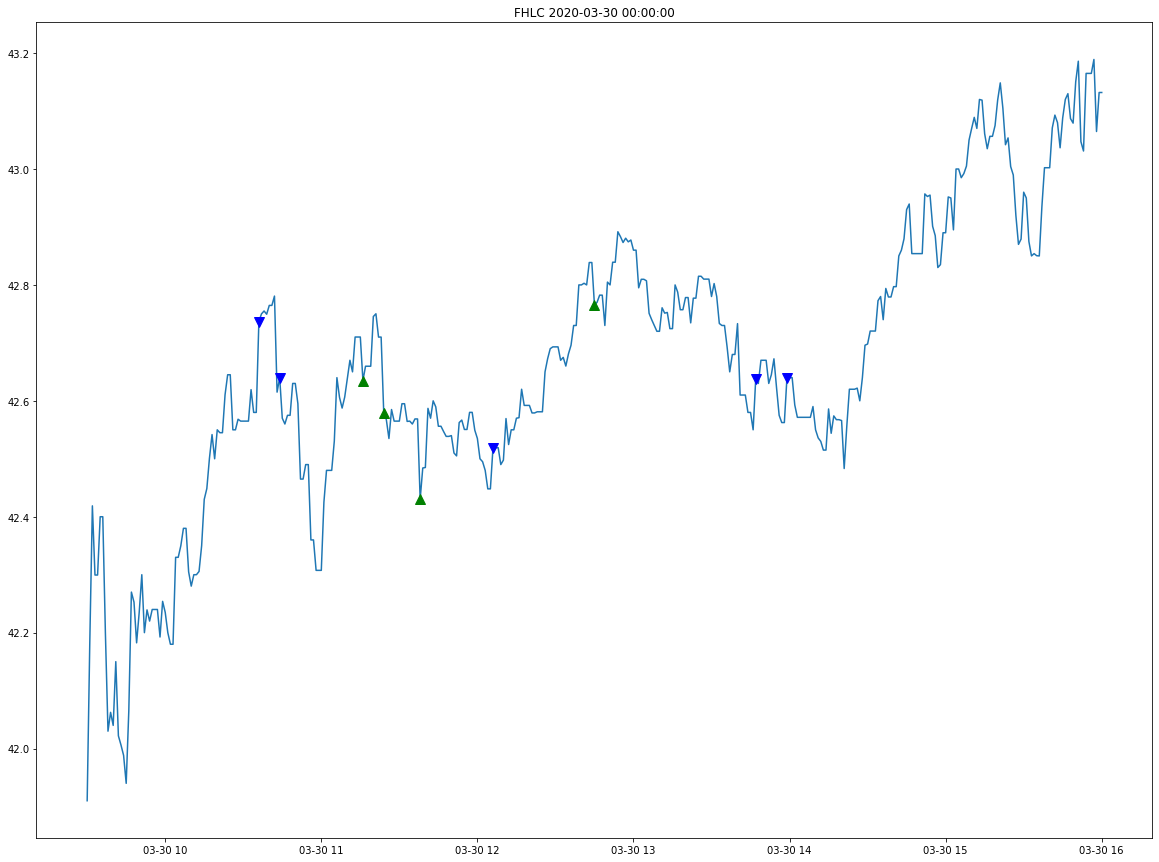

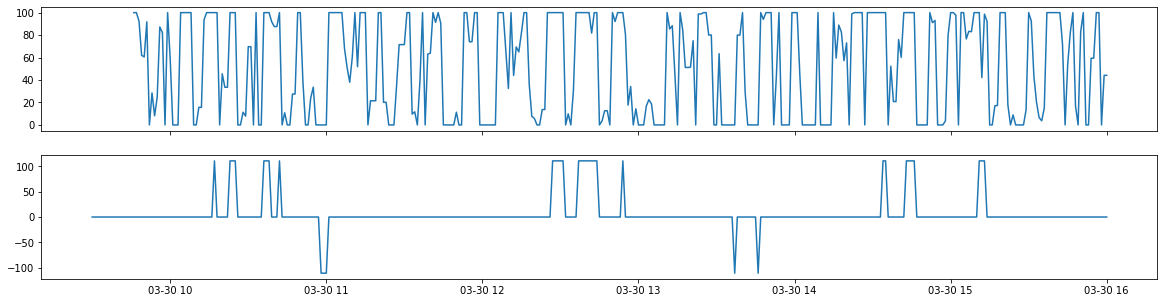

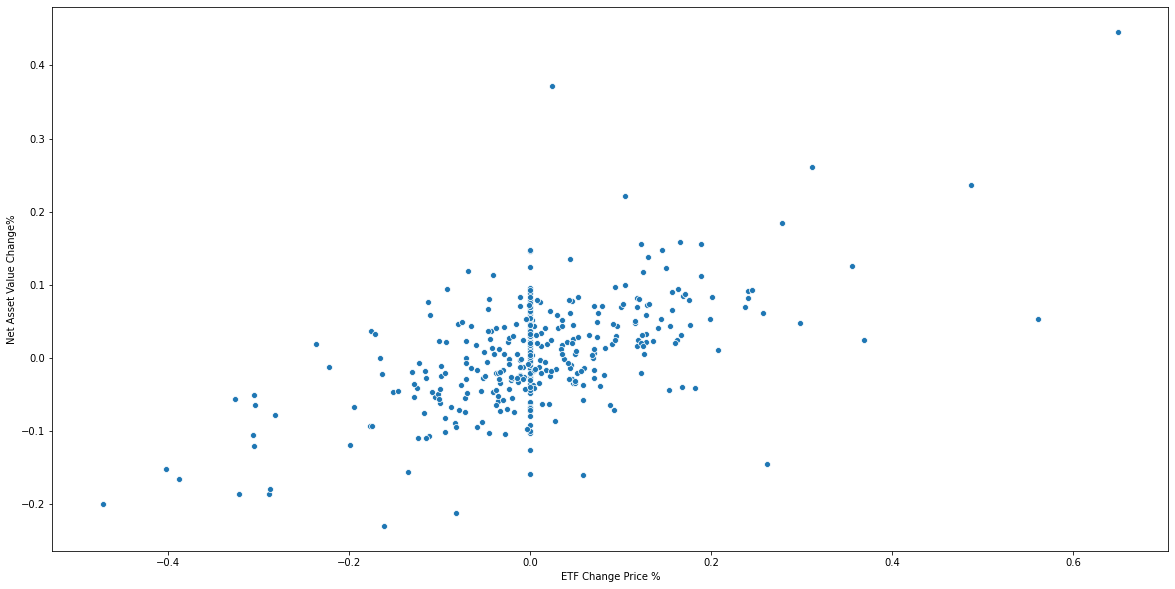

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
17  2020-03-31     UNH    25.531915         74.468085          
2   2020-03-31     MRK    32.432432         67.567568          
25  2020-03-31     LLY    19.047619         80.952381          
10  2020-03-31     PFE    25.000000         75.000000          
1   2020-03-31     ABBV   11.764706         88.235294          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
17  47.916667         52.083333         95             47         48         
2   50.000000         50.000000         83             37         46         
25  56.000000         44.000000         46             21         25         
10  31.818182         68.181818         42             20         22         
1   37.500000         62.500000         41             17         24

ETF Name =FHLC
Date =2020-03-31 00:00:00
Sell Positions Probability
T+1    0.4
T+2    0.4
T+3    0.2
T+4    0.6
T+5    0.2
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-31 10:38:00  0.075571                 0.097840        No Trend     
2020-03-31 13:32:00  0.064248                 0.088619        Weak Trend   
2020-03-31 13:56:00  0.064655                 0.091008        Weak Trend   
2020-03-31 14:40:00  0.047143                 0.068717        No Trend     
Total Return        NaN                      NaN              NaN          

                     AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-31 10:38:00  Strong Uptrend  111.0               0.0             
2020-03-31 13:32:00  NaN             111.0               0.0             
2020-03-31 13:56:00  NaN             111.0               0.0             
2020-03-31 14:40:00  Strong Uptrend  111.0               0.0             
Total Return         NaN            NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-03-31 10:38:00  0.0            0.0              111.0                  
2020-03-31 13:32:00  0.0            0.0              111.0                  
2020-03-31 13:56:00  0.0            0.0              111.0                  
2020-03-31 14:40:00  0.0            111.0            111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-03-31 10:38:00  111.0            111.0          0.000000  0.000000   
2020-03-31 13:32:00  111.0            0.0            0.000000 -0.017499   
2020-03-31 13:56:00  111.0            0.0           -0.106773  0.078190   
2020-03-31 14:40:00  111.0            0.0            0.011573 -0.023143   
Total Return        NaN              NaN            -0.095200  0.037549   

                          T+3       T+4       T+5  
2020-03-31 10:38:00 -0.084896 -0.214158  0.000000  
2020-03-31 13:32:00  0.053673  0.000000  0.215743  
2020-03-31 13:56:00  0.035640 -0.041778  0.000000  
2020-03-31 14:40:00  0.063889  0.017119 -0.208165  
Total Return         0.068306 -0.238817  0.007579

******************
Buy Positions Probability
T+1    0.0
T+2    0.4
T+3    0.6
T+4    0.6
T+5    0.8
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-03-31 09:30:00  0.098098                -0.127073        0            
2020-03-31 09:57:00  0.104694                -0.143778        Weak Trend   
2020-03-31 14:17:00  0.055072                -0.148791        Weak Trend   
2020-03-31 15:59:00  0.059265                -0.081642        Weak Trend   
Total Return        NaN                      NaN              NaN          

                    AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-03-31 09:30:00  NaN            0.0                 0.0             
2020-03-31 09:57:00  NaN            111.0               0.0             
2020-03-31 14:17:00  Downtrend     -111.0               0.0             
2020-03-31 15:59:00  Uptrend       -111.0               0.0             
Total Return         NaN           NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-03-31 09:30:00  0.0            0.0              0.0                    
2020-03-31 09:57:00  0.0            0.0              0.0                    
2020-03-31 14:17:00  0.0            0.0             -111.0                  
2020-03-31 15:59:00  0.0            0.0             -111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-03-31 09:30:00  0.0              0.0           -0.392605  0.182122   
2020-03-31 09:57:00  0.0              0.0            0.000000  0.000000   
2020-03-31 14:17:00  0.0             -111.0         -0.081191  0.000000   
2020-03-31 15:59:00  0.0              111.0          0.000000 NaN         
Total Return        NaN              NaN            -0.473796  0.182122   

                          T+3       T+4       T+5  
2020-03-31 09:30:00 -0.067141  0.111589  0.131668  
2020-03-31 09:57:00  0.219606  0.000000  0.258977  
2020-03-31 14:17:00  0.081490  0.058160  0.093002  
2020-03-31 15:59:00 NaN       NaN       NaN        
Total Return         0.233956  0.169749  0.483646

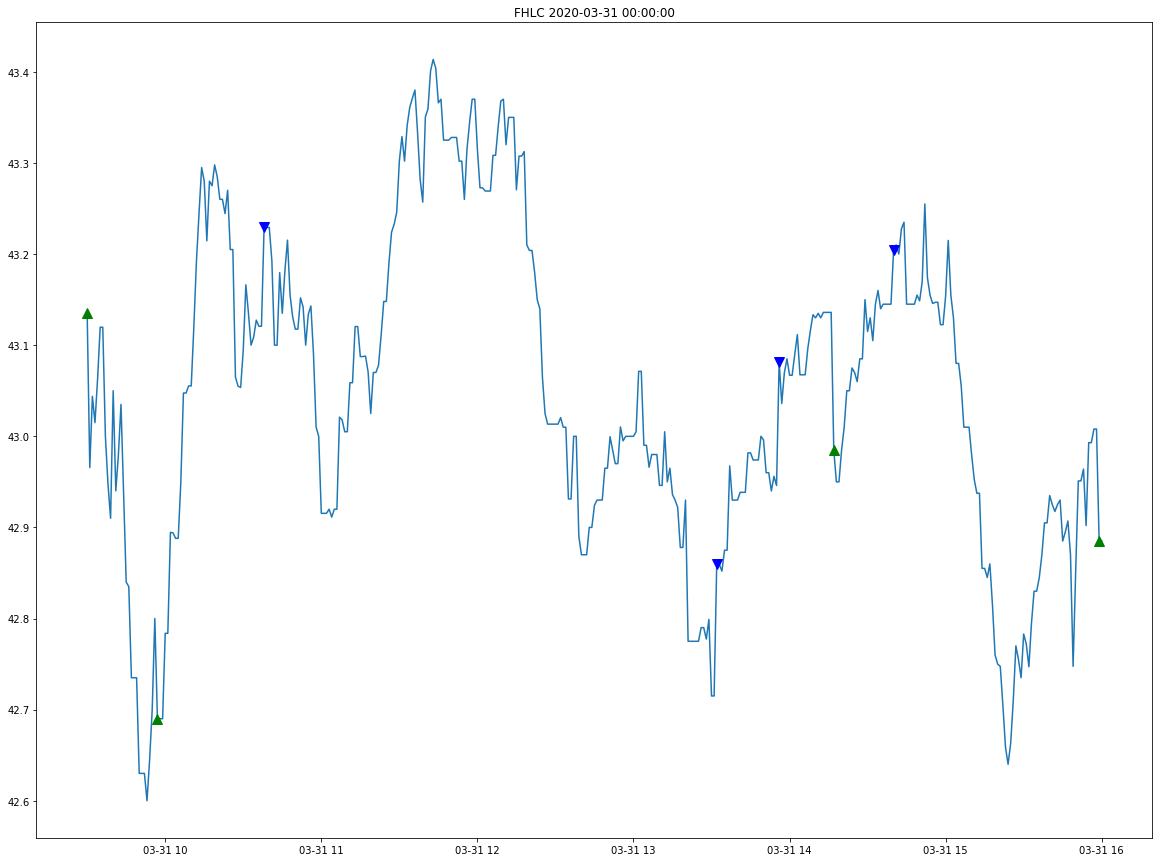

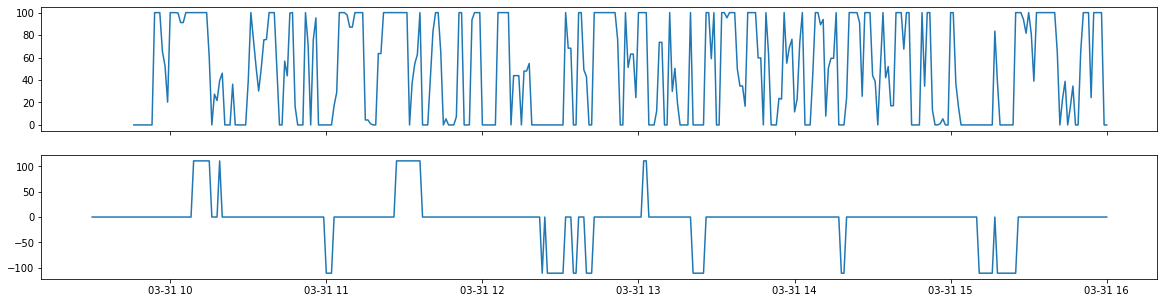

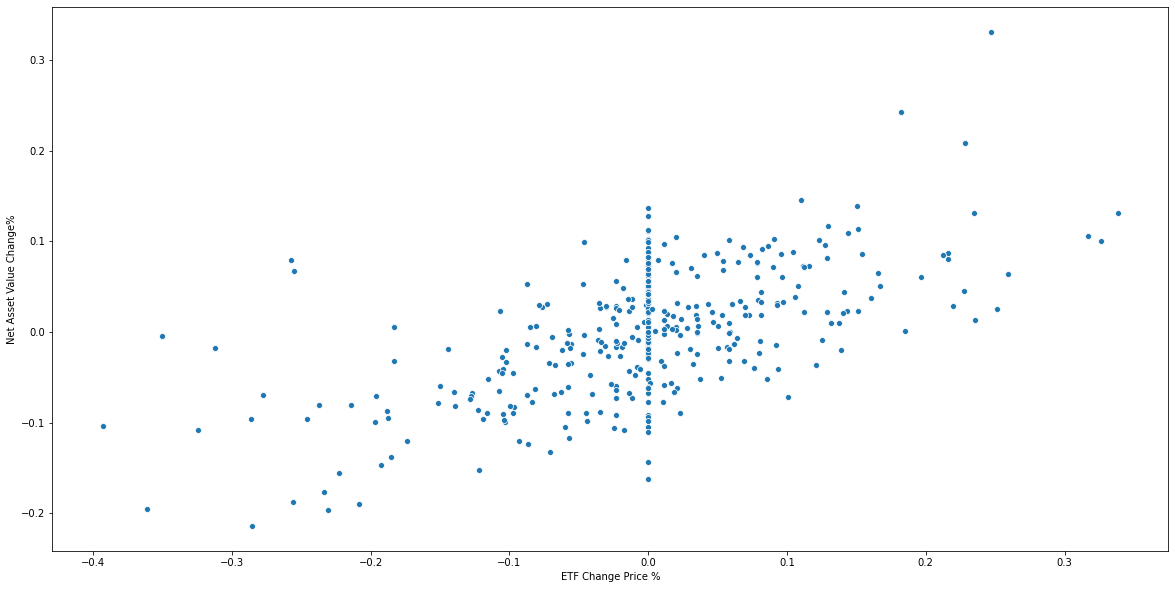

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
16  2020-04-01     UNH    18.333333         81.666667          
2   2020-04-01     MRK    15.555556         84.444444          
10  2020-04-01     PFE    20.000000         80.000000          
3   2020-04-01     TMO    5.882353          94.117647          
14  2020-04-01     ABT    19.047619         80.952381          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
16  32.835821         67.164179         127            60         67         
2   39.024390         60.975610         86             45         41         
10  32.142857         67.857143         53             25         28         
3   32.000000         68.000000         42             17         25         
14  52.941176         47.058824         38             21         17

ETF Name =FHLC
Date =2020-04-01 00:00:00
Sell Positions Probability
T+1    0.500000
T+2    0.333333
T+3    0.666667
T+4    0.500000
T+5    0.000000
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-04-01 11:20:00  0.075839                 0.126594        No Trend     
2020-04-01 11:59:00  0.079765                 0.130051        Weak Trend   
2020-04-01 14:04:00  0.073613                 0.128239        No Trend     
2020-04-01 14:39:00  0.064843                 0.111796        Weak Trend   
2020-04-01 15:56:00  0.060341                 0.081344        No Trend     
Total Return        NaN                      NaN              NaN          

                     AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-01 11:20:00  NaN             111.0               0.0             
2020-04-01 11:59:00  NaN             111.0               0.0             
2020-04-01 14:04:00  Strong Uptrend  111.0               0.0             
2020-04-01 14:39:00  NaN             111.0               0.0             
2020-04-01 15:56:00  Strong Uptrend  111.0               0.0             
Total Return         NaN            NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-04-01 11:20:00  0.0            0.0              111.0                  
2020-04-01 11:59:00  0.0            111.0            111.0                  
2020-04-01 14:04:00  0.0            0.0              111.0                  
2020-04-01 14:39:00  0.0            0.0              111.0                  
2020-04-01 15:56:00  0.0            0.0              111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-04-01 11:20:00  111.0           -111.0          0.000000  0.000000   
2020-04-01 11:59:00  111.0            0.0           -0.264106 -0.081608   
2020-04-01 14:04:00  111.0            111.0          0.000000  0.000000   
2020-04-01 14:39:00  111.0            0.0            0.000000  0.000000   
2020-04-01 15:56:00  111.0            111.0         -0.356646  0.000000   
Total Return        NaN              NaN            -0.620752 -0.081608   

                          T+3       T+4       T+5  
2020-04-01 11:20:00  0.000000 -0.296722  0.161677  
2020-04-01 11:59:00 -0.074929  0.000000  0.000000  
2020-04-01 14:04:00  0.144543 -0.192446  0.000000  
2020-04-01 14:39:00 -0.149885  0.000000  0.058107  
2020-04-01 15:56:00 -0.072798  0.000000 NaN        
Total Return        -0.153068 -0.489168  0.219784

******************
Buy Positions Probability
T+1    0.142857
T+2    0.428571
T+3    0.428571
T+4    0.000000
T+5    0.000000
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-04-01 11:14:00  0.076960                -0.134054        No Trend     
2020-04-01 11:41:00  0.065890                -0.086046        No Trend     
2020-04-01 13:28:00  0.070482                -0.120771        Weak Trend   
2020-04-01 14:22:00  0.066730                -0.092078        No Trend     
2020-04-01 14:36:00  0.060240                -0.174521        No Trend     
2020-04-01 15:23:00  0.038571                -0.063624        No Trend     
Total Return        NaN                      NaN              NaN          

                    AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-01 11:14:00  NaN           -111.0               0.0             
2020-04-01 11:41:00  NaN           -111.0              -111.0           
2020-04-01 13:28:00  NaN           -111.0               0.0             
2020-04-01 14:22:00  NaN           -111.0               0.0             
2020-04-01 14:36:00  NaN           -111.0              -111.0           
2020-04-01 15:23:00  NaN           -111.0               0.0             
Total Return         NaN           NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-04-01 11:14:00  0.0            0.0             -111.0                  
2020-04-01 11:41:00 -111.0         -111.0           -111.0                  
2020-04-01 13:28:00  0.0            0.0             -111.0                  
2020-04-01 14:22:00  0.0           -111.0           -111.0                  
2020-04-01 14:36:00 -111.0         -111.0           -111.0                  
2020-04-01 15:23:00  0.0            0.0             -111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-04-01 11:14:00 -111.0           -111.0         -0.001557  0.030546   
2020-04-01 11:41:00 -111.0            0.0            0.000000 -0.024030   
2020-04-01 13:28:00 -111.0            0.0            0.000000  0.051983   
2020-04-01 14:22:00 -111.0           -111.0          0.024178  0.000000   
2020-04-01 14:36:00 -111.0           -111.0          0.000000  0.000000   
2020-04-01 15:23:00 -111.0            0.0           -0.109436 -0.012173   
Total Return        NaN              NaN            -0.086815  0.046326   

                          T+3  T+4       T+5  
2020-04-01 11:14:00  0.000000  0.0  0.000000  
2020-04-01 11:41:00  0.131234  0.0  0.000000  
2020-04-01 13:28:00  0.000000  0.0 -0.121109  
2020-04-01 14:22:00 -0.048344  0.0 -0.072551  
2020-04-01 14:36:00  0.333272  0.0  0.000000  
2020-04-01 15:23:00 -0.073046  0.0 -0.048733  
Total Return         0.343116  0.0 -0.242394

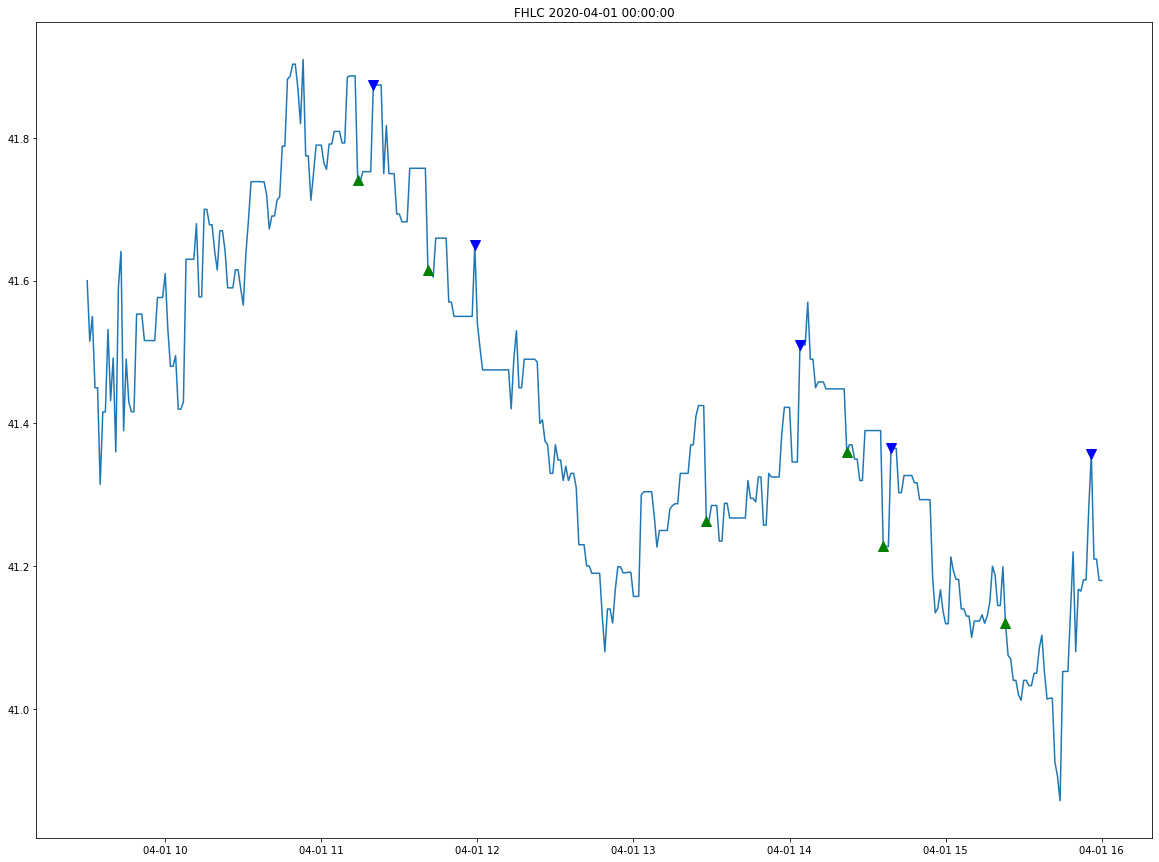

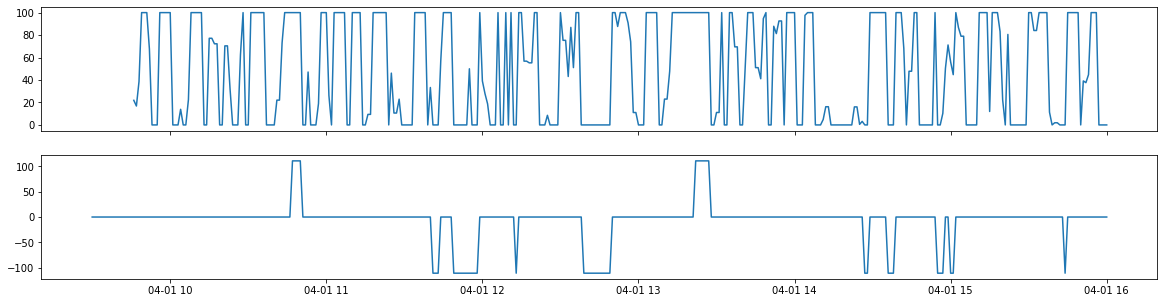

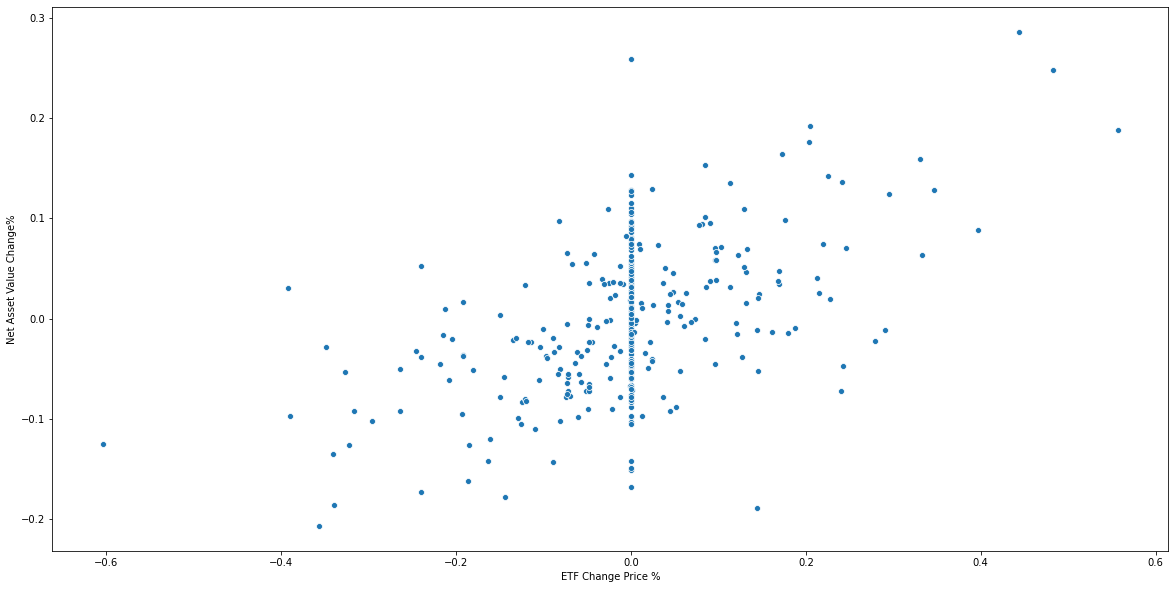

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
16  2020-04-02     UNH    8.000000          92.000000          
2   2020-04-02     MRK    12.765957         87.234043          
8   2020-04-02     PFE    14.705882         85.294118          
10  2020-04-02     MDT    9.090909          90.909091          
12  2020-04-02     ABT    0.000000          100.000000         

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
16  32.222222         67.777778         165            75         90         
2   27.450980         72.549020         98             47         51         
8   38.235294         61.764706         68             34         34         
10  29.629630         70.370370         49             22         27         
12  43.478261         56.521739         48             25         23

ETF Name =FHLC
Date =2020-04-02 00:00:00
Sell Positions Probability
T+1    0.538462
T+2    0.307692
T+3    0.307692
T+4    0.000000
T+5    0.307692
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $     ADX Trend  \
2020-04-02 09:33:00  0.326755                 0.527841        0              
2020-04-02 10:33:00  0.115257                 0.208253        Weak Trend     
2020-04-02 10:37:00  0.108919                 0.199843        Strong Trend   
2020-04-02 11:44:00  0.090174                 0.152801        Weak Trend     
2020-04-02 13:54:00  0.068807                 0.121553        Weak Trend     
2020-04-02 14:18:00  0.069407                 0.096708        Weak Trend     
2020-04-02 14:28:00  0.076421                 0.120326        Weak Trend     
2020-04-02 14:56:00  0.074068                 0.115678        Weak Trend     
2020-04-02 15:01:00  0.065875                 0.087585        Weak Trend     
2020-04-02 15:16:00  0.064683                 0.167660        Strong Trend   
2020-04-02 15:31:00  0.072790                 0.095633        Weak Trend     
2020-04-02 15:56:00  0.058030                 0.086181        Weak Trend     
Total Return        NaN                      NaN              NaN            

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-02 09:33:00  NaN               0.0                 0.0             
2020-04-02 10:33:00  Strong Uptrend    111.0               111.0           
2020-04-02 10:37:00  Strong Uptrend    111.0               111.0           
2020-04-02 11:44:00  Uptrend           111.0               0.0             
2020-04-02 13:54:00  NaN               111.0               0.0             
2020-04-02 14:18:00  Strong Downtrend  111.0               0.0             
2020-04-02 14:28:00  Uptrend           111.0               0.0             
2020-04-02 14:56:00  Strong Uptrend    111.0               111.0           
2020-04-02 15:01:00  Strong Uptrend    111.0               111.0           
2020-04-02 15:16:00  Strong Uptrend    111.0               111.0           
2020-04-02 15:31:00  NaN               111.0               0.0             
2020-04-02 15:56:00  Uptrend           111.0               111.0           
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-04-02 09:33:00  0.0            0.0              0.0                    
2020-04-02 10:33:00  111.0          111.0            111.0                  
2020-04-02 10:37:00  111.0          111.0            111.0                  
2020-04-02 11:44:00  0.0            0.0              111.0                  
2020-04-02 13:54:00  0.0            0.0              111.0                  
2020-04-02 14:18:00  0.0            0.0              111.0                  
2020-04-02 14:28:00  0.0            111.0            111.0                  
2020-04-02 14:56:00  111.0          111.0            111.0                  
2020-04-02 15:01:00  111.0          111.0            111.0                  
2020-04-02 15:16:00  111.0          111.0            111.0                  
2020-04-02 15:31:00  0.0            0.0              111.0                  
2020-04-02 15:56:00  111.0          111.0            111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-04-02 09:33:00  0.0              0.0           -0.324671  0.000000   
2020-04-02 10:33:00  111.0            111.0          0.007313  0.000000   
2020-04-02 10:37:00  111.0            111.0          0.000000 -0.049280   
2020-04-02 11:44:00  111.0           -111.0          0.000000  0.191847   
2020-04-02 13:54:00  111.0           -111.0          0.000000  0.000000   
2020-04-02 14:18:00 -111.0            0.0           -0.230942  0.000000   
2020-04-02 14:28:00  111.0            0.0            0.000000  0.009639   
2020-04-02 14:56:00  111.0            111.0          0.000000  0.000000   
2020-04-02 15:01:00  0.0              111.0         -0.109065  0.000000   
2020-04-02 15:16:00  111.0        

******************
Buy Positions Probability
T+1    0.125
T+2    0.250
T+3    0.625
T+4    0.125
T+5    0.125
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $     ADX Trend  \
2020-04-02 10:42:00  0.127073                -0.187218        Strong Trend   
2020-04-02 12:58:00  0.049591                -0.122807        Weak Trend     
2020-04-02 13:12:00  0.072276                -0.135286        Weak Trend     
2020-04-02 14:03:00  0.067104                -0.102701        Weak Trend     
2020-04-02 14:43:00  0.074599                -0.103833        Weak Trend     
2020-04-02 15:17:00  0.042792                -0.074970        Strong Trend   
2020-04-02 15:32:00  0.060564                -0.080770        Weak Trend     
Total Return        NaN                      NaN              NaN            

                    AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-02 10:42:00  Uptrend       -111.0               0.0             
2020-04-02 12:58:00  NaN           -111.0               0.0             
2020-04-02 13:12:00  NaN           -111.0              -111.0           
2020-04-02 14:03:00  Downtrend     -111.0              -111.0           
2020-04-02 14:43:00  NaN           -111.0               0.0             
2020-04-02 15:17:00  Uptrend        111.0               0.0             
2020-04-02 15:32:00  Downtrend     -111.0               0.0             
Total Return         NaN           NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-04-02 10:42:00  0.0            0.0             -111.0                  
2020-04-02 12:58:00  0.0            0.0             -111.0                  
2020-04-02 13:12:00 -111.0         -111.0           -111.0                  
2020-04-02 14:03:00 -111.0         -111.0           -111.0                  
2020-04-02 14:43:00  0.0            0.0             -111.0                  
2020-04-02 15:17:00  0.0            0.0              0.0                    
2020-04-02 15:32:00  0.0           -111.0           -111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-04-02 10:42:00 -111.0            111.0          0.000000 -0.089185   
2020-04-02 12:58:00 -111.0            111.0          0.000000  0.000000   
2020-04-02 13:12:00 -111.0           -111.0          0.093361 -0.047115   
2020-04-02 14:03:00 -111.0            0.0            0.000000  0.000000   
2020-04-02 14:43:00 -111.0            0.0           -0.050042 -0.166570   
2020-04-02 15:17:00  0.0              0.0           -0.166985  0.320669   
2020-04-02 15:32:00 -111.0            0.0            0.000000  0.000000   
Total Return        NaN              NaN            -0.123666  0.017800   

                          T+3       T+4       T+5  
2020-04-02 10:42:00  0.294752 -0.061525 -0.163171  
2020-04-02 12:58:00  0.029098  0.000000  0.000000  
2020-04-02 13:12:00  0.000000  0.000000  0.000000  
2020-04-02 14:03:00  0.000000 -0.168797  0.122705  
2020-04-02 14:43:00  0.000000  0.156721  0.000000  
2020-04-02 15:17:00  0.090034 -0.123745  0.000000  
2020-04-02 15:32:00  0.143198 -0.023356 -0.238855  
Total Return         0.557082 -0.220701 -0.279320

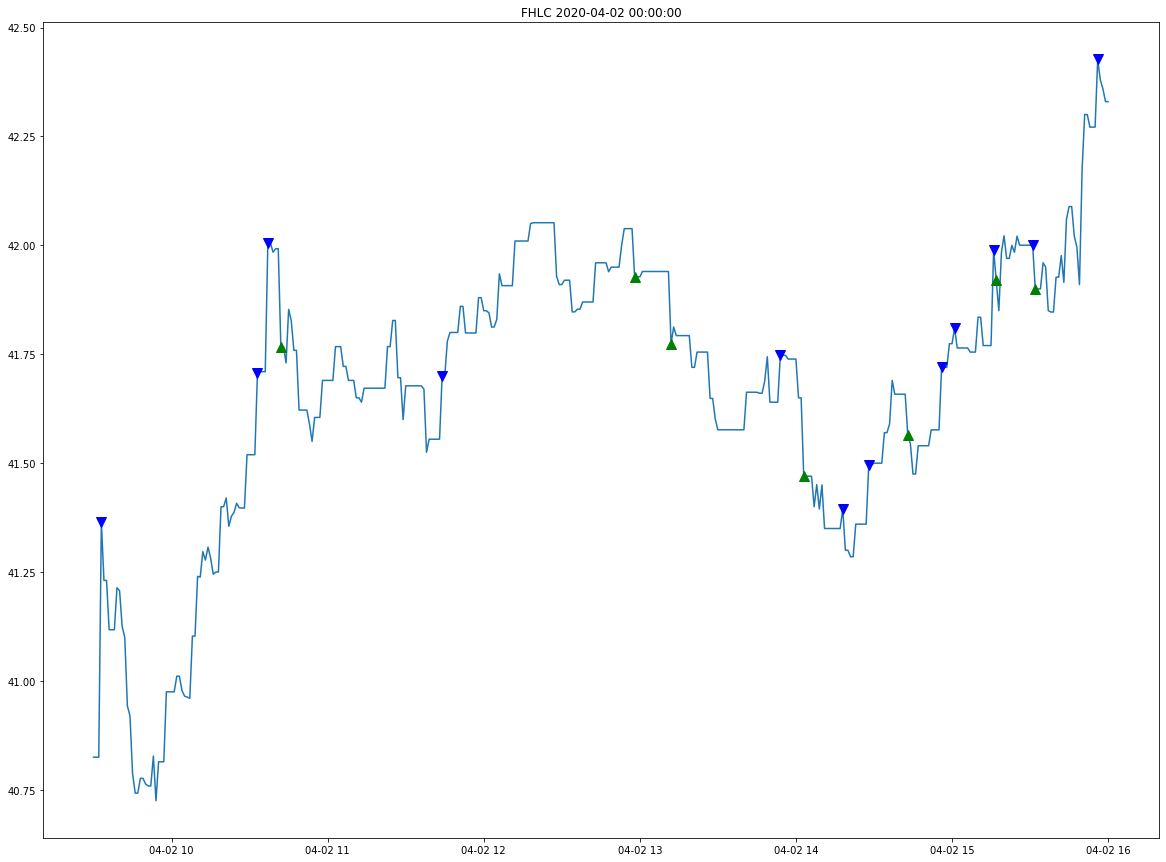

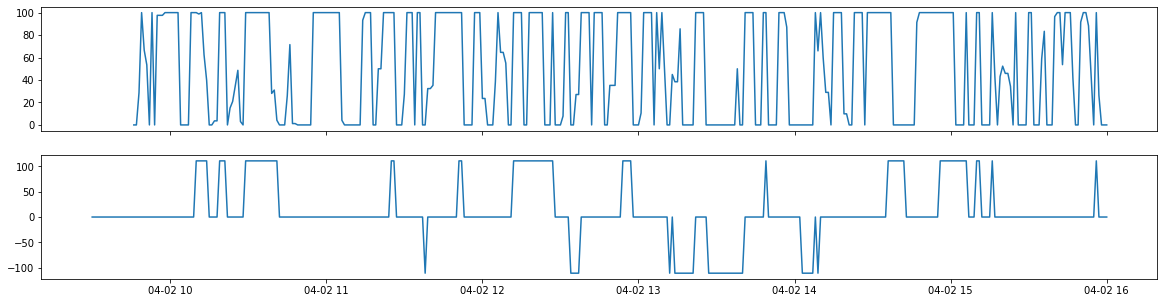

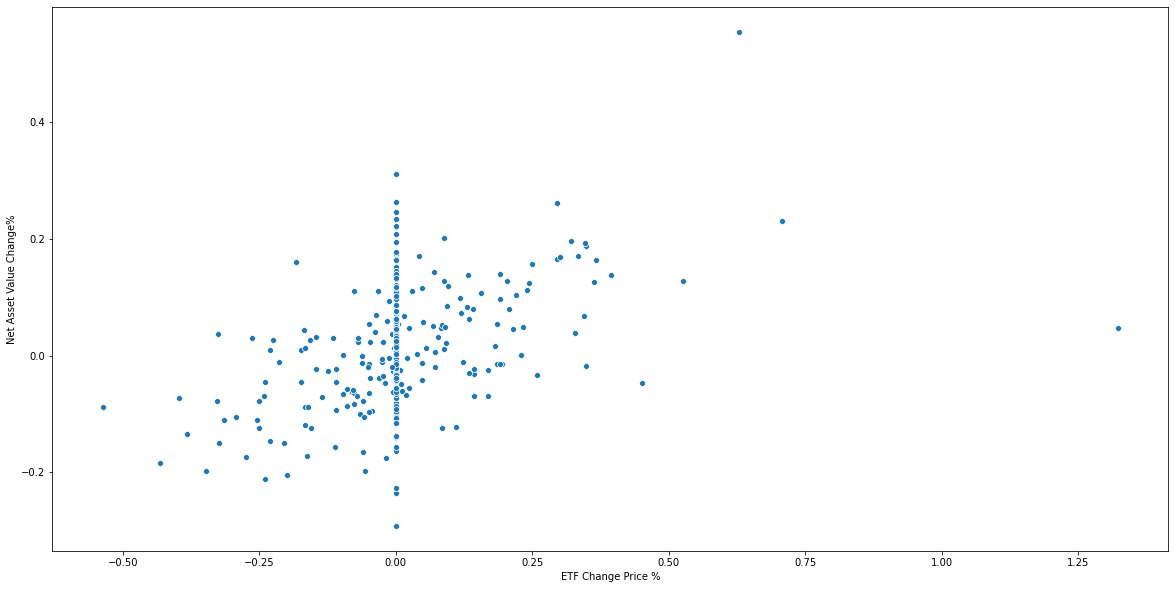

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
15  2020-04-03     UNH    19.672131         80.327869          
9   2020-04-03     PFE    13.953488         86.046512          
2   2020-04-03     MRK    16.216216         83.783784          
13  2020-04-03     ABT    28.571429         71.428571          
24  2020-04-03     TMO    8.695652          91.304348          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
15  26.666667         73.333333         121            61         60         
9   29.729730         70.270270         80             43         37         
2   36.842105         63.157895         75             37         38         
13  33.333333         66.666667         49             28         21         
24  25.000000         75.000000         43             23         20

ETF Name =FHLC
Date =2020-04-03 00:00:00
Sell Positions Probability
T+1    0.333333
T+2    0.333333
T+3    0.500000
T+4    0.333333
T+5    0.333333
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-04-03 10:58:00  0.075084                 0.108066        No Trend     
2020-04-03 11:52:00  0.068794                 0.097760        Weak Trend   
2020-04-03 13:51:00  0.061490                 0.091467        Weak Trend   
2020-04-03 15:29:00  0.043289                 0.077571        No Trend     
2020-04-03 15:50:00  0.077184                 0.110486        Weak Trend   
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-03 10:58:00  Strong Downtrend  111.0               0.0             
2020-04-03 11:52:00  Strong Downtrend  111.0               0.0             
2020-04-03 13:51:00  NaN               111.0               0.0             
2020-04-03 15:29:00  NaN               111.0               0.0             
2020-04-03 15:50:00  Uptrend           111.0               111.0           
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-04-03 10:58:00  0.0            0.0              111.0                  
2020-04-03 11:52:00  0.0            0.0              111.0                  
2020-04-03 13:51:00  0.0            0.0              111.0                  
2020-04-03 15:29:00  0.0            111.0            111.0                  
2020-04-03 15:50:00  111.0          111.0            111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-04-03 10:58:00  0.0              0.0           -0.035537  0.000000   
2020-04-03 11:52:00  0.0             -111.0          0.000000 -0.003223   
2020-04-03 13:51:00  111.0           -111.0          0.000000  0.000000   
2020-04-03 15:29:00  111.0            0.0            0.029947  0.000000   
2020-04-03 15:50:00  111.0            111.0          0.000000  0.000000   
Total Return        NaN              NaN            -0.005589 -0.003223   

                          T+3       T+4       T+5  
2020-04-03 10:58:00  0.036853  0.000000 -0.063728  
2020-04-03 11:52:00 -0.059097  0.136303  0.000000  
2020-04-03 13:51:00  0.000000 -0.089605  0.000000  
2020-04-03 15:29:00 -0.143704  0.000000  0.000000  
2020-04-03 15:50:00  0.059542 -0.004522  0.000000  
Total Return        -0.106407  0.042176 -0.063728

******************
Buy Positions Probability
T+1    0.444444
T+2    0.666667
T+3    0.444444
T+4    0.333333
T+5    0.111111
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-04-03 12:13:00  0.058819                -0.161516        No Trend     
2020-04-03 12:48:00  0.062237                -0.144622        Weak Trend   
2020-04-03 13:28:00  0.060905                -0.168392        No Trend     
2020-04-03 13:33:00  0.034315                -0.103600        Weak Trend   
2020-04-03 14:45:00  0.051729                -0.073222        No Trend     
2020-04-03 15:05:00  0.055168                -0.133984        Weak Trend   
2020-04-03 15:44:00  0.044230                -0.137383        Weak Trend   
2020-04-03 15:57:00  0.054819                -0.098585        Weak Trend   
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-03 12:13:00  Strong Downtrend -111.0              -111.0           
2020-04-03 12:48:00  NaN              -111.0               0.0             
2020-04-03 13:28:00  NaN              -111.0              -111.0           
2020-04-03 13:33:00  Downtrend        -111.0              -111.0           
2020-04-03 14:45:00  NaN              -111.0               0.0             
2020-04-03 15:05:00  NaN              -111.0               0.0             
2020-04-03 15:44:00  Downtrend        -111.0              -111.0           
2020-04-03 15:57:00  Uptrend          -111.0               0.0             
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-04-03 12:13:00 -111.0         -111.0           -111.0                  
2020-04-03 12:48:00  0.0            0.0             -111.0                  
2020-04-03 13:28:00 -111.0          0.0             -111.0                  
2020-04-03 13:33:00 -111.0          0.0             -111.0                  
2020-04-03 14:45:00  0.0            0.0             -111.0                  
2020-04-03 15:05:00  0.0            0.0             -111.0                  
2020-04-03 15:44:00 -111.0          0.0             -111.0                  
2020-04-03 15:57:00  0.0            0.0             -111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-04-03 12:13:00 -111.0            0.0            0.031359  0.062339   
2020-04-03 12:48:00 -111.0            111.0          0.000000  0.047870   
2020-04-03 13:28:00 -111.0           -111.0         -0.051830  0.000000   
2020-04-03 13:33:00 -111.0           -111.0          0.000000  0.150430   
2020-04-03 14:45:00 -111.0           -111.0          0.000000  0.181064   
2020-04-03 15:05:00 -111.0            0.0            0.000000  0.000000   
2020-04-03 15:44:00 -111.0           -111.0          0.159325  0.000000   
2020-04-03 15:57:00 -111.0            0.0            0.013391  0.122772   
Total Return        NaN              NaN             0.152245  0.564475   

                          T+3       T+4       T+5  
2020-04-03 12:13:00  0.000000  0.000000  0.000000  
2020-04-03 12:48:00  0.000000  0.000000  0.000000  
2020-04-03 13:28:00  0.000000  0.000000 -0.254241  
2020-04-03 13:33:00  0.000000  0.096131  0.000000  
2020-04-03 14:45:00  0.003848  0.000000  0.131549  
2020-04-03 15:05:00  0.011993  0.000000 -0.059959  
2020-04-03 15:44:00  0.083804  0.276550  0.000000  
2020-04-03 15:57:00  0.000000 NaN       NaN        
Total Return         0.099645  0.372681 -0.182651

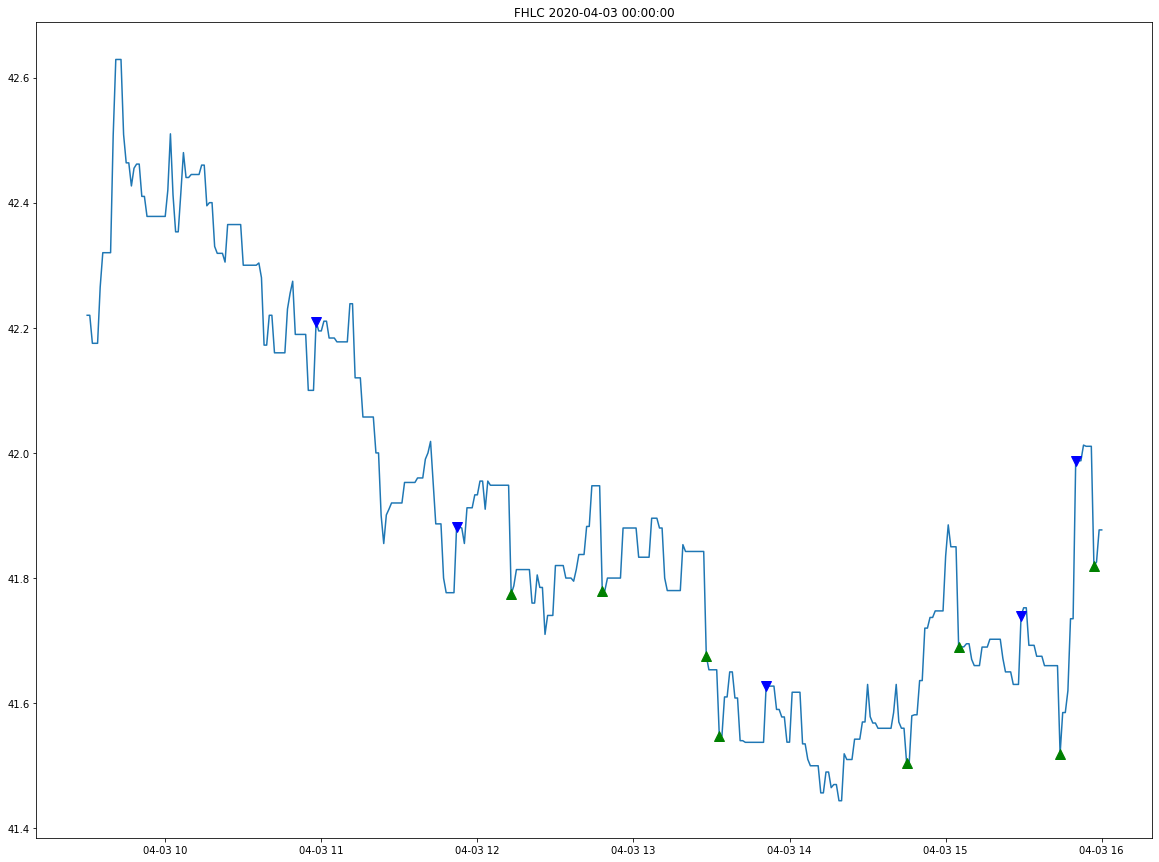

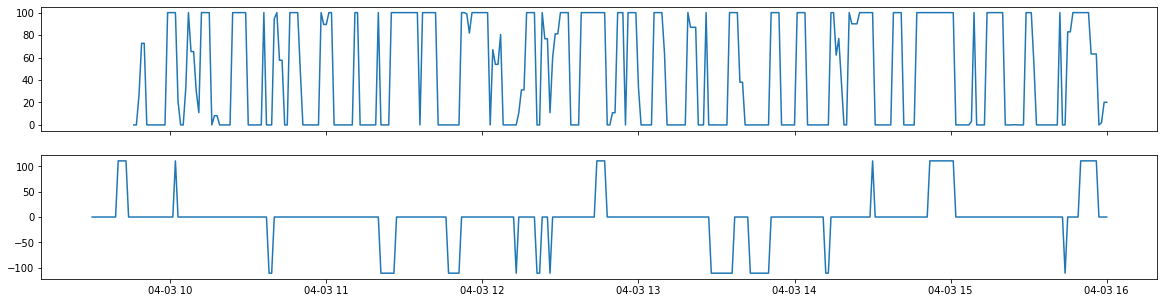

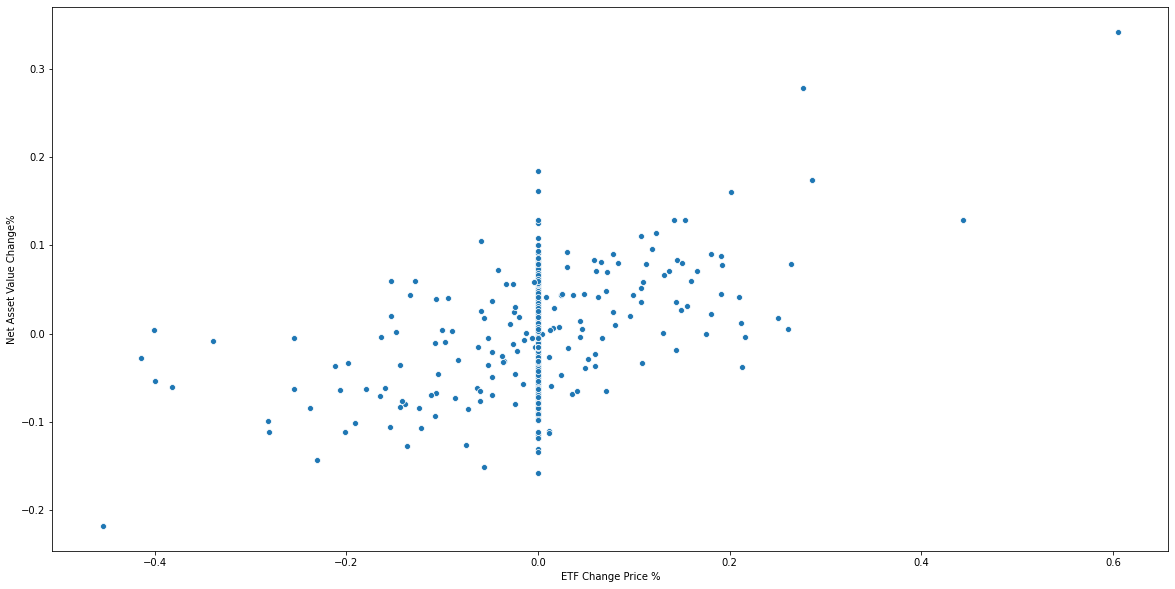

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
15  2020-04-06     UNH    21.875000         78.125000          
10  2020-04-06     PFE    13.793103         86.206897          
2   2020-04-06     MRK    12.500000         87.500000          
13  2020-04-06     ABT    28.571429         71.428571          
9   2020-04-06     BMY    12.500000         87.500000          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
15  35.294118         64.705882         66             32         34         
10  45.833333         54.166667         53             29         24         
2   61.538462         38.461538         50             24         26         
13  61.538462         38.461538         27             14         13         
9   43.750000         56.250000         24             8          16

ETF Name =FHLC
Date =2020-04-06 00:00:00
Sell Positions Probability
T+1    0.6
T+2    0.0
T+3    0.2
T+4    0.6
T+5    0.0
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-04-06 13:02:00  0.048559                 0.070374        No Trend     
2020-04-06 14:58:00  0.044478                 0.094782        No Trend     
2020-04-06 15:08:00  0.040129                 0.084251        No Trend     
2020-04-06 15:51:00  0.050681                 0.086112        Weak Trend   
Total Return        NaN                      NaN              NaN          

                     AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-06 13:02:00  Strong Uptrend  111.0               111.0           
2020-04-06 14:58:00  NaN             111.0               0.0             
2020-04-06 15:08:00  NaN             111.0               111.0           
2020-04-06 15:51:00  NaN             111.0               111.0           
Total Return         NaN            NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-04-06 13:02:00  111.0          111.0            111.0                  
2020-04-06 14:58:00  0.0            0.0              111.0                  
2020-04-06 15:08:00  111.0          0.0              111.0                  
2020-04-06 15:51:00  111.0          0.0              111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-04-06 13:02:00  111.0            0.0           -0.085656  0.016003   
2020-04-06 14:58:00  111.0            111.0          0.000000  0.000000   
2020-04-06 15:08:00  111.0            111.0         -0.186828  0.141128   
2020-04-06 15:51:00  111.0            0.0            0.000000  0.056569   
Total Return        NaN              NaN            -0.272484  0.213700   

                          T+3       T+4       T+5  
2020-04-06 13:02:00  0.000000 -0.158859  0.000000  
2020-04-06 14:58:00 -0.211913  0.000000  0.000000  
2020-04-06 15:08:00  0.011668 -0.194441  0.028650  
2020-04-06 15:51:00  0.297757  0.109802  0.152223  
Total Return         0.097512 -0.243498  0.180873

******************
Buy Positions Probability
T+1    0.375
T+2    0.500
T+3    0.375
T+4    0.250
T+5    0.500
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-04-06 10:15:00  0.053023                -0.074355        No Trend     
2020-04-06 10:46:00  0.036757                -0.063901        Weak Trend   
2020-04-06 11:37:00  0.060909                -0.083079        No Trend     
2020-04-06 13:06:00  0.046885                -0.077737        No Trend     
2020-04-06 15:01:00  0.044375                -0.073940        Weak Trend   
2020-04-06 15:09:00  0.043357                -0.068584        No Trend     
2020-04-06 15:55:00  0.047485                -0.069469        Weak Trend   
Total Return        NaN                      NaN              NaN          

                    AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-06 10:15:00  NaN           -111.0               0.0             
2020-04-06 10:46:00  Downtrend     -111.0               0.0             
2020-04-06 11:37:00  Downtrend     -111.0               0.0             
2020-04-06 13:06:00  NaN           -111.0               0.0             
2020-04-06 15:01:00  Uptrend       -111.0               0.0             
2020-04-06 15:09:00  NaN            111.0               0.0             
2020-04-06 15:55:00  Uptrend        111.0               111.0           
Total Return         NaN           NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-04-06 10:15:00  0.0            0.0             -111.0                  
2020-04-06 10:46:00  0.0            0.0             -111.0                  
2020-04-06 11:37:00  0.0            0.0             -111.0                  
2020-04-06 13:06:00  0.0            0.0             -111.0                  
2020-04-06 15:01:00  0.0            0.0             -111.0                  
2020-04-06 15:09:00  0.0            0.0             -111.0                  
2020-04-06 15:55:00  111.0          111.0            111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-04-06 10:15:00 -111.0            0.0            0.000000 -0.005762   
2020-04-06 10:46:00 -111.0            0.0           -0.036244 -0.092081   
2020-04-06 11:37:00 -111.0           -111.0          0.000000  0.094645   
2020-04-06 13:06:00 -111.0           -111.0          0.000000  0.158196   
2020-04-06 15:01:00  0.0              111.0          0.000000  0.000000   
2020-04-06 15:09:00  0.0              111.0          0.141128  0.011668   
2020-04-06 15:55:00  111.0            111.0          0.152223 -0.106924   
Total Return        NaN              NaN             0.257107  0.059741   

                          T+3       T+4       T+5  
2020-04-06 10:15:00  0.086440  0.075541  0.120130  
2020-04-06 10:46:00 -0.131567  0.000000 -0.029763  
2020-04-06 11:37:00  0.032287 -0.004380  0.060176  
2020-04-06 13:06:00 -0.020800  0.000000  0.000000  
2020-04-06 15:01:00  0.120530  0.000000  0.034854  
2020-04-06 15:09:00 -0.194441  0.028650 -0.024059  
2020-04-06 15:55:00 -0.208662 -0.224696  0.000000  
Total Return        -0.316213 -0.124885  0.161339

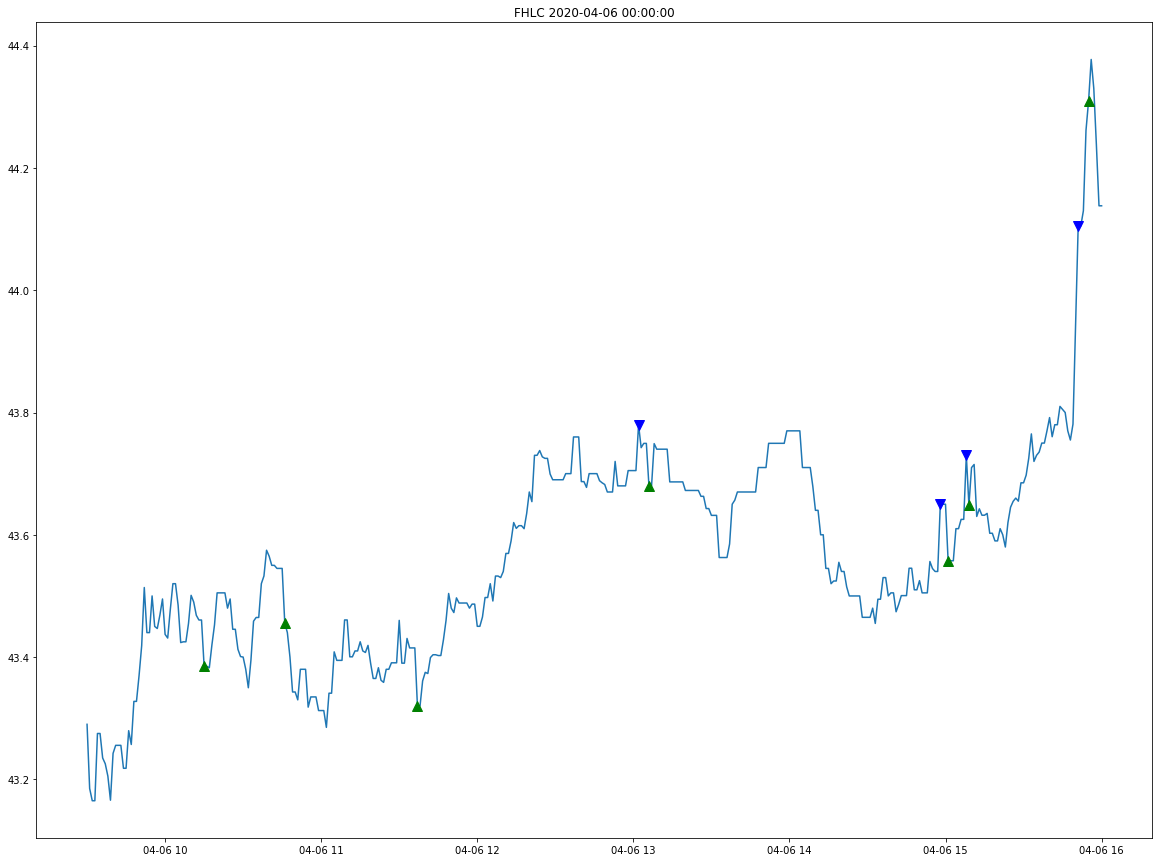

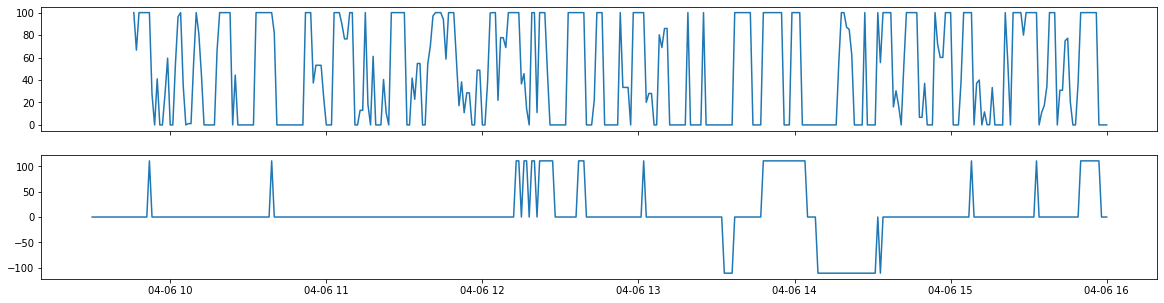

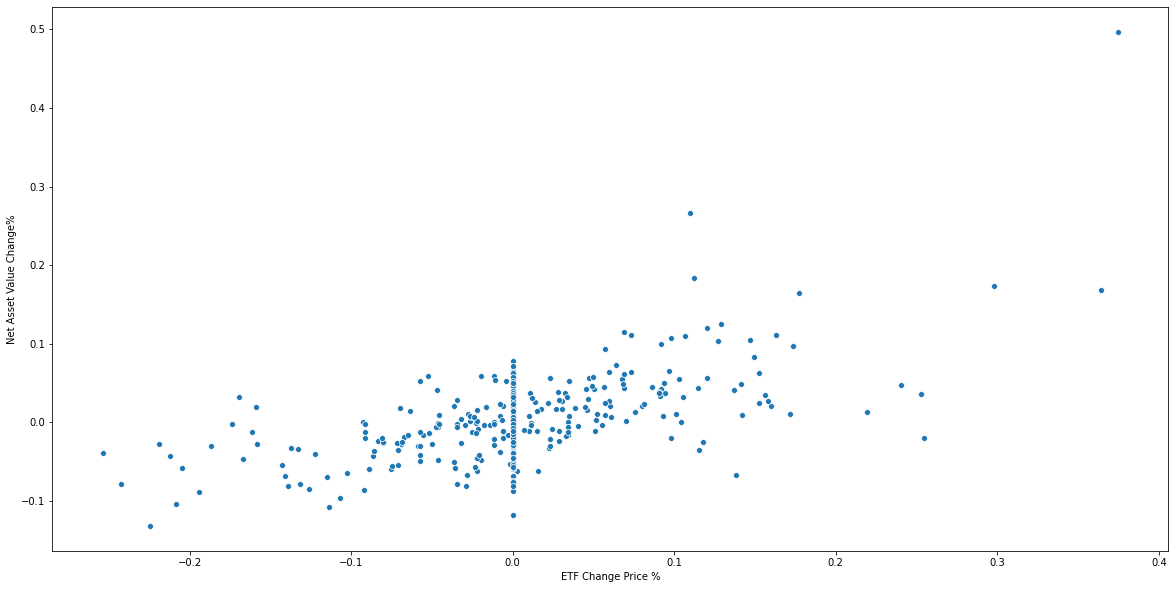

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
16  2020-04-07     UNH    21.428571         78.571429          
2   2020-04-07     MRK    13.513514         86.486486          
10  2020-04-07     PFE    14.285714         85.714286          
12  2020-04-07     MDT    28.571429         71.428571          
3   2020-04-07     TMO    16.000000         84.000000          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
16  52.777778         47.222222         142            70         72         
2   50.000000         50.000000         87             37         50         
10  33.333333         66.666667         71             35         36         
12  39.393939         60.606061         61             28         33         
3   65.217391         34.782609         48             25         23

ETF Name =FHLC
Date =2020-04-07 00:00:00
Sell Positions Probability
T+1    0.571429
T+2    0.428571
T+3    0.571429
T+4    0.142857
T+5    0.428571
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-04-07 12:03:00  0.062139                 0.094329        Weak Trend   
2020-04-07 12:39:00  0.060531                 0.091863        No Trend     
2020-04-07 15:27:00  0.057225                 0.147854        Weak Trend   
2020-04-07 15:35:00  0.047165                 0.180791        Weak Trend   
2020-04-07 15:41:00  0.057411                 0.093662        Weak Trend   
2020-04-07 15:54:00  0.064894                 0.087563        No Trend     
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-07 12:03:00  NaN               111.0               0.0             
2020-04-07 12:39:00  NaN               111.0               0.0             
2020-04-07 15:27:00  Strong Downtrend  111.0               0.0             
2020-04-07 15:35:00  Downtrend         111.0               0.0             
2020-04-07 15:41:00  Uptrend           111.0               0.0             
2020-04-07 15:54:00  NaN              -111.0               0.0             
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-04-07 12:03:00  0.0            111.0            111.0                  
2020-04-07 12:39:00  0.0            0.0              111.0                  
2020-04-07 15:27:00  0.0            0.0              111.0                  
2020-04-07 15:35:00  0.0            0.0              111.0                  
2020-04-07 15:41:00  0.0            0.0              111.0                  
2020-04-07 15:54:00  0.0            0.0              0.0                    
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-04-07 12:03:00  111.0            0.0            0.000000  0.000000   
2020-04-07 12:39:00  111.0            0.0           -0.065643  0.000000   
2020-04-07 15:27:00  0.0             -111.0         -0.136209 -0.181860   
2020-04-07 15:35:00  111.0            0.0            0.000000  0.000000   
2020-04-07 15:41:00  111.0            0.0           -0.070636 -0.066948   
2020-04-07 15:54:00  0.0              0.0            0.011507  0.049556   
Total Return        NaN              NaN            -0.260981 -0.199252   

                          T+3       T+4       T+5  
2020-04-07 12:03:00  0.000000  0.228910  0.200535  
2020-04-07 12:39:00  0.000000  0.000000  0.000000  
2020-04-07 15:27:00 -0.113869  0.045600 -0.091158  
2020-04-07 15:35:00 -0.113559  0.170532 -0.011349  
2020-04-07 15:41:00  0.000000  0.000000  0.158470  
2020-04-07 15:54:00 -0.095191 -0.045589 -0.091220  
Total Return        -0.322619  0.399452  0.165278

******************
Buy Positions Probability
T+1    0.666667
T+2    0.666667
T+3    0.333333
T+4    0.166667
T+5    0.166667
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-04-07 12:26:00  0.059958                -0.133872        Weak Trend   
2020-04-07 14:07:00  0.054385                -0.125391        Weak Trend   
2020-04-07 15:16:00  0.047970                -0.080621        No Trend     
2020-04-07 15:25:00  0.056131                -0.095499        Weak Trend   
2020-04-07 15:34:00  0.053389                -0.086480        Weak Trend   
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-07 12:26:00  NaN              -111.0               0.0             
2020-04-07 14:07:00  Strong Downtrend -111.0              -111.0           
2020-04-07 15:16:00  NaN              -111.0               0.0             
2020-04-07 15:25:00  Strong Downtrend -111.0              -111.0           
2020-04-07 15:34:00  Downtrend        -111.0               0.0             
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-04-07 12:26:00  0.0           -111.0           -111.0                  
2020-04-07 14:07:00 -111.0         -111.0           -111.0                  
2020-04-07 15:16:00  0.0            0.0             -111.0                  
2020-04-07 15:25:00 -111.0          0.0             -111.0                  
2020-04-07 15:34:00  0.0            0.0             -111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-04-07 12:26:00 -111.0           -111.0         -0.055698  0.044583   
2020-04-07 14:07:00 -111.0           -111.0          0.122530  0.038440   
2020-04-07 15:16:00 -111.0            0.0            0.113225 -0.158335   
2020-04-07 15:25:00 -111.0           -111.0          0.000000  0.398860   
2020-04-07 15:34:00  0.0              0.0            0.507904  0.000000   
Total Return        NaN              NaN             0.687961  0.323548   

                          T+3       T+4       T+5  
2020-04-07 12:26:00  0.083556  0.000000  0.000000  
2020-04-07 14:07:00  0.051196 -0.053745 -0.035850  
2020-04-07 15:16:00 -0.243543  0.039743 -0.204313  
2020-04-07 15:25:00 -0.136209 -0.181860 -0.113869  
2020-04-07 15:34:00  0.000000 -0.113559  0.170532  
Total Return        -0.245000 -0.309420 -0.183500

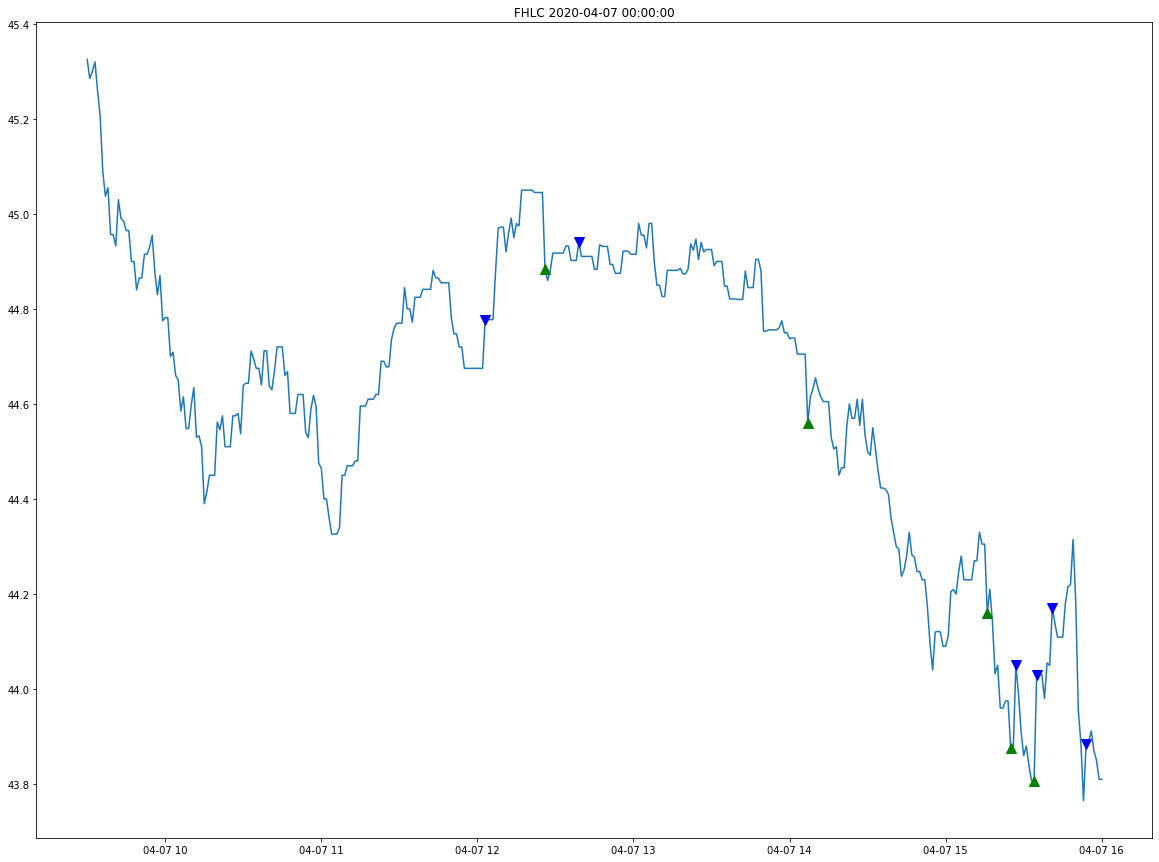

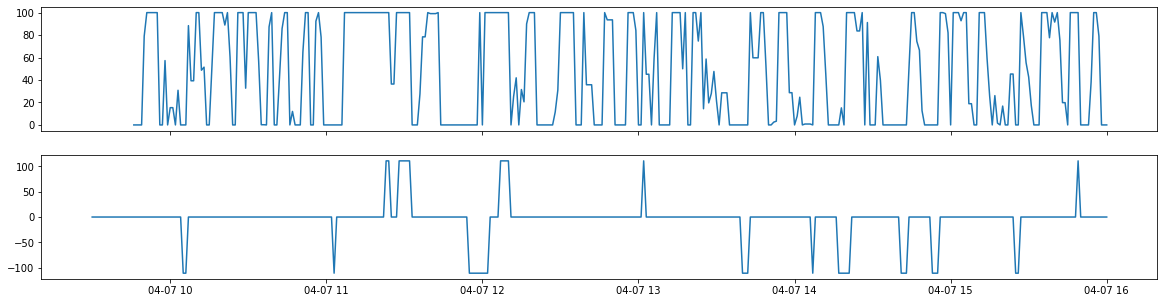

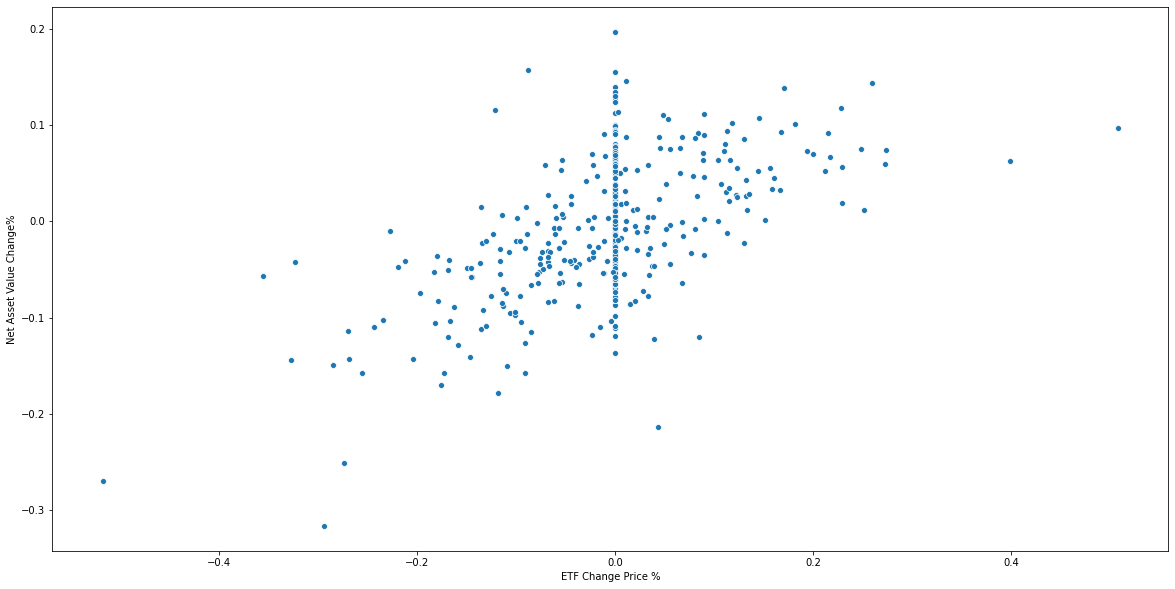

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
16  2020-04-08     UNH    15.254237         84.745763          
2   2020-04-08     MRK    21.875000         78.125000          
10  2020-04-08     PFE    7.692308          92.307692          
14  2020-04-08     ABT    16.666667         83.333333          
12  2020-04-08     MDT    11.111111         88.888889          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
16  42.253521         57.746479         130            59         71         
2   45.714286         54.285714         67             32         35         
10  29.032258         70.967742         57             26         31         
14  47.619048         52.380952         45             24         21         
12  44.444444         55.555556         36             18         18

ETF Name =FHLC
Date =2020-04-08 00:00:00
Sell Positions Probability
T+1    0.6
T+2    0.4
T+3    0.2
T+4    0.1
T+5    0.7
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $     ADX Trend  \
2020-04-08 11:21:00  0.052316                 0.075587        Strong Trend   
2020-04-08 11:36:00  0.050365                 0.086526        Strong Trend   
2020-04-08 12:19:00  0.053731                 0.142336        No Trend       
2020-04-08 12:39:00  0.060185                 0.093531        No Trend       
2020-04-08 13:10:00  0.052317                 0.082142        Weak Trend     
2020-04-08 14:17:00  0.048011                 0.083743        Strong Trend   
2020-04-08 15:31:00  0.035388                 0.090701        No Trend       
2020-04-08 15:44:00  0.039211                 0.075975        Weak Trend     
2020-04-08 15:50:00  0.072602                 0.162676        No Trend       
Total Return        NaN                      NaN              NaN            

                     AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-08 11:21:00  Strong Uptrend  111.0               111.0           
2020-04-08 11:36:00  Strong Uptrend  111.0               111.0           
2020-04-08 12:19:00  NaN             111.0               0.0             
2020-04-08 12:39:00  NaN             111.0               0.0             
2020-04-08 13:10:00  Strong Uptrend  111.0               0.0             
2020-04-08 14:17:00  Strong Uptrend  111.0               111.0           
2020-04-08 15:31:00  Uptrend         111.0               0.0             
2020-04-08 15:44:00  Downtrend       111.0               0.0             
2020-04-08 15:50:00  Strong Uptrend  111.0               0.0             
Total Return         NaN            NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-04-08 11:21:00  111.0          111.0            111.0                  
2020-04-08 11:36:00  111.0          111.0            111.0                  
2020-04-08 12:19:00  0.0            111.0            111.0                  
2020-04-08 12:39:00  0.0            0.0              111.0                  
2020-04-08 13:10:00  0.0            111.0            111.0                  
2020-04-08 14:17:00  111.0          111.0            111.0                  
2020-04-08 15:31:00  0.0            0.0              111.0                  
2020-04-08 15:44:00  0.0            0.0              111.0                  
2020-04-08 15:50:00  0.0            0.0              111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-04-08 11:21:00  111.0            111.0          0.000000  0.013072   
2020-04-08 11:36:00  111.0            111.0          0.075851  0.000000   
2020-04-08 12:19:00  111.0            111.0          0.000000 -0.089566   
2020-04-08 12:39:00  111.0            0.0           -0.063704  0.089465   
2020-04-08 13:10:00  111.0            111.0          0.000000 -0.156250   
2020-04-08 14:17:00  111.0            0.0           -0.033208  0.000000   
2020-04-08 15:31:00  111.0            0.0           -0.073012 -0.031329   
2020-04-08 15:44:00  0.0             -111.0         -0.082724  0.012111   
2020-04-08 15:50:00  0.0              111.0         -0.196507  0.065631   
Total Return        NaN              NaN            -0.373302 -0.096866   

                          T+3       T+4       T+5  
2020-04-08 11:21:00  0.056338  0.000000  0.000000  
2020-04-08 11:36:00  0.000000  0.050454 -0.051438  
2020-04-08 12:19:00  0.098835  0.000000 -0.082841  
2020-04-08 12:39:00 -0.018994  0.000000 -0.042466  
2020-04-08 13:10:00  0.000000  0.063492  0.000000  
2020-04-08 14:17:00  0.013952  0.029671 -0.054677  
2020-04-08 15:31:00 -0.077361 -0.207480  0.000000  
2020-04-08 15:44:00  0.046235  0.062718 -0.020783  
2020-04-08 15:50:00  0.000000  0.087451 -0.233727  
Total Return         0.119003  0.086306 -0.485930

******************
Buy Positions Probability
T+1    0.500000
T+2    0.500000
T+3    0.500000
T+4    0.333333
T+5    0.166667
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-04-08 13:12:00  0.050612                -0.085517        Weak Trend   
2020-04-08 13:38:00  0.048706                -0.074810        Weak Trend   
2020-04-08 15:38:00  0.042206                -0.090081        No Trend     
2020-04-08 15:41:00  0.043694                -0.064361        Weak Trend   
2020-04-08 15:51:00  0.043412                -0.133025        Weak Trend   
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-08 13:12:00  Strong Uptrend   -111.0               0.0             
2020-04-08 13:38:00  Downtrend        -111.0              -111.0           
2020-04-08 15:38:00  Downtrend        -111.0               0.0             
2020-04-08 15:41:00  Strong Downtrend -111.0              -111.0           
2020-04-08 15:51:00  Strong Uptrend    111.0               111.0           
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-04-08 13:12:00  0.0            0.0             -111.0                  
2020-04-08 13:38:00 -111.0          0.0             -111.0                  
2020-04-08 15:38:00  0.0            0.0             -111.0                  
2020-04-08 15:41:00 -111.0         -111.0           -111.0                  
2020-04-08 15:51:00  111.0          0.0              0.0                    
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-04-08 13:12:00 -111.0            111.0          0.000000  0.063492   
2020-04-08 13:38:00 -111.0           -111.0          0.000000  0.147364   
2020-04-08 15:38:00 -111.0           -111.0          0.000000  0.000000   
2020-04-08 15:41:00 -111.0           -111.0          0.152952  0.000000   
2020-04-08 15:51:00  0.0              0.0            0.065631  0.000000   
Total Return        NaN              NaN             0.218583  0.210856   

                          T+3       T+4       T+5  
2020-04-08 13:12:00  0.000000  0.096183 -0.023548  
2020-04-08 13:38:00  0.000000 -0.013397 -0.055941  
2020-04-08 15:38:00 -0.298166  0.152952  0.000000  
2020-04-08 15:41:00  0.237734 -0.082724  0.012111  
2020-04-08 15:51:00  0.087451 -0.233727 -0.132463  
Total Return         0.027019 -0.080712 -0.199843

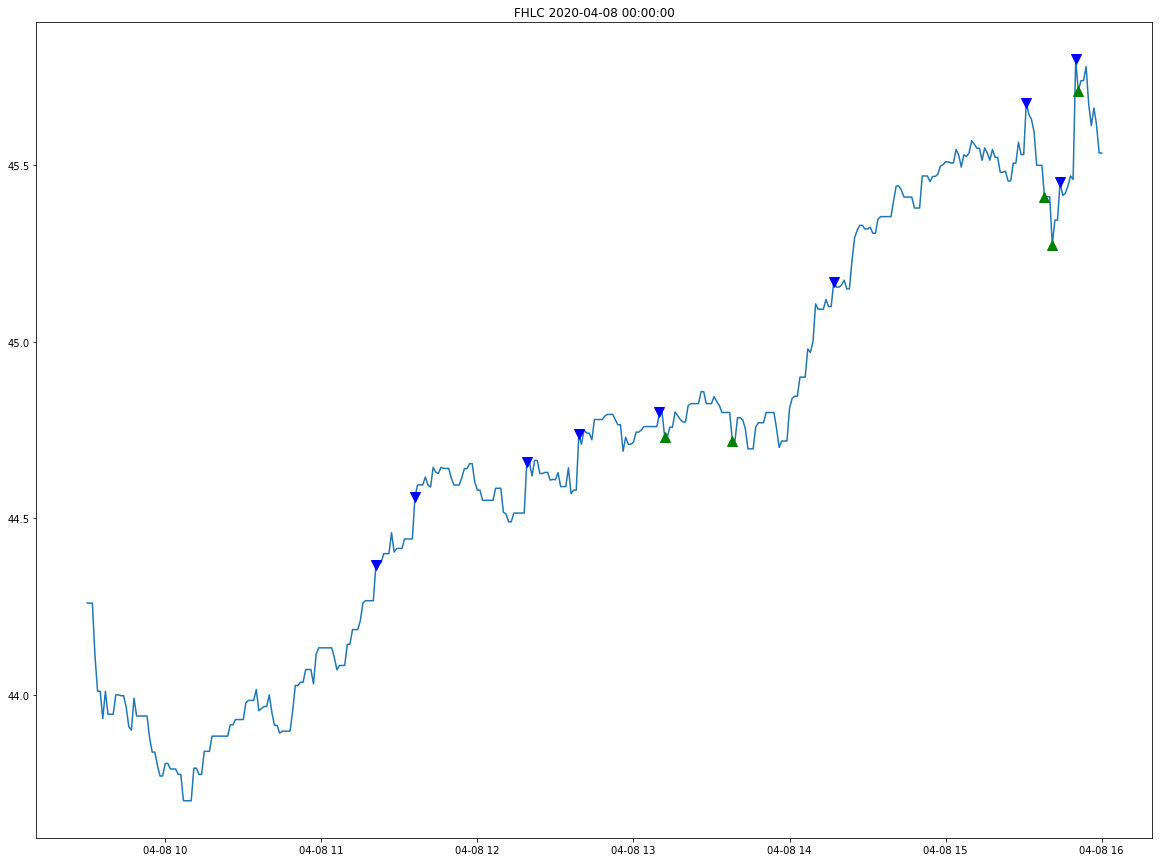

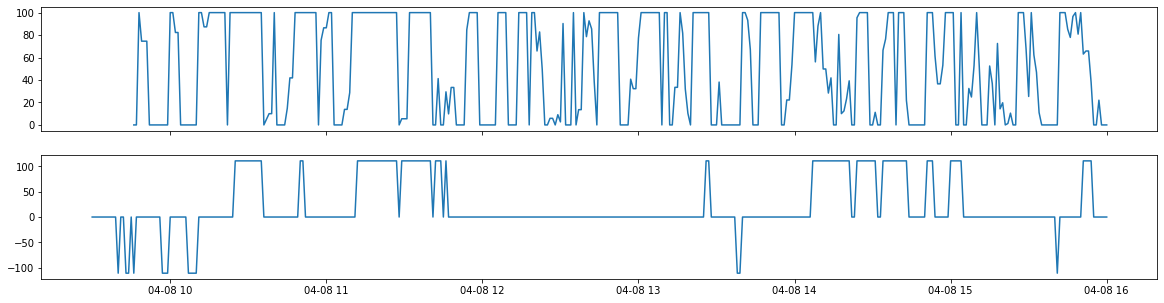

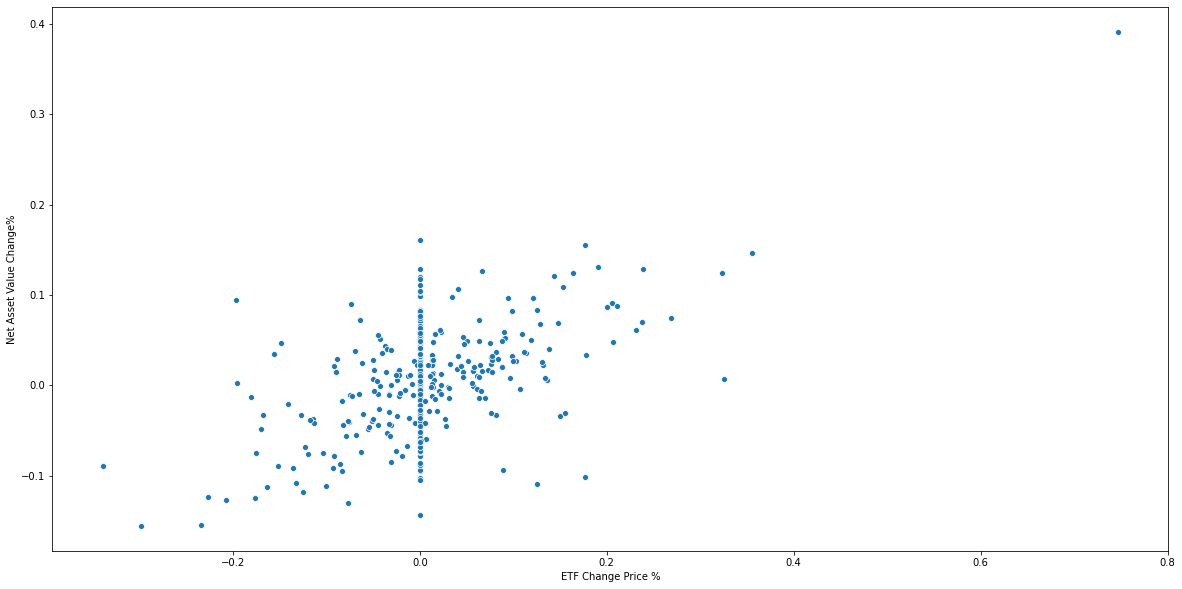

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
16  2020-04-09     UNH    29.090909         70.909091          
2   2020-04-09     MRK    18.181818         81.818182          
10  2020-04-09     PFE    25.806452         74.193548          
12  2020-04-09     MDT    11.764706         88.235294          
3   2020-04-09     TMO    23.076923         76.923077          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
16  50.000000         50.000000         121            55         66         
2   50.000000         50.000000         75             33         42         
10  56.097561         43.902439         72             31         41         
12  54.545455         45.454545         39             17         22         
3   60.000000         40.000000         28             13         15

ETF Name =FHLC
Date =2020-04-09 00:00:00
Sell Positions Probability
T+1    0.6
T+2    0.4
T+3    0.4
T+4    0.4
T+5    0.2
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-04-09 14:33:00  0.049487                 0.071771        Weak Trend   
2020-04-09 15:00:00  0.049817                 0.075348        Weak Trend   
2020-04-09 15:27:00  0.044598                 0.075732        Weak Trend   
2020-04-09 15:30:00  0.038261                 0.071484        Weak Trend   
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-09 14:33:00  NaN               111.0               0.0             
2020-04-09 15:00:00  Strong Downtrend  111.0               0.0             
2020-04-09 15:27:00  NaN               111.0               0.0             
2020-04-09 15:30:00  Strong Uptrend    111.0               111.0           
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-04-09 14:33:00  0.0            0.0              111.0                  
2020-04-09 15:00:00  0.0            0.0              111.0                  
2020-04-09 15:27:00  0.0            0.0              111.0                  
2020-04-09 15:30:00  111.0          0.0              111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-04-09 14:33:00  111.0            0.0           -0.099913  0.034645   
2020-04-09 15:00:00  0.0              0.0            0.034559 -0.052914   
2020-04-09 15:27:00  0.0              0.0           -0.043980  0.000000   
2020-04-09 15:30:00  111.0            111.0          0.043540  0.000000   
Total Return        NaN              NaN            -0.065794 -0.018269   

                          T+3       T+4       T+5  
2020-04-09 14:33:00 -0.043563  0.000000  0.065374  
2020-04-09 15:00:00 -0.016845 -0.044417  0.000000  
2020-04-09 15:27:00  0.305054  0.043540  0.000000  
2020-04-09 15:30:00  0.043412  0.000000 -0.010197  
Total Return         0.288058 -0.000877  0.055176

******************
Buy Positions Probability
T+1    0.000000
T+2    0.666667
T+3    0.000000
T+4    0.000000
T+5    0.666667
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-04-09 11:15:00  0.063099                -0.102313        Weak Trend   
2020-04-09 14:50:00  0.043101                -0.184550        No Trend     
Total Return        NaN                      NaN              NaN          

                    AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-09 11:15:00  NaN           -111.0               0.0             
2020-04-09 14:50:00  NaN           -111.0              -111.0           
Total Return         NaN           NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-04-09 11:15:00  0.0            0.0             -111.0                  
2020-04-09 14:50:00 -111.0         -111.0           -111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-04-09 11:15:00  0.0              0.0            0.000000  0.087642   
2020-04-09 14:50:00 -111.0            0.0           -0.034637  0.000000   
Total Return        NaN              NaN            -0.034637  0.087642   

                          T+3       T+4       T+5  
2020-04-09 11:15:00 -0.109457  0.000000  0.151874  
2020-04-09 14:50:00 -0.010930 -0.142108 -0.087575  
Total Return        -0.120387 -0.142108  0.064299

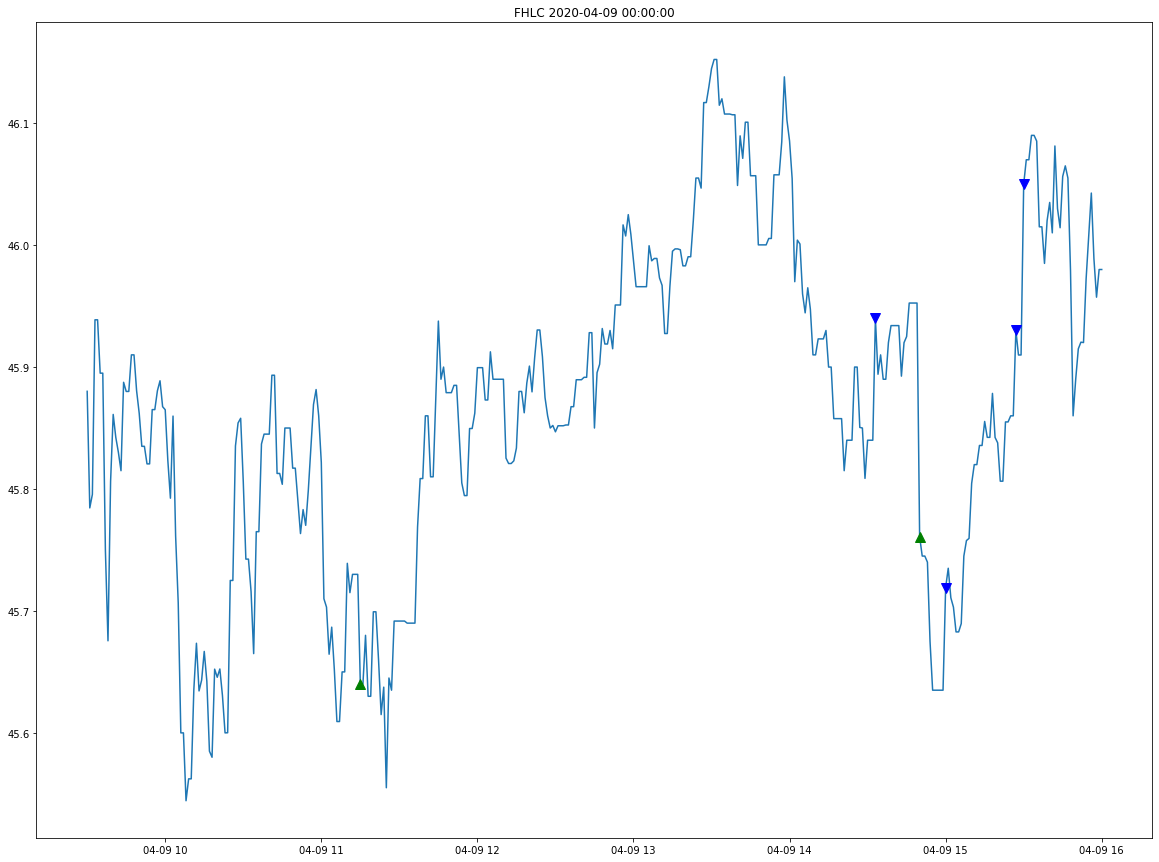

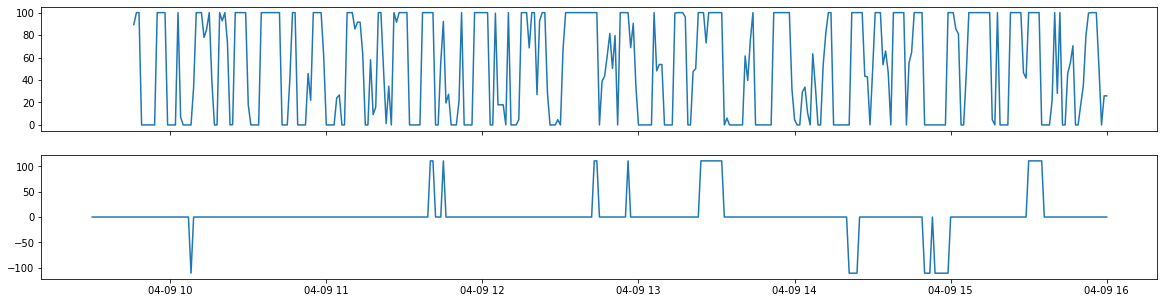

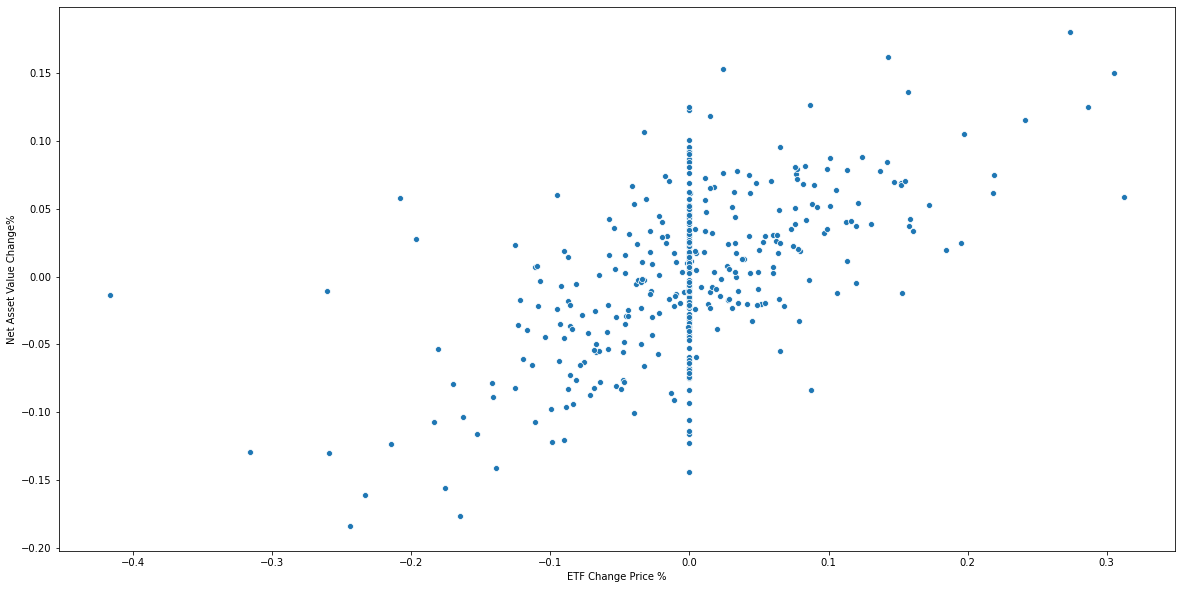

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
15  2020-04-13     UNH    17.647059         82.352941          
2   2020-04-13     MRK    24.242424         75.757576          
12  2020-04-13     ABT    29.166667         70.833333          
1   2020-04-13     ABBV   29.411765         70.588235          
26  2020-04-13     TMO    20.000000         80.000000          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
15  42.857143         57.142857         93             51         42         
2   47.619048         52.380952         75             33         42         
12  45.945946         54.054054         61             24         37         
1   38.461538         61.538462         30             17         13         
26  33.333333         66.666667         24             15         9

ETF Name =FHLC
Date =2020-04-13 00:00:00
Sell Positions Probability
T+1    0.333333
T+2    0.500000
T+3    0.166667
T+4    0.000000
T+5    0.500000
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-04-13 10:59:00  0.059170                 0.084892        Weak Trend   
2020-04-13 11:11:00  0.027436                 0.088385        Weak Trend   
2020-04-13 13:38:00  0.050091                 0.086261        Weak Trend   
2020-04-13 14:33:00  0.050538                 0.113156        Weak Trend   
2020-04-13 15:32:00  0.042437                 0.089086        Weak Trend   
Total Return        NaN                      NaN              NaN          

                     AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-13 10:59:00  NaN             111.0               0.0             
2020-04-13 11:11:00  Downtrend       111.0               0.0             
2020-04-13 13:38:00  Strong Uptrend  111.0               111.0           
2020-04-13 14:33:00  NaN             111.0               0.0             
2020-04-13 15:32:00  Uptrend         111.0               111.0           
Total Return         NaN            NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-04-13 10:59:00  0.0            0.0              111.0                  
2020-04-13 11:11:00  0.0            0.0              111.0                  
2020-04-13 13:38:00  111.0          111.0            111.0                  
2020-04-13 14:33:00  0.0            111.0            111.0                  
2020-04-13 15:32:00  111.0          111.0            111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-04-13 10:59:00  111.0            0.0            0.000000 -0.118682   
2020-04-13 11:11:00  0.0             -111.0          0.000000  0.032233   
2020-04-13 13:38:00  111.0            0.0           -0.038903  0.026093   
2020-04-13 14:33:00  111.0            0.0            0.000000 -0.026852   
2020-04-13 15:32:00  111.0            111.0          0.032913  0.000000   
Total Return        NaN              NaN            -0.005990 -0.087209   

                          T+3       T+4       T+5  
2020-04-13 10:59:00  0.000000  0.000000 -0.055525  
2020-04-13 11:11:00  0.000000  0.027778 -0.072202  
2020-04-13 13:38:00  0.051177  0.000000  0.000000  
2020-04-13 14:33:00  0.000000  0.000000  0.000000  
2020-04-13 15:32:00 -0.010967  0.000000  0.000000  
Total Return         0.040210  0.027778 -0.127727

******************
Buy Positions Probability
T+1    0.75
T+2    0.00
T+3    0.50
T+4    0.00
T+5    0.75
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-04-13 09:30:00  0.076809                -0.195535        0            
2020-04-13 09:49:00  0.056667                -0.107707        No Trend     
2020-04-13 11:10:00  0.037079                -0.058926        Weak Trend   
Total Return        NaN                      NaN              NaN          

                       AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-13 09:30:00  NaN               0.0                 0.0             
2020-04-13 09:49:00  Strong Downtrend -111.0               0.0             
2020-04-13 11:10:00  Strong Downtrend -111.0              -111.0           
Total Return         NaN              NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-04-13 09:30:00  0.0            0.0              0.0                    
2020-04-13 09:49:00  0.0            0.0             -111.0                  
2020-04-13 11:10:00 -111.0          0.0             -111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-04-13 09:30:00  0.0              0.0           -0.035194 -0.158265   
2020-04-13 09:49:00 -111.0            0.0            0.016477 -0.017243   
2020-04-13 11:10:00 -111.0           -111.0          0.246240  0.000000   
Total Return        NaN              NaN             0.227523 -0.175508   

                          T+3      T+4       T+5  
2020-04-13 09:30:00 -0.212664 -0.00547  0.071116  
2020-04-13 09:49:00  0.017686 -0.12169 -0.087970  
2020-04-13 11:10:00  0.032233  0.00000  0.027778  
Total Return        -0.162746 -0.12716  0.010924

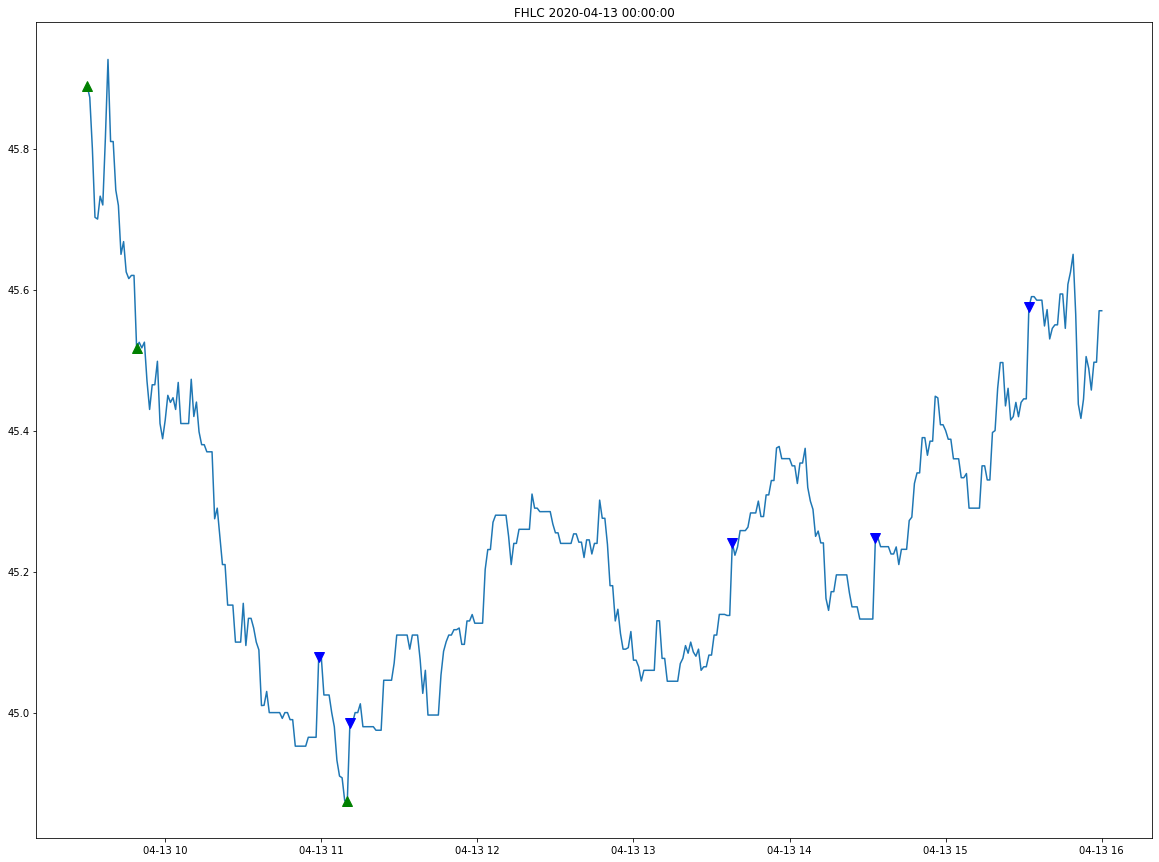

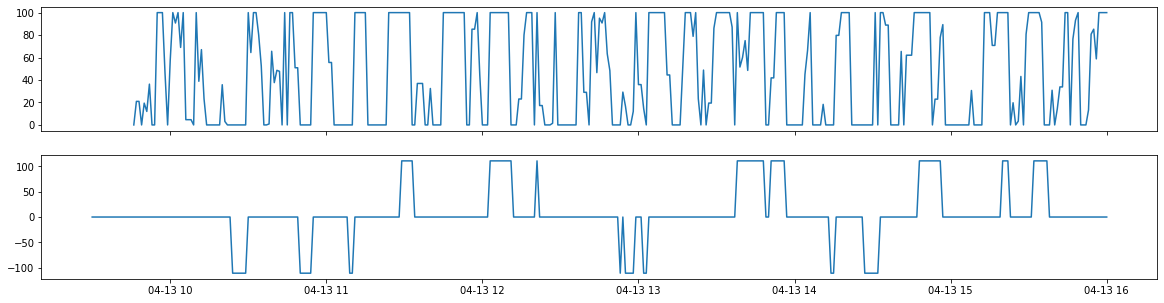

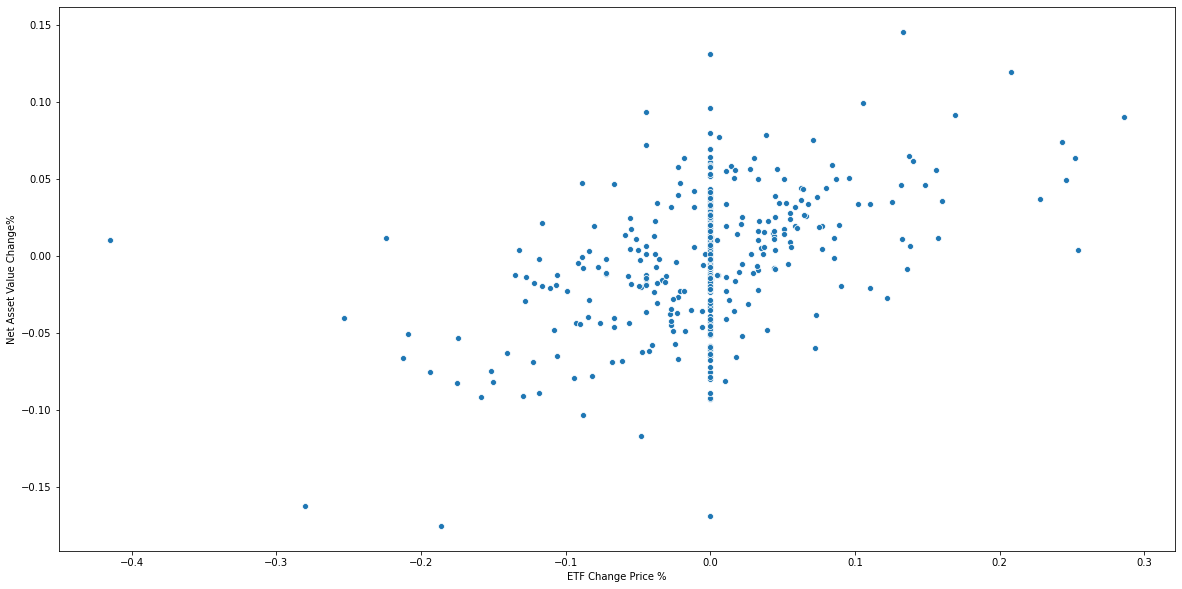

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
14  2020-04-14     UNH    25.641026         74.358974          
2   2020-04-14     MRK    20.833333         79.166667          
8   2020-04-14     PFE    10.000000         90.000000          
11  2020-04-14     ABT    15.384615         84.615385          
25  2020-04-14     TMO    25.000000         75.000000          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
14  37.931034         62.068966         68             39         29         
2   60.000000         40.000000         44             24         20         
8   45.000000         55.000000         40             20         20         
11  35.714286         64.285714         27             13         14         
25  50.000000         50.000000         20             8          12

ETF Name =FHLC
Date =2020-04-14 00:00:00
Sell Positions Probability
T+1    0.0
T+2    0.0
T+3    0.2
T+4    0.4
T+5    0.2
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $     ADX Trend  \
2020-04-14 10:17:00  0.054832                 0.092199        Strong Trend   
2020-04-14 10:20:00  0.031680                 0.054522        Strong Trend   
2020-04-14 12:17:00  0.028421                 0.065461        Weak Trend     
2020-04-14 13:05:00  0.037000                 0.063792        No Trend       
Total Return        NaN                      NaN              NaN            

                     AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-14 10:17:00  Strong Uptrend  111.0               111.0           
2020-04-14 10:20:00  Strong Uptrend  111.0               111.0           
2020-04-14 12:17:00  Uptrend         111.0               0.0             
2020-04-14 13:05:00  Downtrend       111.0               0.0             
Total Return         NaN            NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-04-14 10:17:00  111.0          111.0            111.0                  
2020-04-14 10:20:00  111.0          111.0            111.0                  
2020-04-14 12:17:00  0.0            0.0              111.0                  
2020-04-14 13:05:00  0.0            0.0              111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-04-14 10:17:00  111.0            111.0          0.000000  0.000000   
2020-04-14 10:20:00  111.0            111.0          0.019087  0.029318   
2020-04-14 12:17:00  111.0            0.0            0.000000  0.000000   
2020-04-14 13:05:00  0.0             -111.0          0.000000  0.000000   
Total Return        NaN              NaN             0.019087  0.029318   

                          T+3       T+4       T+5  
2020-04-14 10:17:00  0.147366  0.019087  0.029318  
2020-04-14 10:20:00 -0.106152 -0.093889  0.091948  
2020-04-14 12:17:00  0.042589  0.026181  0.000000  
2020-04-14 13:05:00  0.000000  0.000000 -0.011504  
Total Return         0.083804 -0.048621  0.109762

******************
Buy Positions Probability
T+1    1.0
T+2    0.0
T+3    0.0
T+4    0.0
T+5    0.0
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $ ADX Trend  \
2020-04-14 10:56:00  0.061412                -0.093371        No Trend   
Total Return        NaN                      NaN              NaN        

                    AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-14 10:56:00  Downtrend     -111.0               0.0             
Total Return         NaN           NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-04-14 10:56:00  0.0           -111.0           -111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1  T+2       T+3  \
2020-04-14 10:56:00 -111.0           -111.0          0.064092  0.0 -0.057421   
Total Return        NaN              NaN             0.064092  0.0 -0.057421   

                          T+4  T+5  
2020-04-14 10:56:00 -0.017332  0.0  
Total Return        -0.017332  0.0

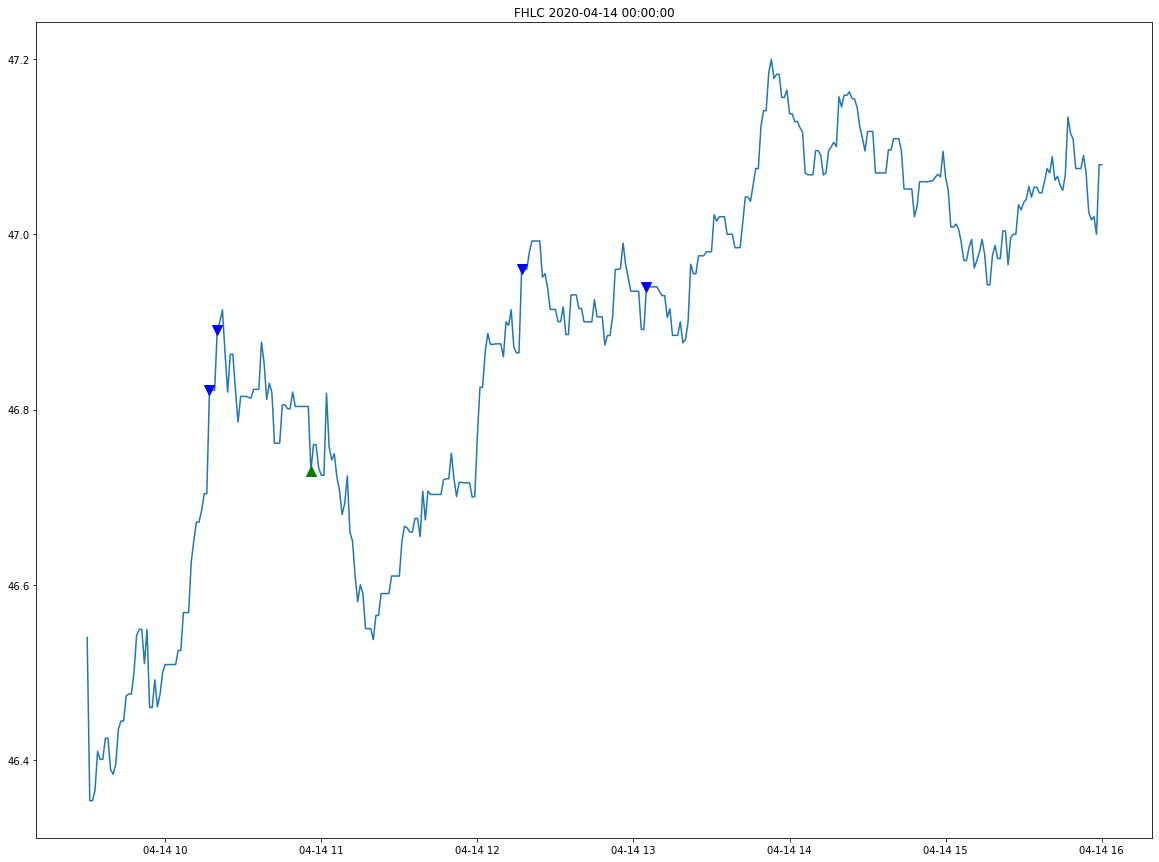

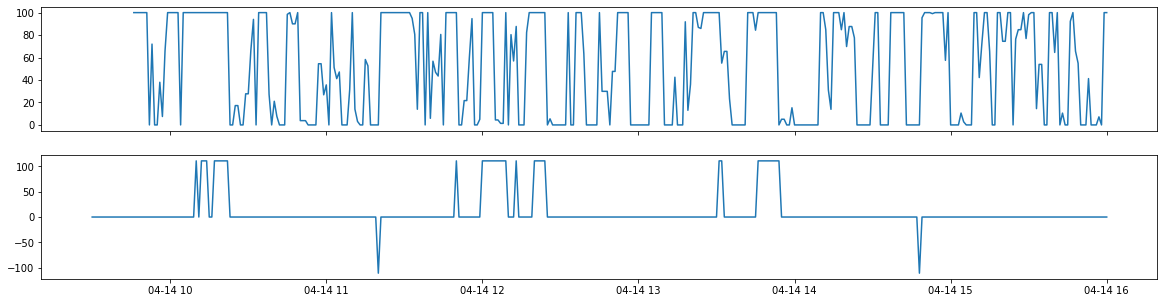

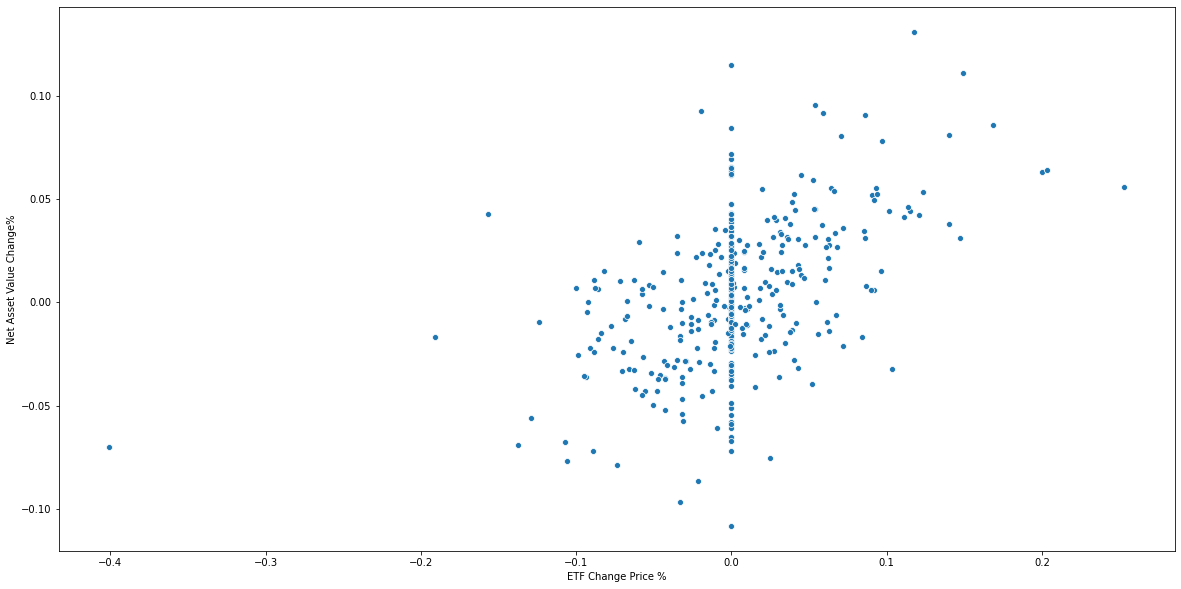

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
14  2020-04-15     UNH    19.148936         80.851064          
11  2020-04-15     ABT    9.375000          90.625000          
2   2020-04-15     MRK    19.230769         80.769231          
1   2020-04-15     ABBV   29.411765         70.588235          
24  2020-04-15     TMO    30.769231         69.230769          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
14  27.659574         72.340426         94             47         47         
11  40.000000         60.000000         67             32         35         
2   25.000000         75.000000         50             26         24         
1   36.842105         63.157895         36             17         19         
24  50.000000         50.000000         23             13         10

ETF Name =FHLC
Date =2020-04-15 00:00:00
Sell Positions Probability
T+1    0.444444
T+2    0.777778
T+3    0.111111
T+4    0.555556
T+5    0.333333
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-04-15 09:39:00  0.059143                 0.137164        0            
2020-04-15 10:47:00  0.061061                 0.115923        Weak Trend   
2020-04-15 10:58:00  0.049496                 0.071932        Weak Trend   
2020-04-15 11:33:00  0.046136                 0.075538        Weak Trend   
2020-04-15 12:05:00  0.029423                 0.053607        No Trend     
2020-04-15 12:46:00  0.036000                 0.079650        Weak Trend   
2020-04-15 14:58:00  0.032476                 0.057118        No Trend     
2020-04-15 15:45:00  0.034519                 0.060383        No Trend     
Total Return        NaN                      NaN              NaN          

                     AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-15 09:39:00  NaN             111.0               0.0             
2020-04-15 10:47:00  Strong Uptrend  111.0               111.0           
2020-04-15 10:58:00  Strong Uptrend  111.0               111.0           
2020-04-15 11:33:00  Uptrend         111.0               111.0           
2020-04-15 12:05:00  NaN             111.0               0.0             
2020-04-15 12:46:00  Strong Uptrend  111.0               111.0           
2020-04-15 14:58:00  Strong Uptrend  111.0               0.0             
2020-04-15 15:45:00  NaN             111.0               0.0             
Total Return         NaN            NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-04-15 09:39:00  0.0            0.0              0.0                    
2020-04-15 10:47:00  111.0          111.0            111.0                  
2020-04-15 10:58:00  111.0          111.0            111.0                  
2020-04-15 11:33:00  111.0          111.0            111.0                  
2020-04-15 12:05:00  0.0            0.0              111.0                  
2020-04-15 12:46:00  111.0          0.0              111.0                  
2020-04-15 14:58:00  0.0            0.0              111.0                  
2020-04-15 15:45:00  0.0            0.0              111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-04-15 09:39:00  111.0            0.0           -0.094116 -0.074632   
2020-04-15 10:47:00  111.0            0.0            0.000000  0.000000   
2020-04-15 10:58:00  111.0            111.0         -0.007220  0.024893   
2020-04-15 11:33:00  111.0            0.0            0.000000 -0.107868   
2020-04-15 12:05:00  0.0              0.0            0.000000 -0.087583   
2020-04-15 12:46:00  111.0            111.0         -0.008265 -0.000751   
2020-04-15 14:58:00  111.0           -111.0          0.009575 -0.014894   
2020-04-15 15:45:00  111.0            0.0            0.021867 -0.018769   
Total Return        NaN              NaN            -0.078158 -0.279605   

                          T+3       T+4       T+5  
2020-04-15 09:39:00 -0.153896 -0.011210  0.000000  
2020-04-15 10:47:00  0.074287  0.019205  0.000000  
2020-04-15 10:58:00  0.000000 -0.149539  0.000000  
2020-04-15 11:33:00  0.035135 -0.042749  0.000000  
2020-04-15 12:05:00  0.000646 -0.098429 -0.016708  
2020-04-15 12:46:00  0.000000  0.121512  0.068938  
2020-04-15 14:58:00  0.000000  0.000000  0.004256  
2020-04-15 15:45:00  0.053972  0.000640 -0.231761  
Total Return         0.010145 -0.160569 -0.175276

******************
Buy Positions Probability
T+1    0.0
T+2    0.0
T+3    0.0
T+4    0.0
T+5    1.0
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-04-15 11:41:00  0.048627                -0.112736        Weak Trend   
Total Return        NaN                      NaN              NaN          

                    AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-15 11:41:00  Downtrend     -111.0               0.0             
Total Return         NaN           NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-04-15 11:41:00  0.0            0.0             -111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator  T+1       T+2  T+3  T+4  \
2020-04-15 11:41:00 -111.0           -111.0          0.0 -0.045363  0.0  0.0   
Total Return        NaN              NaN             0.0 -0.045363  0.0  0.0   

                          T+5  
2020-04-15 11:41:00  0.014876  
Total Return         0.014876

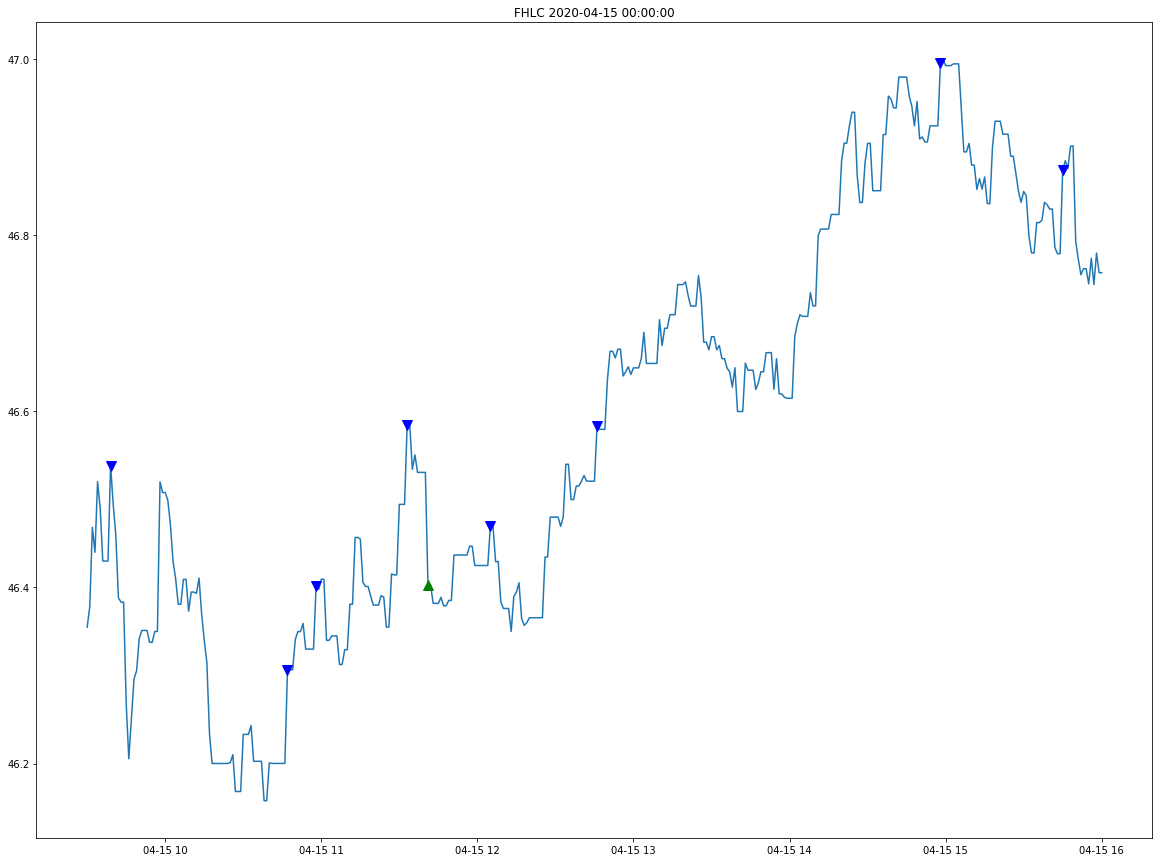

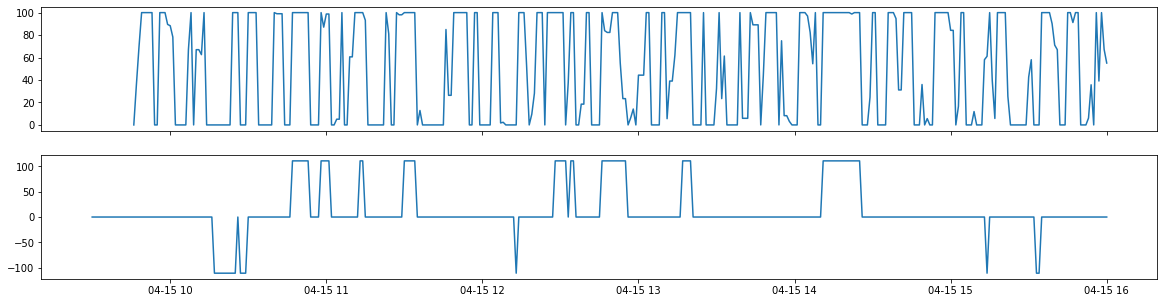

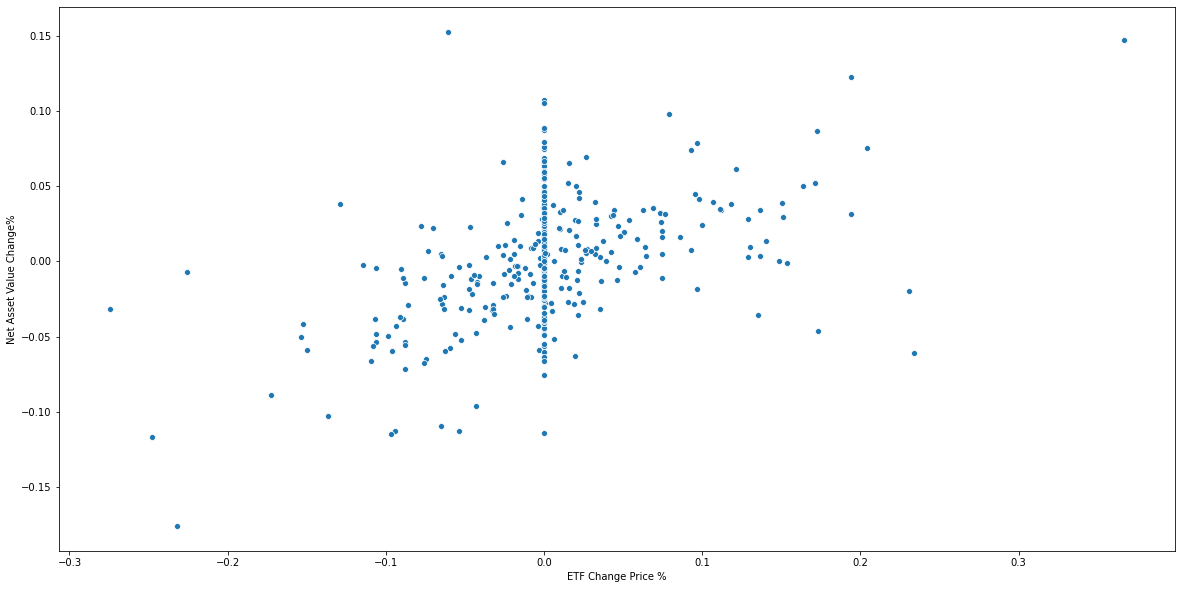

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
16  2020-04-16     UNH    16.666667         83.333333          
14  2020-04-16     ABT    19.354839         80.645161          
9   2020-04-16     PFE    7.142857          92.857143          
2   2020-04-16     MRK    11.111111         88.888889          
12  2020-04-16     MDT    0.000000          100.000000         

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
16  19.444444         80.555556         72             36         36         
14  22.222222         77.777778         67             31         36         
9   28.571429         71.428571         42             28         14         
2   27.272727         72.727273         38             27         11         
12  16.666667         83.333333         21             9          12

ETF Name =FHLC
Date =2020-04-16 00:00:00
Sell Positions Probability
T+1    0.166667
T+2    0.500000
T+3    0.166667
T+4    0.000000
T+5    0.000000
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-04-16 10:23:00  0.031364                 0.051551        Weak Trend   
2020-04-16 12:59:00  0.054000                 0.082456        No Trend     
2020-04-16 13:20:00  0.045641                 0.074529        Weak Trend   
2020-04-16 14:09:00  0.036170                 0.071753        Weak Trend   
2020-04-16 14:37:00  0.041838                 0.088217        Weak Trend   
Total Return        NaN                      NaN              NaN          

                     AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-16 10:23:00  Strong Uptrend  111.0               0.0             
2020-04-16 12:59:00  NaN             111.0               0.0             
2020-04-16 13:20:00  Strong Uptrend  111.0               111.0           
2020-04-16 14:09:00  Uptrend         111.0               111.0           
2020-04-16 14:37:00  Strong Uptrend  111.0               111.0           
Total Return         NaN            NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-04-16 10:23:00  0.0            111.0            111.0                  
2020-04-16 12:59:00  0.0            0.0              111.0                  
2020-04-16 13:20:00  111.0          0.0              111.0                  
2020-04-16 14:09:00  111.0          111.0            111.0                  
2020-04-16 14:37:00  111.0          111.0            111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-04-16 10:23:00  111.0           -111.0          0.000000  0.010618   
2020-04-16 12:59:00  111.0           -111.0          0.000000  0.000000   
2020-04-16 13:20:00  111.0            0.0            0.051308 -0.055925   
2020-04-16 14:09:00  111.0            0.0           -0.008204  0.000000   
2020-04-16 14:37:00  111.0            111.0          0.020759 -0.013207   
Total Return        NaN              NaN             0.063863 -0.058514   

                          T+3       T+4       T+5  
2020-04-16 10:23:00  0.000000  0.074318  0.000000  
2020-04-16 12:59:00  0.000000  0.052938  0.000000  
2020-04-16 13:20:00  0.066092  0.010973  0.000000  
2020-04-16 14:09:00  0.024298  0.000000  0.092226  
2020-04-16 14:37:00 -0.051159  0.000000  0.000000  
Total Return         0.039231  0.138229  0.092226

******************
Buy Positions Probability
T+1    0.0
T+2    0.0
T+3    0.0
T+4    0.0
T+5    0.0
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $   ADX Trend  \
2020-04-16 11:29:00  0.036043                -0.070775        No Trend     
2020-04-16 12:04:00  0.045584                -0.071451        Weak Trend   
Total Return        NaN                      NaN              NaN          

                    AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-16 11:29:00  NaN           -111.0               0.0             
2020-04-16 12:04:00  NaN           -111.0              -111.0           
Total Return         NaN           NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-04-16 11:29:00  0.0            0.0             -111.0                  
2020-04-16 12:04:00 -111.0         -111.0           -111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  T+3  \
2020-04-16 11:29:00 -111.0            0.0           -0.023196 -0.016241  0.0   
2020-04-16 12:04:00 -111.0           -111.0          0.000000  0.000000  0.0   
Total Return        NaN              NaN            -0.023196 -0.016241  0.0   

                     T+4       T+5  
2020-04-16 11:29:00  0.0 -0.055483  
2020-04-16 12:04:00  0.0 -0.106939  
Total Return         0.0 -0.162422

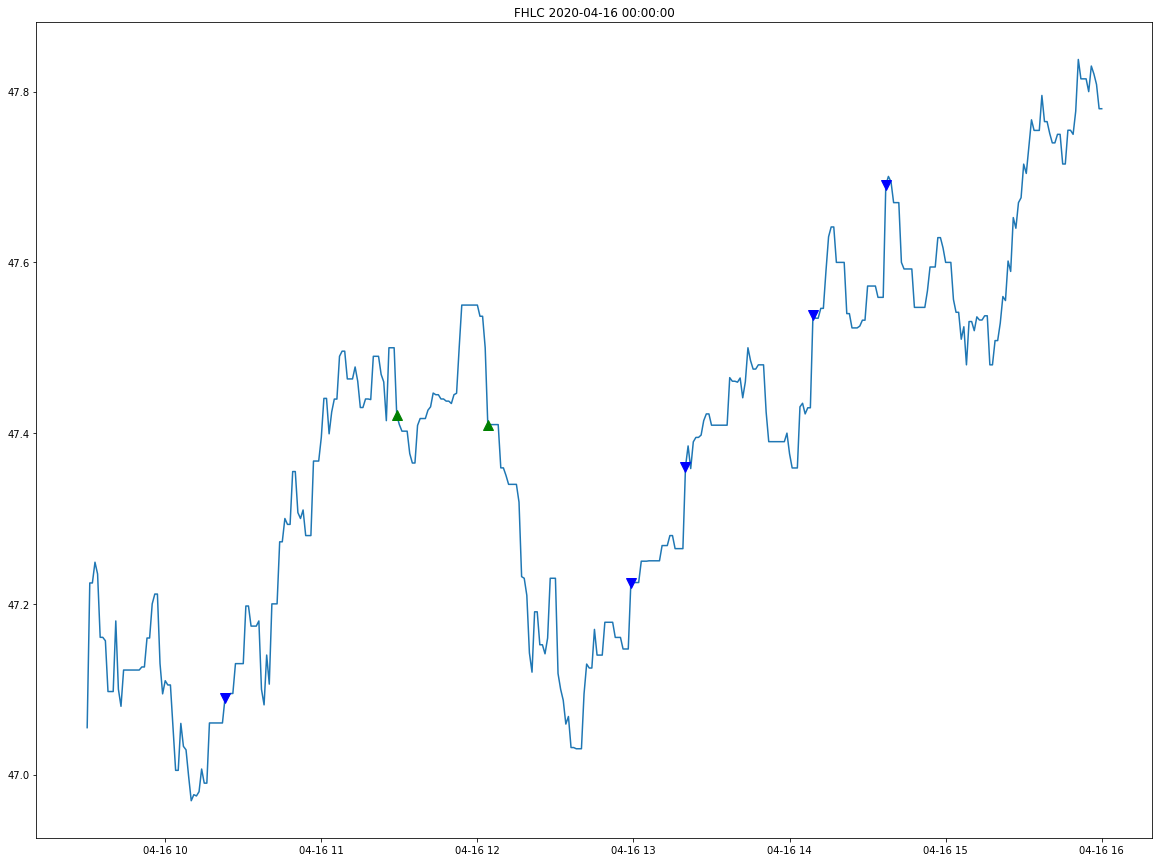

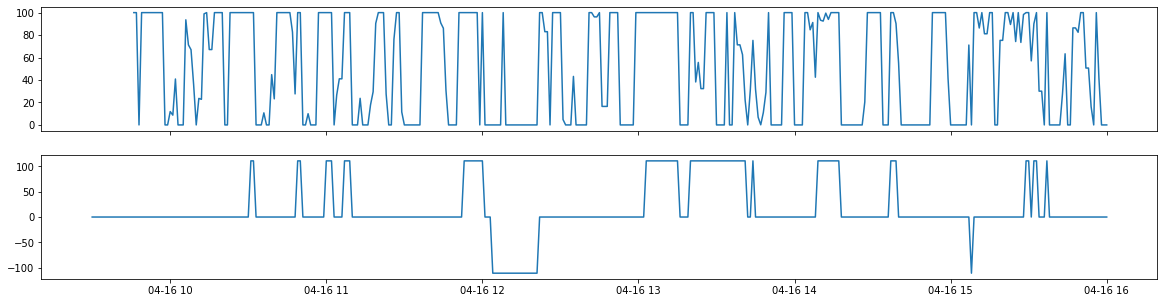

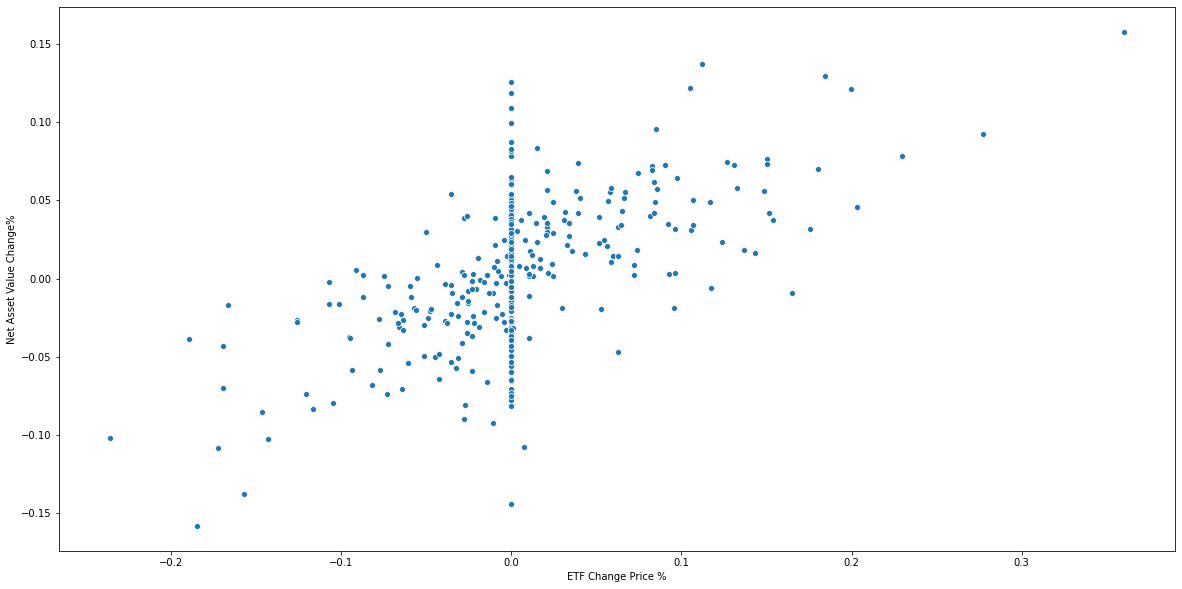

dateOfAnalysis Movers  Arb +ve/ T+1 +ve  Arb +ve/ T+1 -ve  \
14  2020-04-17     UNH    25.925926         74.074074          
2   2020-04-17     MRK    18.181818         81.818182          
12  2020-04-17     ABT    15.000000         85.000000          
4   2020-04-17     GILD   23.076923         76.923077          
9   2020-04-17     PFE    41.176471         58.823529          

    Arb -ve/ T+1 +ve  Arb -ve/ T+1 -ve TotalNoOfCases total_arbp total_arbn  
14  57.142857         42.857143         55             27         28         
2   47.619048         52.380952         43             22         21         
12  31.578947         68.421053         39             20         19         
4   45.000000         55.000000         33             13         20         
9   30.769231         69.230769         30             17         13

ETF Name =FHLC
Date =2020-04-17 00:00:00
Sell Positions Probability
T+1    0.0
T+2    0.0
T+3    1.0
T+4    0.0
T+5    0.0
dtype: float64
Sell Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $ ADX Trend  \
2020-04-17 12:14:00  0.040984                 0.073462        No Trend   
Total Return        NaN                      NaN              NaN        

                    AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-17 12:14:00  Uptrend        111.0               0.0             
Total Return         NaN           NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-04-17 12:14:00  0.0            0.0              111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator  T+1  T+2       T+3  T+4  \
2020-04-17 12:14:00  111.0            111.0          0.0  0.0 -0.051224  0.0   
Total Return        NaN              NaN             0.0  0.0 -0.051224  0.0   

                         T+5  
2020-04-17 12:14:00  0.10343  
Total Return         0.10343

******************
Buy Positions Probability
T+1    0.00
T+2    0.00
T+3    0.25
T+4    0.25
T+5    0.00
dtype: float64
Buy Positions N+1 Days


ETF Trading Spread in $  Arbitrage in $ ADX Trend  \
2020-04-17 09:30:00  0.149239                -0.342300        0          
2020-04-17 09:31:00  0.092800                -0.286041        0          
2020-04-17 14:31:00  0.012500                -0.045608        No Trend   
Total Return        NaN                      NaN              NaN        

                    AROONOSC Trend  Momentum Indicator  CMO Indicator  \
2020-04-17 09:30:00  NaN            0.0                 0.0             
2020-04-17 09:31:00  NaN            0.0                 0.0             
2020-04-17 14:31:00  Downtrend     -111.0              -111.0           
Total Return         NaN           NaN                 NaN              

                     RSI Indicator  ULTOC Indicator  Stochastic Indicator  \
2020-04-17 09:30:00  0.0            0.0              0.0                    
2020-04-17 09:31:00  0.0            0.0              0.0                    
2020-04-17 14:31:00 -111.0         -111.0           -111.0                  
Total Return        NaN            NaN              NaN                     

                     WILLR Indicator  MFI Indicator       T+1       T+2  \
2020-04-17 09:30:00  0.0              0.0           -0.745969 -0.281559   
2020-04-17 09:31:00  0.0              0.0           -0.281559 -0.219734   
2020-04-17 14:31:00 -111.0           -111.0          0.000000 -0.012807   
Total Return        NaN              NaN            -1.027527 -0.514100   

                          T+3       T+4       T+5  
2020-04-17 09:30:00 -0.219734  0.009275 -0.168162  
2020-04-17 09:31:00  0.009275 -0.168162 -0.187230  
2020-04-17 14:31:00 -0.006198 -0.063219 -0.046514  
Total Return        -0.216657 -0.222107 -0.401907

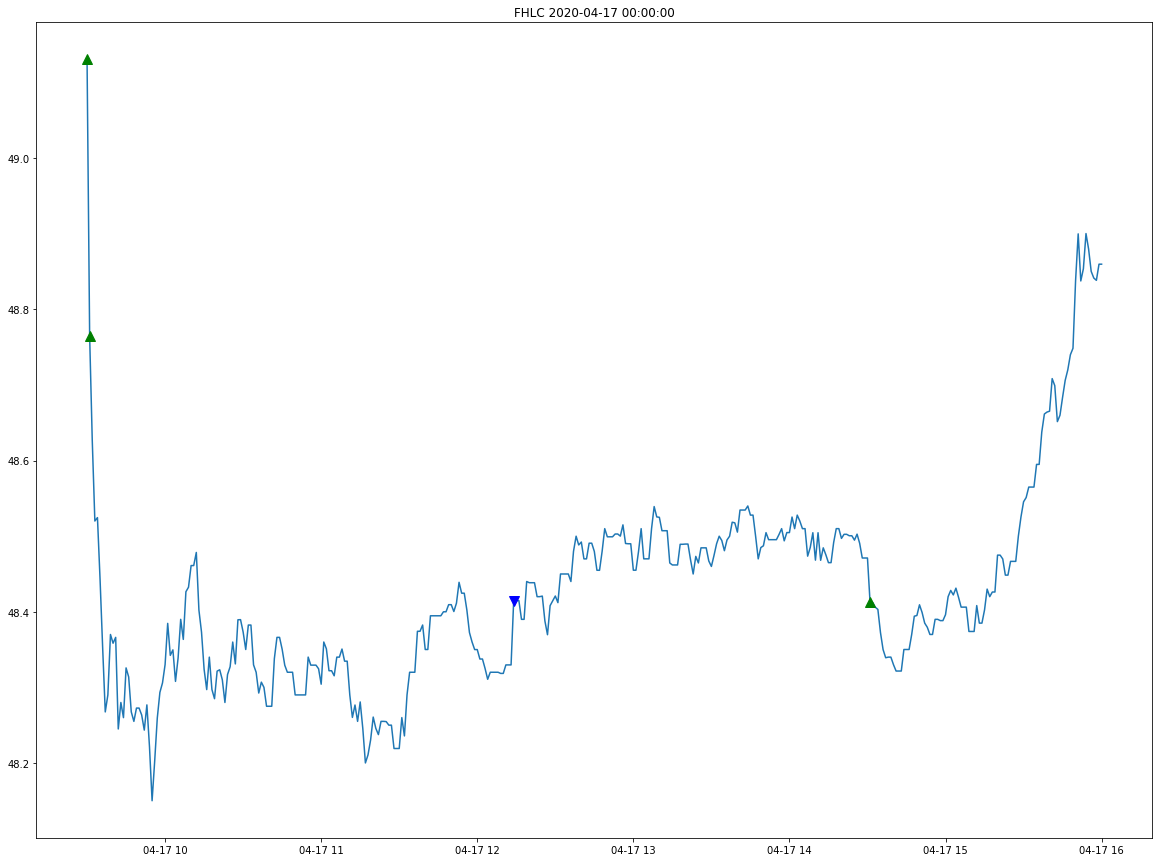

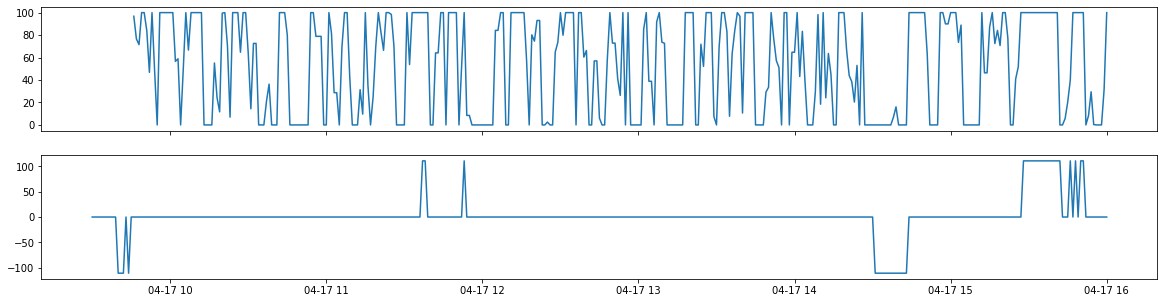

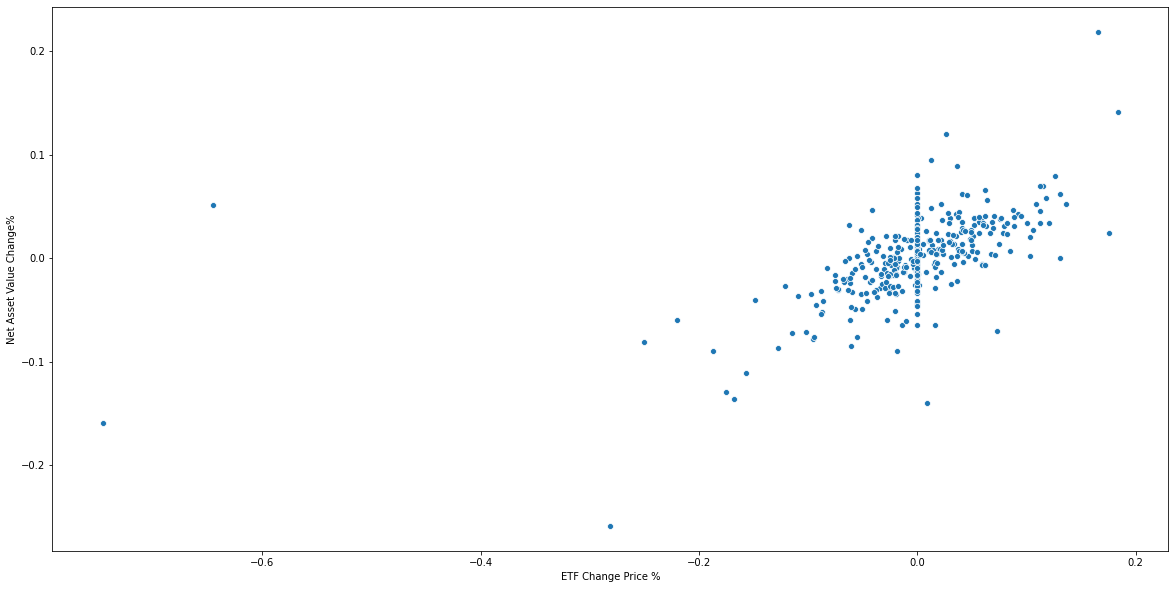

In [21]:
etfname='FHLC'
s=arbitragecollection.find({'ETFName':etfname}).sort([('dateOfAnalysis', 1)])
for i in s:
    dateOfAnalysis=(i['dateOfAnalysis'])
    year=dateOfAnalysis.year
    # Load Prices Data
    pricedf=LoadETFPrices(etfname,dateOfAnalysis,year)
    # Load Arbitrage Data
    etfdata=loadETFArbitrageData(i['data'],dateOfAnalysis,year)
    
    ArbTP1df = Arb_Tp1(etfdata,dateOfAnalysis.strftime('%Y-%m-%d'),0.02)
    display(ArbTP1df.head())
    
    df=pd.merge(etfdata,pricedf,on='Time',how='left')
    df=df.ffill(axis=0)
    
    magnitute = 0.02
    df['Magnitude of Arbitrage']=abs(df['ETF Trading Spread in $']-abs(df['Arbitrage in $']))
    df['Flag'] = 0
    a = (abs(df['Arbitrage in $']) > df['ETF Trading Spread in $'])
    b = df['ETF Trading Spread in $'] != 0
    c = df['Magnitude of Arbitrage'] > magnitute
    df.loc[a & b & c, 'Flag'] = 111
    df['Flag'] = df['Flag'] * np.sign(df['Arbitrage in $'])
    df=df.set_index('Time')
    
    # Build Signals
    df=BuildSignals(df,tp=10)
    
    print("ETF Name ="+ etfname)
    
    plt.figure(figsize=(20,15))
    plt.plot(df.index,df['ETF Price'], label='ETF Price')
    #plt.plot(df.index, df['Momentum Signal'], label='Momentum Signal')
    
    columnsneeded=['ETF Trading Spread in $','Arbitrage in $','ADX Trend','AROONOSC Trend','Momentum Indicator','CMO Indicator','RSI Indicator','ULTOC Indicator','Stochastic Indicator','WILLR Indicator','MFI Indicator']
    etfOverBought = df.loc[df['Flag']== 111.0]
    if etfOverBought.shape[0]!=0:
        sellPositions = analysePerformance(df=df, BuySellIndex=etfOverBought)
        print("Date ="+str(dateOfAnalysis))
        print("Sell Positions Probability")
        print(sellPositions[sellPositions<0].count()/sellPositions.shape[0])
        
        tempdf=df.loc[etfOverBought.index]
        tempdf=tempdf[columnsneeded]
        sellPositions=pd.merge(tempdf,sellPositions,how='outer',left_index=True,right_index=True)
        
        print("Sell Positions N+1 Days")
        display(sellPositions)
        plt.plot(etfOverBought.index, df.loc[etfOverBought.index]['ETF Price'], 'v', markersize=10, color='b')
        
    etfOverSold = df.loc[df['Flag']== -111.0]
    if etfOverSold.shape[0]!=0:
        buyPositions  = analysePerformance(df=df, BuySellIndex=etfOverSold)
        print("******************")
        print("Buy Positions Probability")
        print(buyPositions[buyPositions>0].count()/buyPositions.shape[0])
        print("Buy Positions N+1 Days")
        
        tempdf=df.loc[etfOverSold.index]
        tempdf=tempdf[columnsneeded]
        buyPositions=pd.merge(tempdf,buyPositions,how='outer',left_index=True,right_index=True)
        
        display(buyPositions)
        plt.plot(etfOverSold.index, df.loc[etfOverSold.index]['ETF Price'], '^', markersize=10, color='g')
    plt.title(etfname+' '+str(dateOfAnalysis))
    plt.show()

    fig, ax = plt.subplots(nrows=2,sharex=True,figsize=(20, 5))
    ax[0].plot(df.index,df['FastStochastic'])
    ax[1].plot(df.index,df['CMO Indicator'])
    plt.show()


    a4_dims = (20,10)
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.scatterplot(x=df['ETF Change Price %'], y=df['Net Asset Value Change%'])
    plt.show()
    
    '''
    if dateOfAnalysis.strftime('%Y-%m-%d')=='2020-03-18':
        break
    '''

In [20]:

talib.CDLDOJI(df['Open'],df['High'],df['Low'],df['Close'])

Time
2020-04-17 09:30:00    0  
2020-04-17 09:31:00    0  
2020-04-17 09:32:00    0  
2020-04-17 09:33:00    0  
2020-04-17 09:34:00    0  
2020-04-17 09:35:00    0  
2020-04-17 09:36:00    0  
2020-04-17 09:37:00    0  
2020-04-17 09:38:00    0  
2020-04-17 09:39:00    0  
2020-04-17 09:40:00    100
2020-04-17 09:41:00    0  
2020-04-17 09:42:00    0  
2020-04-17 09:43:00    100
2020-04-17 09:44:00    0  
2020-04-17 09:45:00    0  
2020-04-17 09:46:00    0  
2020-04-17 09:47:00    0  
2020-04-17 09:48:00    100
2020-04-17 09:49:00    0  
2020-04-17 09:50:00    0  
2020-04-17 09:51:00    0  
2020-04-17 09:52:00    0  
2020-04-17 09:53:00    0  
2020-04-17 09:54:00    0  
2020-04-17 09:55:00    100
2020-04-17 09:56:00    0  
2020-04-17 09:57:00    0  
2020-04-17 09:58:00    0  
2020-04-17 09:59:00    0  
2020-04-17 10:00:00    0  
2020-04-17 10:01:00    0  
2020-04-17 10:02:00    0  
2020-04-17 10:03:00    100
2020-04-17 10:04:00    0  
2020-04-17 10:05:00    100
2020-04-17 10:06:00    